# Soccer Match Betting

By: Titilayo(Teetee) Amuwo

<img src="Images/Soccer-Betting-.jpeg" width="1250" height="300">

## Overview

This notebook contains my approach to building a predictive model with the aim to minimize risk while maximizing the return on investment on soccer betting. Building a predictive model for Soccer betting is a daunting task due to many studies all over the world trying to beat the bookmakers. However, the factors contributing to betting odds are not fully traceable and in contrast to rating-based forecasts, no straightforward measure of team specific quality is deducible from the betting odds. My methodology combine different Machine Learning algorithms with different odds to build a forecasting soccer model that predict the winner of a game base on the Soccer Power Index, past performance and the odds. After several tuning,I came up with a model that can achieve higher accuracy comparing to other studies with the same purpose. I also concentrated on the best performance metrics while also minimizing the loss function.

## Business Problem

Forecasting sports events like matches or tournaments has attracted the interest of different communities all over the world for quite a long time and sport events like soccer matches take place regularly, which generate huge public attention. winning soccer matches is becoming an essential aspect of soccer clubs and soccer fans. Also, The global sport gambling system is multi trillion dollar rich while there are billions of soccer fans that gamble everyday without yielding a return. My aim is to educate these set of people to make a better decision using my model to predict the soccer game before making a bet with that,they can minimize loss and yield high return.

## StakeHolder:

- Soccer Analyst and Soccer Fans

## Aim of Business Problem:

- My aim is to develop an accurate model that predicts a soccer game using the Soccer Power Index.

## Context:

- False Negative: In this context predict that a soccer team will not win or draw a match when actually they win or draw.
    
- False Postive: In this context predict that a soccer team will win or draw a match when actually they will not win or draw.

## Evaluation:

- the metrics I will be looking at are:
    
    - ** Accuracy
    - ** logloss
    - ** Precision
    - ** Recall
    - ** f1 score

## Data Understanding

The dataset was obtained  from https://projects.fivethirtyeight.com/soccer-predictions/ , and the soccer archive odds was downloaded from https://www.kaggle.com/sashchernuh/european-football. 
- The first dataset is organized into four folders with a total of 66542rows and 27columns.
    - spi global rankings intl
    - spi global rankings
    - spi matches latest
    - spi matches    
- The second dataset is organized into one folder with a total of 12674rows and 13columns.
    - Football data 

- After cleaning and merging the two dataset I end up with a 24750rows and 27columns.
     - Data cleaning notebook can be found in the notebook folder.
        - Data cleaning process;
          * remove unused leagues from each data csv file.
          * change the date to python datetime.
          * split the season date, in order to use just the year. 
          * drop the season column, and create a new one.
          * fill nan with zeros for the bet365 column, which I end up dropping due to less values.
          * drop nan for the scores to avoid bias information.
          
- Create the target from the home and away scores, with that I have a multiclass category (Draw/HomeWin/AwayWin).

## Import necessary liabries

In [252]:
#import necessary liabries
import numpy as np
from numpy import array
from numpy import array
from numpy import argmax
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import plotly.express as px
import itertools
import math
import time
import pickle

from matplotlib.legend_handler import HandlerBase
sns.set(style='whitegrid',font_scale=1.5)
%matplotlib inline


import statsmodels.formula.api as sm
import xgboost as xgb
from scipy import stats
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report,accuracy_score,recall_score,precision_score,f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import ROCAUC

import warnings
warnings.filterwarnings('ignore')

In [7]:
soccer_data = pd.read_csv("../Data/soccer-spi/soccer_matches_df.csv",index_col=0)
club_data = pd.read_csv("../Data/soccer-spi/spi_data_df.csv",index_col=0)

In [8]:
soccer_data.head()

,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,results,B365_Home,B365_Draw,B365A_way
0,2016,2016-08-12,1843.0,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,...,0.97,0.63,0.43,0.45,0.00,1.05,NaN,NaN,NaN,NaN
1,2016,2016-08-12,1843.0,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,...,2.45,0.77,1.75,0.42,2.10,2.10,NaN,NaN,NaN,NaN
2,2016,2016-08-13,2411.0,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,...,0.85,2.77,0.17,1.25,2.10,1.05,NaN,NaN,NaN,NaN
3,2016,2016-08-13,2411.0,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,...,0.73,1.11,0.88,1.81,1.05,1.05,NaN,NaN,NaN,NaN
4,2016,2016-08-13,2411.0,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,...,1.11,0.68,0.84,1.60,0.00,1.05,NaN,NaN,NaN,NaN


In [9]:
soccer_data.shape

(24750, 27)

In [10]:
club_data.head()

,rank,prev_rank,name,league,off,def,spi
0,1,1,Bayern Munich,German Bundesliga,3.64,0.51,93.72
1,2,2,Manchester City,Barclays Premier League,2.97,0.24,93.57
2,3,3,Liverpool,Barclays Premier League,3.06,0.46,91.04
3,4,4,Chelsea,Barclays Premier League,2.47,0.24,90.32
5,6,6,Real Madrid,Spanish Primera Division,2.57,0.62,84.21


In [11]:
soccer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24750 entries, 0 to 24749
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       24750 non-null  int64  
 1   date         24750 non-null  object 
 2   league_id    13680 non-null  float64
 3   league       24750 non-null  object 
 4   team1        24750 non-null  object 
 5   team2        24750 non-null  object 
 6   spi1         13680 non-null  float64
 7   spi2         13680 non-null  float64
 8   prob1        13680 non-null  float64
 9   prob2        13680 non-null  float64
 10  probtie      13680 non-null  float64
 11  proj_score1  13680 non-null  float64
 12  proj_score2  13680 non-null  float64
 13  importance1  11994 non-null  float64
 14  importance2  11994 non-null  float64
 15  score1       23390 non-null  float64
 16  score2       23390 non-null  float64
 17  xg1          12314 non-null  float64
 18  xg2          12314 non-null  float64
 19  nsxg

In [12]:
soccer_data.describe()

,season,league_id,spi1,spi2,prob1,prob2,probtie,proj_score1,proj_score2,importance1,...,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,B365_Home,B365_Draw,B365A_way
count,24750.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,11994.000000,...,23390.000000,12314.000000,12314.000000,12314.000000,12314.000000,12314.000000,12314.000000,9660.000000,9660.000000,9660.000000
mean,2018.347717,1958.655629,63.577162,63.476290,0.458527,0.300371,0.241103,1.568612,1.189004,33.883250,...,1.204190,1.568042,1.246478,1.450485,1.183272,1.592817,1.248203,2.847969,4.039480,4.504832
std,1.564454,205.612514,15.665622,15.726236,0.174071,0.158286,0.049817,0.465360,0.459225,26.350038,...,1.159051,0.887404,0.782651,0.711202,0.621314,1.286074,1.158185,2.119511,1.285261,3.807476
min,2016.000000,1818.000000,19.990000,19.290000,0.027000,0.003200,0.000000,0.240000,0.200000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.400000,1.100000
25%,2017.000000,1845.000000,54.840000,54.737500,0.349675,0.196400,0.223200,1.260000,0.890000,14.000000,...,0.000000,0.910000,0.660000,0.950000,0.740000,1.050000,0.000000,1.720000,3.390000,2.380000
50%,2018.000000,1854.000000,64.410000,64.380000,0.451150,0.279300,0.252400,1.490000,1.120000,28.600000,...,1.000000,1.430000,1.100000,1.340000,1.080000,1.050000,1.050000,2.250000,3.600000,3.300000
75%,2020.000000,1951.000000,74.440000,74.352500,0.558325,0.378725,0.273000,1.790000,1.400000,49.300000,...,2.000000,2.080000,1.670000,1.817500,1.490000,2.100000,2.100000,3.000000,4.200000,5.000000
max,2021.000000,2411.000000,96.570000,96.780000,0.977500,0.881600,0.342300,4.030000,3.430000,100.000000,...,9.000000,7.070000,5.990000,6.890000,5.920000,8.760000,7.230000,23.000000,21.000000,41.000000


In [13]:
club_data.describe()

,rank,prev_rank,off,def,spi
count,128.000000,128.000000,128.000000,128.000000,128.000000
mean,118.804688,118.867188,1.762266,1.040391,61.447266
std,112.485104,112.590077,0.420177,0.365005,14.928278
min,1.000000,1.000000,1.000000,0.240000,23.930000
25%,38.750000,38.750000,1.467500,0.787500,51.377500
50%,79.500000,79.500000,1.700000,0.995000,63.295000
75%,164.250000,168.750000,1.980000,1.250000,71.595000
max,513.000000,513.000000,3.640000,2.090000,93.720000


## Data Preparation

The data features are not clearly defined so I had to rename some of the features and create a target for the dataset. After creating the target I noticed that there was a slightly imbalanced multi-classification problem, but that should not affect the business case. Also, during the preparation I had to address the missing values and drop some redundant columns that are not needed for the analysis due to multicollinearity and data leakeage. 

Now I am going to create the target using the scores from the two games, Home and Away. I will drop the result column since we are not going to need it.

In [14]:
#drop the result column
soccer_data=soccer_data.drop(['results','league_id'],axis=1)
soccer_data.head()

,season,date,league,team1,team2,spi1,spi2,prob1,prob2,probtie,...,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,B365_Home,B365_Draw,B365A_way
0,2016,2016-08-12,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,...,1.0,0.97,0.63,0.43,0.45,0.00,1.05,NaN,NaN,NaN
1,2016,2016-08-12,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,...,2.0,2.45,0.77,1.75,0.42,2.10,2.10,NaN,NaN,NaN
2,2016,2016-08-13,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,...,1.0,0.85,2.77,0.17,1.25,2.10,1.05,NaN,NaN,NaN
3,2016,2016-08-13,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,...,1.0,0.73,1.11,0.88,1.81,1.05,1.05,NaN,NaN,NaN
4,2016,2016-08-13,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,...,1.0,1.11,0.68,0.84,1.60,0.00,1.05,NaN,NaN,NaN


In [15]:
soccer_data.shape

(24750, 25)

In [16]:
soccer_data.isna().sum()

season             0
date               0
league             0
team1              0
team2              0
spi1           11070
spi2           11070
prob1          11070
prob2          11070
probtie        11070
proj_score1    11070
proj_score2    11070
importance1    12756
importance2    12756
score1          1360
score2          1360
xg1            12436
xg2            12436
nsxg1          12436
nsxg2          12436
adj_score1     12436
adj_score2     12436
B365_Home      15090
B365_Draw      15090
B365A_way      15090
dtype: int64

In [17]:
#remove the null values in score1 column
soccer_data = soccer_data[soccer_data['score1'].notna()]
soccer_data.head()

,season,date,league,team1,team2,spi1,spi2,prob1,prob2,probtie,...,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,B365_Home,B365_Draw,B365A_way
0,2016,2016-08-12,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,...,1.0,0.97,0.63,0.43,0.45,0.00,1.05,NaN,NaN,NaN
1,2016,2016-08-12,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,...,2.0,2.45,0.77,1.75,0.42,2.10,2.10,NaN,NaN,NaN
2,2016,2016-08-13,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,...,1.0,0.85,2.77,0.17,1.25,2.10,1.05,NaN,NaN,NaN
3,2016,2016-08-13,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,...,1.0,0.73,1.11,0.88,1.81,1.05,1.05,NaN,NaN,NaN
4,2016,2016-08-13,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,...,1.0,1.11,0.68,0.84,1.60,0.00,1.05,NaN,NaN,NaN


In [18]:
soccer_data = soccer_data[soccer_data['score2'].notna()]
soccer_data.head()

,season,date,league,team1,team2,spi1,spi2,prob1,prob2,probtie,...,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,B365_Home,B365_Draw,B365A_way
0,2016,2016-08-12,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,...,1.0,0.97,0.63,0.43,0.45,0.00,1.05,NaN,NaN,NaN
1,2016,2016-08-12,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,...,2.0,2.45,0.77,1.75,0.42,2.10,2.10,NaN,NaN,NaN
2,2016,2016-08-13,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,...,1.0,0.85,2.77,0.17,1.25,2.10,1.05,NaN,NaN,NaN
3,2016,2016-08-13,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,...,1.0,0.73,1.11,0.88,1.81,1.05,1.05,NaN,NaN,NaN
4,2016,2016-08-13,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,...,1.0,1.11,0.68,0.84,1.60,0.00,1.05,NaN,NaN,NaN


In [19]:
soccer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23390 entries, 0 to 24749
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       23390 non-null  int64  
 1   date         23390 non-null  object 
 2   league       23390 non-null  object 
 3   team1        23390 non-null  object 
 4   team2        23390 non-null  object 
 5   spi1         12320 non-null  float64
 6   spi2         12320 non-null  float64
 7   prob1        12320 non-null  float64
 8   prob2        12320 non-null  float64
 9   probtie      12320 non-null  float64
 10  proj_score1  12320 non-null  float64
 11  proj_score2  12320 non-null  float64
 12  importance1  11899 non-null  float64
 13  importance2  11899 non-null  float64
 14  score1       23390 non-null  float64
 15  score2       23390 non-null  float64
 16  xg1          12314 non-null  float64
 17  xg2          12314 non-null  float64
 18  nsxg1        12314 non-null  float64
 19  nsxg

In [20]:
soccer_data.shape

(23390, 25)

Define a function that will assist with creating the target from the scores.

In [21]:
def make_target(df):
    """
    input: the dataframe(df)
    0=draw
    1=team1(home)- win
    2=team2(Away)- win
    """
    if df['score1'] == df['score2']:
        return 0
    elif df['score1'] > df['score2']:
        return 1
    elif df['score1'] < df['score2']:
        return 2
    else:
        return 'none'

In [22]:
#Create a target column
soccer_data['target'] = soccer_data.apply(make_target,axis=1)
soccer_data.head()

,season,date,league,team1,team2,spi1,spi2,prob1,prob2,probtie,...,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,B365_Home,B365_Draw,B365A_way,target
0,2016,2016-08-12,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,...,0.97,0.63,0.43,0.45,0.00,1.05,NaN,NaN,NaN,2
1,2016,2016-08-12,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,...,2.45,0.77,1.75,0.42,2.10,2.10,NaN,NaN,NaN,0
2,2016,2016-08-13,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,...,0.85,2.77,0.17,1.25,2.10,1.05,NaN,NaN,NaN,1
3,2016,2016-08-13,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,...,0.73,1.11,0.88,1.81,1.05,1.05,NaN,NaN,NaN,0
4,2016,2016-08-13,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,...,1.11,0.68,0.84,1.60,0.00,1.05,NaN,NaN,NaN,2


In [23]:
#checking if the target is balanced
soccer_data.target.value_counts(normalize=True)

1    0.451389
2    0.300770
0    0.247841
Name: target, dtype: float64

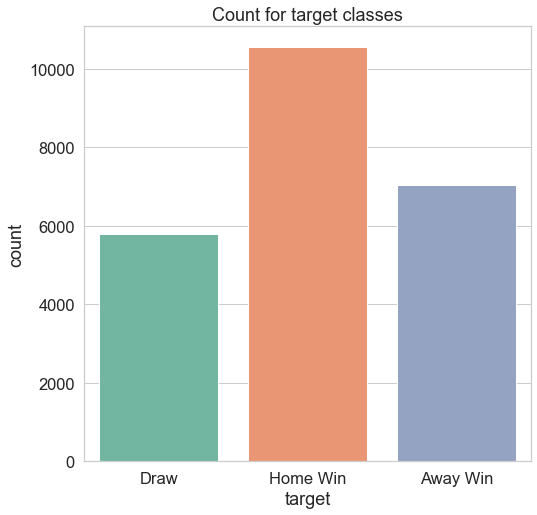

In [24]:
#plot the target to view the target class
plt.figure(figsize=(8,8))
ax=sns.countplot(x = soccer_data["target"],palette = 'Set2')
plt.title("Count for target classes")
labels=['Draw','Home Win','Away Win']
ax.set_xticklabels(labels)
plt.show()

Looking at the plot above, you can see that the data is slightly imbalance and it clearly shows that most matches always end with a home win. Now we will be looking at the features and visualizing how they correlate with the target while we check for multicollinearity.

# Data Visualization

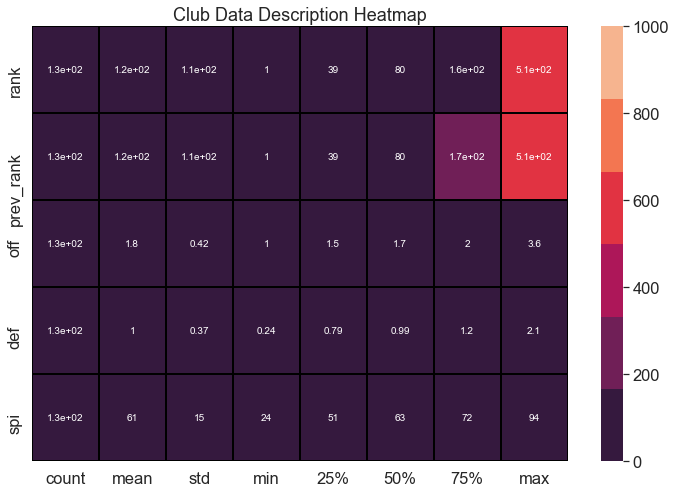

In [25]:
#let's visualize the club data description
plt.figure(figsize=(12,8))
ax=sns.heatmap(club_data.describe().transpose(),annot=True,fmt='.2g',
               linecolor='black',linewidths=1,vmin =0,vmax=1000,
               cmap=sns.color_palette('rocket'))
plt.title("Club Data Description Heatmap")
plt.show()

The club data tells us that the mean of the soccer power index of the team is 61 and the standard deviation of the previous rank of the teams and latest rank is 1. Let's look at the multicollinearity among the features on the soccer dataset.

Text(0.5, 1.0, 'MultiCollinearity Btw target and Features ')

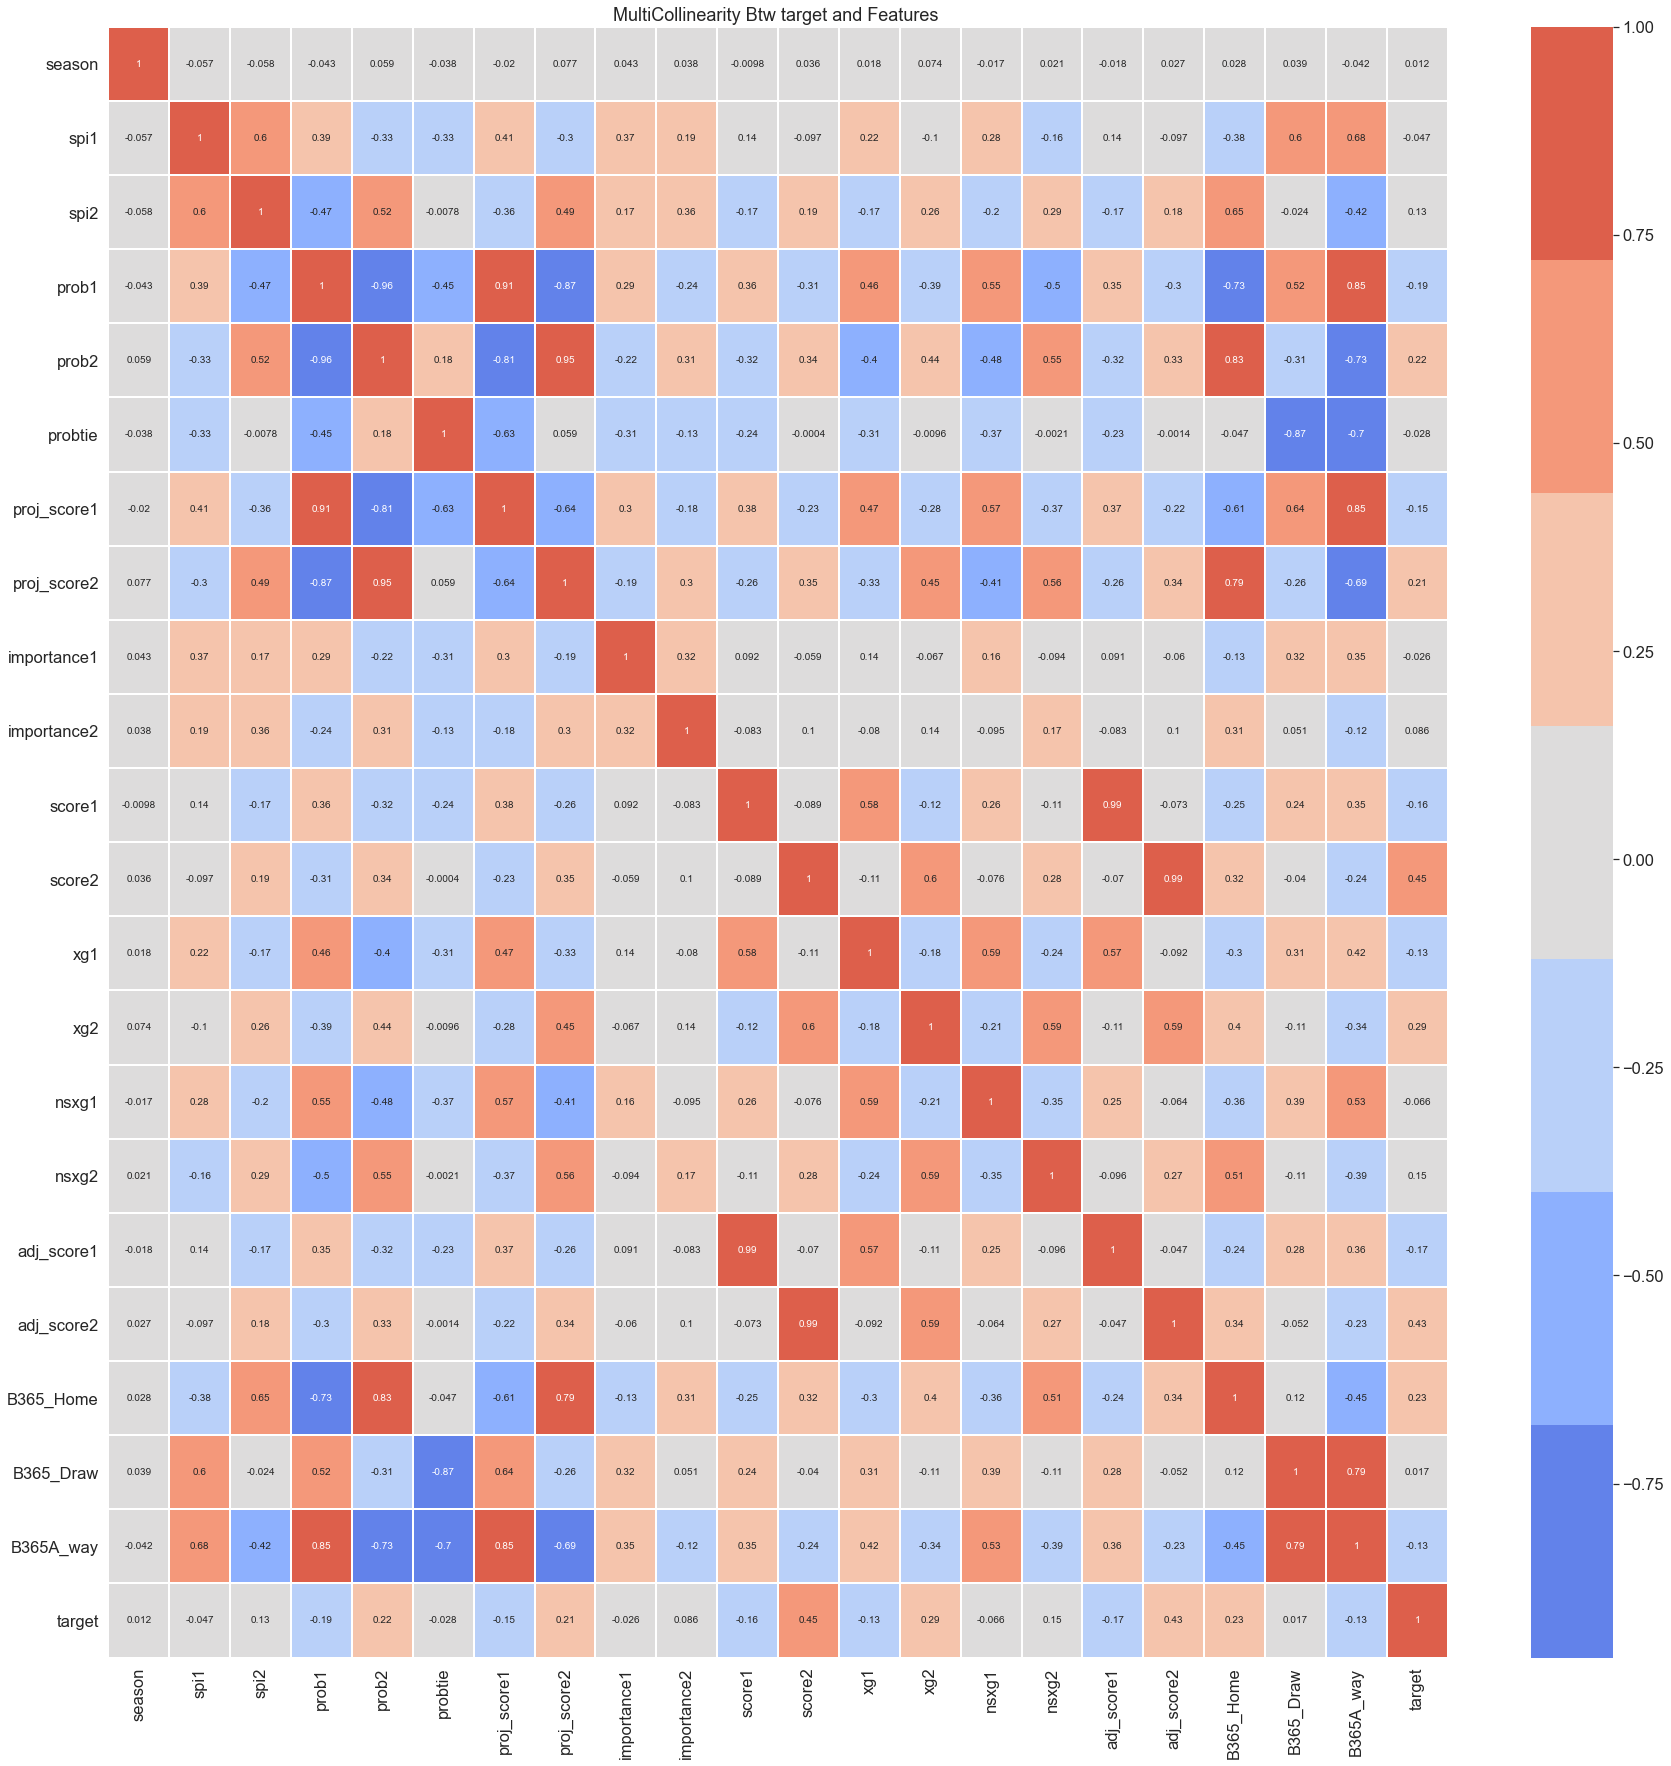

In [26]:
#let's visualize the multicolinearity among the features on soccer dataset
plt.figure(figsize=(30,30))
correlation = soccer_data.corr()
ax=sns.heatmap(correlation,annot=True,cmap =sns.color_palette('coolwarm',7),
              linewidths=1,linecolor='white')
plt.title("MultiCollinearity Btw target and Features ")

Looking at the table,there is multicollinearity between the scores and the adjusted scores. Also, there are some redundant columns that we need to drop because they will not add meaningful information to our model. I will drop the dates, nsxg1 and nsxg2, the projected scores due to the close correlation between the prob1 and prob2.

In [27]:
#drop redundant columns
soccer_final_df = soccer_data.drop(['date','nsxg1','nsxg2','proj_score1',
                                    'adj_score1','adj_score2','proj_score2',],axis =1)
soccer_final_df.head()

,season,league,team1,team2,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,B365_Home,B365_Draw,B365A_way,target
0,2016,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,32.4,67.7,0.0,1.0,0.97,0.63,NaN,NaN,NaN,2
1,2016,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.0,2.0,2.45,0.77,NaN,NaN,NaN,0
2,2016,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,2.0,1.0,0.85,2.77,NaN,NaN,NaN,1
3,2016,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,31.9,48.0,1.0,1.0,0.73,1.11,NaN,NaN,NaN,0
4,2016,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,43.6,34.6,0.0,1.0,1.11,0.68,NaN,NaN,NaN,2


In [28]:
soccer_final_df.shape

(23390, 19)

In [29]:
#fill the nan value with 0 for the Bet365 odd columns
soccer_final_df.update(soccer_final_df[['B365_Home','B365_Draw','B365A_way']].fillna(0))

Text(0.5, 1.0, 'MultiCollinearity Btw target and Features ')

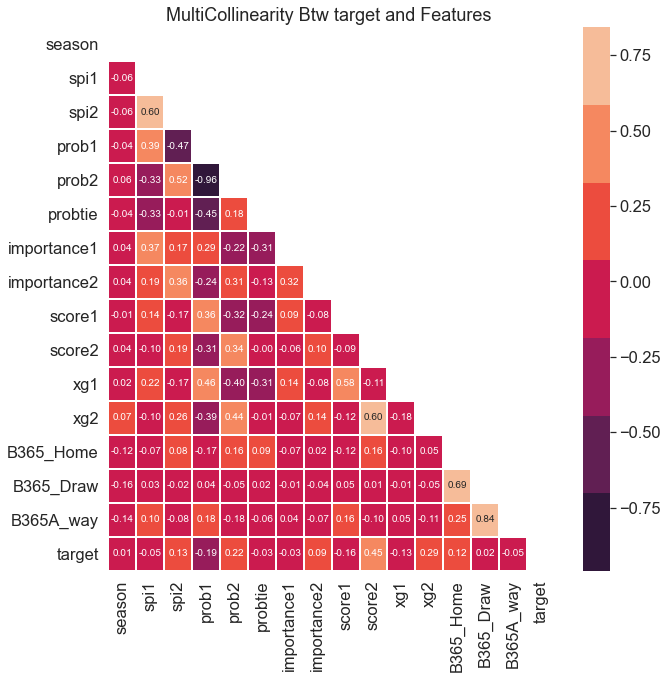

In [30]:
#plot the new dataframe to check multicollinearity
plt.figure(figsize = (10,10))
ax = sns.heatmap(soccer_final_df.corr(),mask =np.triu(np.ones_like(soccer_final_df.corr(),dtype = bool)), 
            annot = True,cmap =sns.color_palette('rocket',7),
            linewidths=1,linecolor='white',fmt='.2f')
plt.title("MultiCollinearity Btw target and Features ")

Now everything seems to be fine except for the bet365 odds, due to not having enough data, most of the columns is empty, even though I filled with zeros, there is not enough odds to use in processing the model. I will be dropping it aswell. 

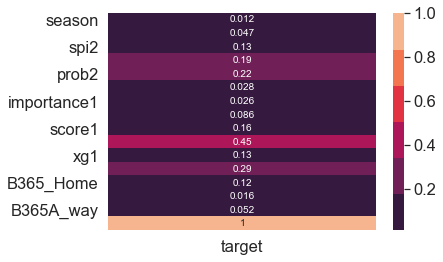

In [31]:
#checking to see the most correlated features
sns.heatmap(abs(soccer_final_df.corr())[['target']], annot = True,
            cmap =sns.color_palette('rocket'));

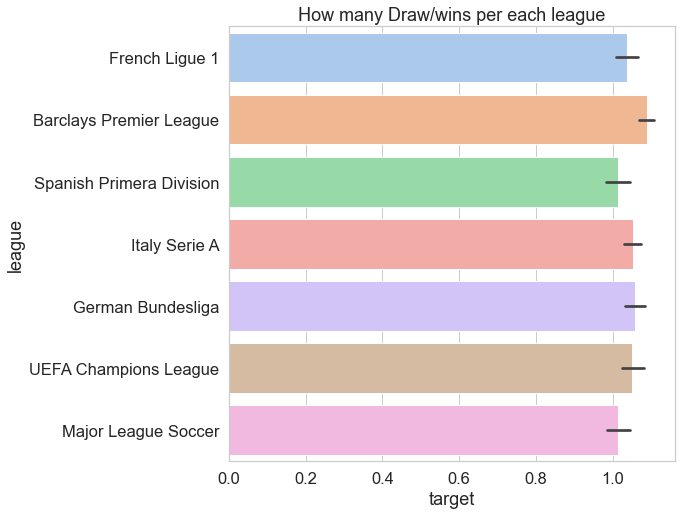

In [32]:
#plot a bargraph using the leagues to see how many times there is a draws/win
plt.figure(figsize=(8,8))
ax=sns.barplot(data = soccer_final_df,x ='target',y ='league',palette = 'pastel')
plt.title("How many Draw/wins per each league")
plt.show()

Looking at the above chart, it shows that most of the leagues win the game at home. We are going to look at the target again using the probability scores and probtie columns but before then we are going to drop the league column and some other columns that will not be needed for the analysis.

In [33]:
#drop more columns due to alot of nan values 
soccer_df = soccer_final_df.drop(['league','B365_Home','B365_Draw','B365A_way'],axis =1)
soccer_df = soccer_df.dropna().reset_index(drop=True)
soccer_df.head(10)

,season,team1,team2,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,target
0,2016,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,32.4,67.7,0.0,1.0,0.97,0.63,2
1,2016,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.0,2.0,2.45,0.77,0
2,2016,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,2.0,1.0,0.85,2.77,1
3,2016,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,31.9,48.0,1.0,1.0,0.73,1.11,0
4,2016,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,43.6,34.6,0.0,1.0,1.11,0.68,2
5,2016,Middlesbrough,Stoke City,56.32,60.35,0.4380,0.2692,0.2927,33.9,32.5,1.0,1.0,1.40,0.55,0
6,2016,Burnley,Swansea City,58.98,59.74,0.4482,0.2663,0.2854,36.5,29.1,0.0,1.0,1.24,1.84,2
7,2016,Southampton,Watford,69.49,59.33,0.5759,0.1874,0.2367,34.1,30.7,1.0,1.0,1.05,0.22,0
8,2016,Bordeaux,St Etienne,62.01,64.92,0.4232,0.2764,0.3004,37.9,44.2,3.0,2.0,1.03,1.84,1
9,2016,Manchester City,Sunderland,86.42,53.64,0.8152,0.0525,0.1323,73.0,27.0,2.0,1.0,2.14,1.25,1


In [34]:
soccer_df.tail(10)

,season,team1,team2,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,target
11884,2021,Borussia Monchengladbach,SpVgg Greuther Fürth,73.99,54.36,0.6454,0.1410,0.2136,41.2,30.5,4.0,0.0,2.20,0.31,1
11885,2021,Watford,Manchester United,59.62,80.86,0.1957,0.5770,0.2273,46.8,47.2,4.0,1.0,2.99,1.72,1
11886,2021,Burnley,Crystal Palace,65.84,71.28,0.3898,0.3436,0.2666,37.4,14.6,3.0,3.0,1.37,1.87,0
11887,2021,Newcastle,Brentford,61.00,69.45,0.3583,0.3789,0.2628,47.5,24.5,3.0,3.0,2.51,1.11,0
11888,2021,Norwich City,Southampton,55.19,69.71,0.2865,0.4382,0.2753,36.1,22.1,2.0,1.0,0.53,1.09,1
11889,2021,Aston Villa,Brighton and Hove Albion,70.01,76.08,0.3729,0.3578,0.2692,27.7,21.6,2.0,0.0,1.05,0.35,1
11890,2021,Wolverhampton,West Ham United,71.28,78.51,0.2841,0.4536,0.2623,12.7,59.5,1.0,0.0,1.44,0.42,1
11891,2021,Sevilla FC,Alavés,78.84,62.97,0.6454,0.1172,0.2374,70.4,28.3,2.0,2.0,1.46,1.41,0
11892,2021,Paris Saint-Germain,Nantes,81.85,58.75,0.7338,0.1002,0.1660,44.3,16.8,3.0,1.0,1.62,1.25,1
11893,2021,Lazio,Juventus,69.88,78.62,0.2984,0.4584,0.2432,51.4,73.0,0.0,2.0,0.34,2.73,2


In [35]:
#combine the home and away team to make a single team
#to avoid data leakeage.
soccer_df['team'] = soccer_df['team1'].combine_first(soccer_df['team2'])
soccer_df.head(10)

,season,team1,team2,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,target,team
0,2016,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,32.4,67.7,0.0,1.0,0.97,0.63,2,Bastia
1,2016,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.0,2.0,2.45,0.77,0,AS Monaco
2,2016,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,2.0,1.0,0.85,2.77,1,Hull City
3,2016,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,31.9,48.0,1.0,1.0,0.73,1.11,0,Everton
4,2016,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,43.6,34.6,0.0,1.0,1.11,0.68,2,Crystal Palace
5,2016,Middlesbrough,Stoke City,56.32,60.35,0.4380,0.2692,0.2927,33.9,32.5,1.0,1.0,1.40,0.55,0,Middlesbrough
6,2016,Burnley,Swansea City,58.98,59.74,0.4482,0.2663,0.2854,36.5,29.1,0.0,1.0,1.24,1.84,2,Burnley
7,2016,Southampton,Watford,69.49,59.33,0.5759,0.1874,0.2367,34.1,30.7,1.0,1.0,1.05,0.22,0,Southampton
8,2016,Bordeaux,St Etienne,62.01,64.92,0.4232,0.2764,0.3004,37.9,44.2,3.0,2.0,1.03,1.84,1,Bordeaux
9,2016,Manchester City,Sunderland,86.42,53.64,0.8152,0.0525,0.1323,73.0,27.0,2.0,1.0,2.14,1.25,1,Manchester City


In [36]:
#drop the team1 and team2 column
soccer_df = soccer_df.drop(['team1','team2',],axis =1)
soccer_df = soccer_df.reset_index(drop=True)
soccer_df.head(10)

,season,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,target,team
0,2016,51.16,85.68,0.0463,0.8380,0.1157,32.4,67.7,0.0,1.0,0.97,0.63,2,Bastia
1,2016,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.0,2.0,2.45,0.77,0,AS Monaco
2,2016,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,2.0,1.0,0.85,2.77,1,Hull City
3,2016,68.02,73.25,0.3910,0.3401,0.2689,31.9,48.0,1.0,1.0,0.73,1.11,0,Everton
4,2016,55.19,58.66,0.4214,0.2939,0.2847,43.6,34.6,0.0,1.0,1.11,0.68,2,Crystal Palace
5,2016,56.32,60.35,0.4380,0.2692,0.2927,33.9,32.5,1.0,1.0,1.40,0.55,0,Middlesbrough
6,2016,58.98,59.74,0.4482,0.2663,0.2854,36.5,29.1,0.0,1.0,1.24,1.84,2,Burnley
7,2016,69.49,59.33,0.5759,0.1874,0.2367,34.1,30.7,1.0,1.0,1.05,0.22,0,Southampton
8,2016,62.01,64.92,0.4232,0.2764,0.3004,37.9,44.2,3.0,2.0,1.03,1.84,1,Bordeaux
9,2016,86.42,53.64,0.8152,0.0525,0.1323,73.0,27.0,2.0,1.0,2.14,1.25,1,Manchester City


In [37]:
soccer_df.shape

(11894, 14)

In [38]:
len(soccer_df['season'])

11894

In [39]:
group_df = soccer_df.groupby(['target'],as_index=False)['team'].count().sort_values('target',ascending=False)
group_df.reset_index(drop=True,inplace=True)
group_df

,target,team
0,2,3561
1,1,5421
2,0,2912


Out of 11894 season in the league that I decided to analyze, 5421 of the teams always win at home while 3561 win at the away matches and 2912 draw either at home matches or Away matches.

In [40]:
soccer_df.isnull().sum()

season         0
spi1           0
spi2           0
prob1          0
prob2          0
probtie        0
importance1    0
importance2    0
score1         0
score2         0
xg1            0
xg2            0
target         0
team           0
dtype: int64

Now that we have been able to pare down the dataset,we can go ahead and plot a 3d plot that will show the full-time results using the predicted probabilities of a soccer game.


0: Draw
1: Home Win
2: Away Win


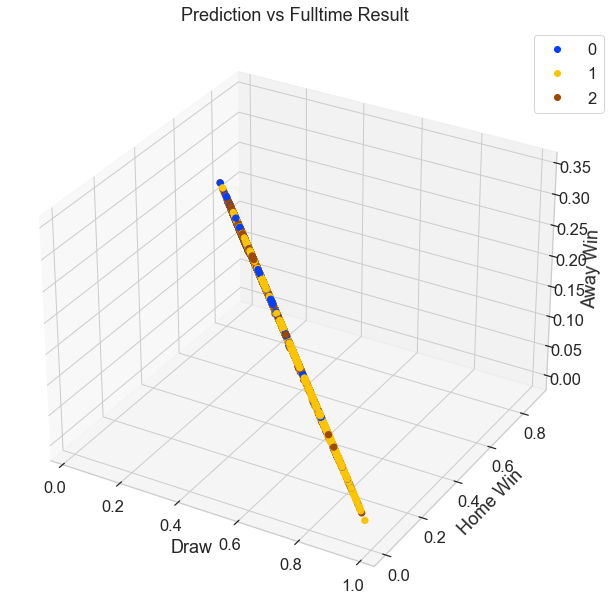

In [41]:
#plot the probabilities

# axes instance
df = soccer_df
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
fig.add_axes(ax)

x = df['prob1']
y = df['prob2']
z = df['probtie']

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("bright", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=df['target'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel("Draw")
ax.set_ylabel("Home Win")
ax.set_zlabel("Away Win")
ax.set_title("Prediction vs Fulltime Result")

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=1)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

#make the font bold 
bold_start = '\033[1m'


print(bold_start)
print('0: Draw')
print('1: Home Win')
print('2: Away Win')

Also, I will plot at the distribution of the features to see if it is normal or skewed.

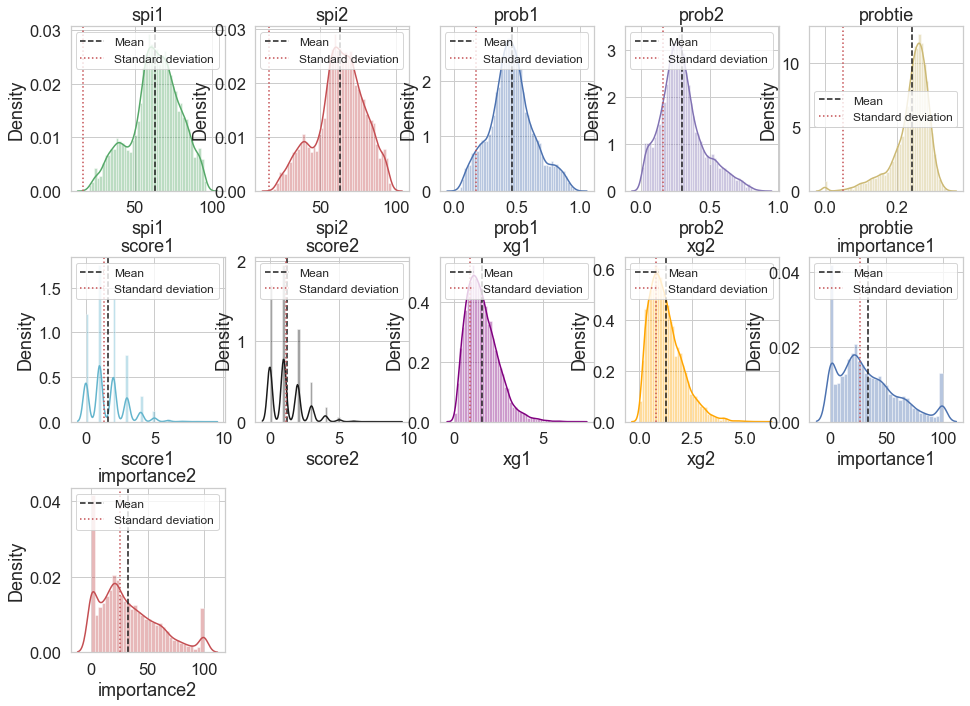

In [42]:
#plot distribution of all features
columns = ['spi1','spi2','prob1','prob2','probtie','score1','score2','xg1','xg2','importance1','importance2']
length = len(columns)
colors= ['g','r','b','m','y','c','k','purple','orange','b','r']

plt.figure(figsize=(16,20))
for i,j,k in itertools.zip_longest(columns,range(length),colors):
    plt.subplot(length/2,length/2, j+1)
    sns.distplot(soccer_df[i],color=k)
    plt.title(i)
    plt.subplots_adjust(hspace = .4)
    plt.axvline(soccer_df[i].mean(), color='k', linestyle='dashed',label='Mean')
    plt.axvline(soccer_df[i].std(), color='r', linestyle='dotted',label='Standard deviation')
    plt.legend(loc='best',prop={'size':12})

The SPIs and the Probs seems to follow almost a normal distribution, which is what we want actually. Now we are going to compare the features with the target using boxplots.

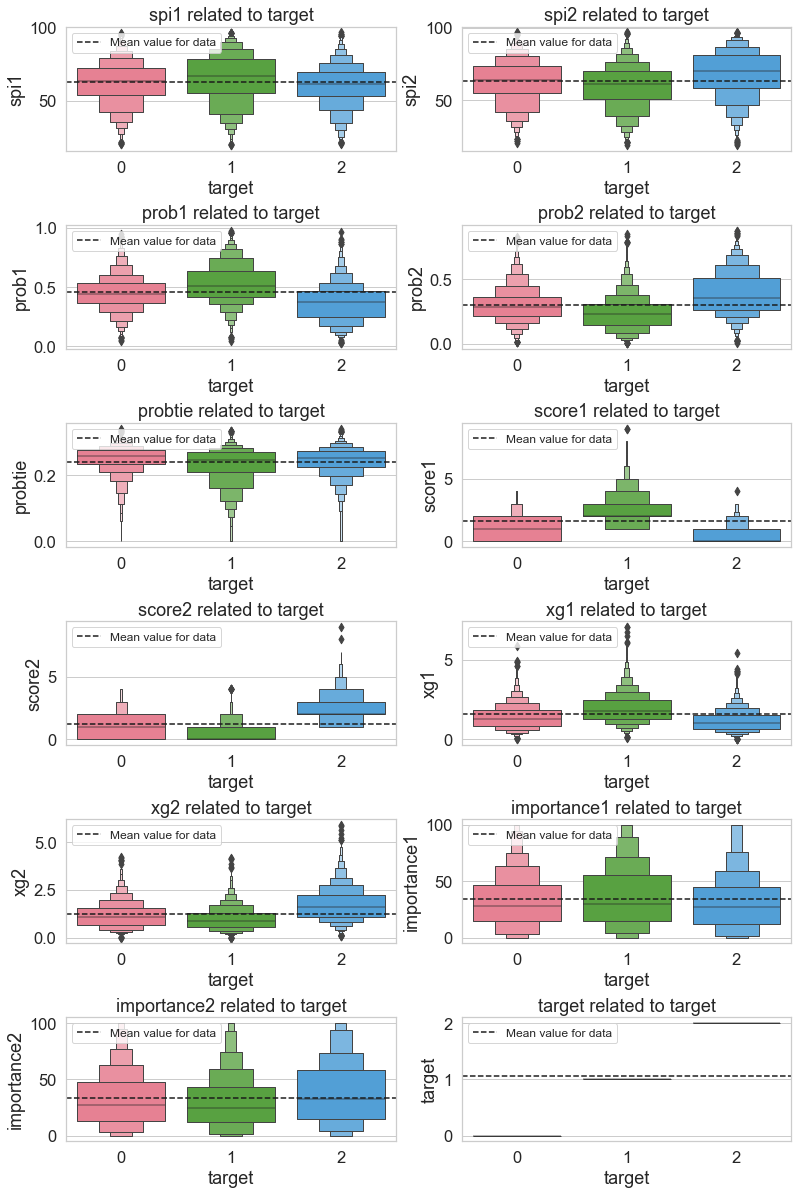

In [43]:
#visualize the target if it related to the correlated features
cols = ['spi1','spi2','prob1','prob2','probtie','score1','score2','xg1','xg2','importance1','importance2','target']

columns = [x for x in cols if x not in ['target_class']]
length = len(columns)

plt.figure(figsize=(13,18))
for i,j in itertools.zip_longest(columns,range(length)):
    plt.subplot(6,2,j+1)
    plt.subplots_adjust(bottom =1/50)
    sns.boxenplot(x=soccer_df['target'],y=soccer_df[i],palette = 'husl')
    plt.title(i + " related to target")
    plt.subplots_adjust(hspace = .6)
    plt.axhline(soccer_df[i].mean(), color='k', linestyle='dashed',label='Mean value for data')
    plt.legend(loc='upper left',prop={'size':12})

As you can see the EDA and visualization really tells us alot of information about the soccer dataset. Now I am going to use the features to build a predictive model that is going to prompt users for probability of the clubs winning the match either home or away.

In [41]:
#saving the club soccer data to csv
club_data.to_csv('club_data.csv')
#saving the final soccer data to csv
soccer_df.to_csv('soccer_df.csv')

## Modeling

My approach of modelling was using supervised Machine learning techniques to check the effectiveness of each performance metrics to analyze the dataset for accuracy. Although, different Machine learning models were considered for the project but I decide to use logistic Regression as my baseline model so that I can use it to compare the accuracy of the other models.

I also compare different models using the mean and standard deviation of the accuracy scores. The scores were lower than the baseline score especially the KNN algorithm. Then I went ahead using gridsearchCV to tune each model for a better result while minimizing the loss function.



In [44]:
#bring in the saved soccer data
soccer_df = pd.read_csv("../Data/soccer-spi/soccer_df.csv",index_col=0)
club_data = pd.read_csv("../Data/soccer-spi/club_data.csv",index_col=0)

In [45]:
soccer_df.head(10)

,season,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,target,team
1,2016,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2,2,2.45,0.77,0,ASMonaco
2,2016,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,2,1,0.85,2.77,1,Hull City
3,2016,68.02,73.25,0.3910,0.3401,0.2689,31.9,48.0,1,1,0.73,1.11,0,Everton
4,2016,55.19,58.66,0.4214,0.2939,0.2847,43.6,34.6,0,1,1.11,0.68,2,Crystal Palace
5,2016,56.32,60.35,0.4380,0.2692,0.2927,33.9,32.5,1,1,1.40,0.55,0,Middlesbrough
6,2016,58.98,59.74,0.4482,0.2663,0.2854,36.5,29.1,0,1,1.24,1.84,2,Burnley
7,2016,69.49,59.33,0.5759,0.1874,0.2367,34.1,30.7,1,1,1.05,0.22,0,Southampton
8,2016,62.01,64.92,0.4232,0.2764,0.3004,37.9,44.2,3,2,1.03,1.84,1,Bordeaux
9,2016,86.42,53.64,0.8152,0.0525,0.1323,73.0,27.0,2,1,2.14,1.25,1,Manchester City
10,2016,55.00,54.90,0.4471,0.2490,0.3038,29.2,25.6,0,1,0.30,1.17,2,DijonFCO


In [46]:
soccer_df.tail(10)

,season,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,target,team
11884,2021,73.99,54.36,0.6454,0.1410,0.2136,41.2,30.5,4,0,2.20,0.31,1,Borussia Monchengladbach
11885,2021,59.62,80.86,0.1957,0.5770,0.2273,46.8,47.2,4,1,2.99,1.72,1,Watford
11886,2021,65.84,71.28,0.3898,0.3436,0.2666,37.4,14.6,3,3,1.37,1.87,0,Burnley
11887,2021,61.00,69.45,0.3583,0.3789,0.2628,47.5,24.5,3,3,2.51,1.11,0,Newcastle
11888,2021,55.19,69.71,0.2865,0.4382,0.2753,36.1,22.1,2,1,0.53,1.09,1,Norwich City
11889,2021,70.01,76.08,0.3729,0.3578,0.2692,27.7,21.6,2,0,1.05,0.35,1,Aston Villa
11890,2021,71.28,78.51,0.2841,0.4536,0.2623,12.7,59.5,1,0,1.44,0.42,1,Wolverhampton
11891,2021,78.84,62.97,0.6454,0.1172,0.2374,70.4,28.3,2,2,1.46,1.41,0,Sevilla FC
11892,2021,81.85,58.75,0.7338,0.1002,0.1660,44.3,16.8,3,1,1.62,1.25,1,Paris Saint-Germain
11893,2021,69.88,78.62,0.2984,0.4584,0.2432,51.4,73.0,0,2,0.34,2.73,2,Lazio


In [47]:
club_data.head(10)

,rank,prev_rank,name,league,off,def,spi
0,1,1,Bayern Munich,German Bundesliga,3.64,0.51,93.72
1,2,2,Manchester City,Barclays Premier League,2.97,0.24,93.57
2,3,3,Liverpool,Barclays Premier League,3.06,0.46,91.04
3,4,4,Chelsea,Barclays Premier League,2.47,0.24,90.32
5,6,6,Real Madrid,Spanish Primera Division,2.57,0.62,84.21
6,7,8,Internazionale,Italy Serie A,2.59,0.66,83.64
7,8,9,Atletico Madrid,Spanish Primera Division,2.29,0.51,83.19
8,9,10,Barcelona,Spanish Primera Division,2.44,0.62,82.68
9,10,7,RB Leipzig,German Bundesliga,2.53,0.70,82.23
10,11,11,Paris Saint-Germain,French Ligue 1,2.52,0.75,81.16


In [48]:
soccer_df.shape , club_data.shape

((11891, 14), (128, 7))

In [49]:
#check the data info
soccer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11891 entries, 1 to 11893
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       11891 non-null  int64  
 1   spi1         11891 non-null  float64
 2   spi2         11891 non-null  float64
 3   prob1        11891 non-null  float64
 4   prob2        11891 non-null  float64
 5   probtie      11891 non-null  float64
 6   importance1  11891 non-null  float64
 7   importance2  11891 non-null  float64
 8   score1       11891 non-null  int64  
 9   score2       11891 non-null  int64  
 10  xg1          11891 non-null  float64
 11  xg2          11891 non-null  float64
 12  target       11891 non-null  int64  
 13  team         11891 non-null  object 
dtypes: float64(9), int64(4), object(1)
memory usage: 1.4+ MB


In [50]:
#let's drop the team and the score columns to avoid data leakeage
soccer_final= soccer_df.drop(['team','score1','score2'],axis =1)
soccer_final.head(10)

,season,spi1,spi2,prob1,prob2,probtie,importance1,importance2,xg1,xg2,target
1,2016,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.45,0.77,0
2,2016,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,0.85,2.77,1
3,2016,68.02,73.25,0.3910,0.3401,0.2689,31.9,48.0,0.73,1.11,0
4,2016,55.19,58.66,0.4214,0.2939,0.2847,43.6,34.6,1.11,0.68,2
5,2016,56.32,60.35,0.4380,0.2692,0.2927,33.9,32.5,1.40,0.55,0
6,2016,58.98,59.74,0.4482,0.2663,0.2854,36.5,29.1,1.24,1.84,2
7,2016,69.49,59.33,0.5759,0.1874,0.2367,34.1,30.7,1.05,0.22,0
8,2016,62.01,64.92,0.4232,0.2764,0.3004,37.9,44.2,1.03,1.84,1
9,2016,86.42,53.64,0.8152,0.0525,0.1323,73.0,27.0,2.14,1.25,1
10,2016,55.00,54.90,0.4471,0.2490,0.3038,29.2,25.6,0.30,1.17,2


In [51]:
#final data description
soccer_final.describe()

,season,spi1,spi2,prob1,prob2,probtie,importance1,importance2,xg1,xg2,target
count,11891.000000,11891.000000,11891.000000,11891.000000,11891.000000,11891.000000,11891.000000,11891.000000,11891.000000,11891.000000,11891.000000
mean,2018.384913,63.116417,63.007739,0.460752,0.298360,0.240889,33.798335,33.025187,1.568274,1.247697,1.054495
std,1.546782,15.961851,16.047286,0.174582,0.158342,0.050349,26.304146,25.988058,0.885074,0.780664,0.735767
min,2016.000000,19.990000,19.290000,0.027000,0.003700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017.000000,54.370000,54.210000,0.353750,0.195400,0.222600,14.000000,13.300000,0.910000,0.670000,1.000000
50%,2018.000000,63.970000,63.920000,0.453400,0.277100,0.252000,28.500000,27.500000,1.430000,1.100000,1.000000
75%,2020.000000,74.270000,74.160000,0.559250,0.374150,0.273400,49.100000,49.000000,2.080000,1.670000,2.000000
max,2021.000000,96.570000,96.690000,0.977500,0.881600,0.342300,100.000000,100.000000,7.070000,5.900000,2.000000


In [98]:
#Define X and y
X = soccer_final.drop('target', axis =1)
y = soccer_final['target']

#holdout set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15,random_state=42)

#training and test set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.20,random_state=42)

In [99]:
y.value_counts(normalize=True)

1    0.455723
2    0.299386
0    0.244891
Name: target, dtype: float64

In [183]:
#normalize the features
scaler = MinMaxScaler()
scaled = scaler.fit(X_train)

X_train_scaled = scaled.transform(X_train)
X_test_scaled = scaled.transform(X_test)
X_val_scaled = scaled.transform(X_val)

In [184]:
X_train_scaled.shape, X_test_scaled.shape , X_val.shape

((8085, 10), (2022, 10), (1784, 10))

In [185]:
y_train.shape , y_test.shape , y_val.shape

((8085,), (2022,), (1784,))

let's bring in a function that will assist with evaluating the models.

In [103]:
#define a function to evaluate the algorithms
#define a function to evaluate the algorithms
def evaluate_model(estimator,X_train,X_test,y_train,y_test):
    """
    An evaluation function that shows the classification report 
    and log_loss for the training and the test scores.
    input: 
    Algorithm - the model best output estimator
    X_train - the training features, either scaled or unscaled
    X_test - the testing features
    y_train- the training target variable
    y_test - the testing target variable

    """

    #predictions
    train_pred = estimator.predict(X_train)
    test_pred  = estimator.predict(X_test)
    
    #Roc_auc
    train_prob = estimator.predict_proba(X_train)
    test_prob = estimator.predict_proba(X_test)
    
    #print the Training scores
    print("Training Scores:")    
    print(f"Accuracy Score: {accuracy_score(y_train,train_pred)}")
    print("----")
    print(f"Log loss Score: {log_loss(y_train, train_prob)}")
    print("----")
    print(classification_report(y_train,train_pred))
    
    
    print("------------")

    
    #print Test scores  
    print("Test Scores:") 
    print(f"Accuracy Score: {accuracy_score(y_test,test_pred)}")
    print("----")
    print(f"Log loss Score: {log_loss(y_test,test_prob)}")
    print("----")
    print(classification_report(y_test,test_pred))

    
    #plot Confusion matrix
    plt.figure(figsize=(14,12))
    plt.subplot(221)
    ax=sns.heatmap(confusion_matrix(y_test,test_pred,normalize='true'),
                   annot=True,linecolor='k',linewidth=2,
                   cmap =sns.color_palette('Blues'))
    ax.xaxis.set_ticklabels(['Draw','HomeWin','AwayWin'],fontsize=15)
    ax.yaxis.set_ticklabels(['Draw','HomeWin','AwayWin'],fontsize=15)
    plt.title("Confusion Matrix",fontsize=22)
    plt.xlabel("predicted Value")
    plt.ylabel("Actual Value")  

### Baseline Understanding

I will be building a baseline model to compare with the other models using the accuracy score. The goal is to improve the score and at the end predict on unseen data to beat the bookmaker's odds.

In [104]:
scoring ='accuracy','f1_weighted'

In [105]:
#instantiate the Decision Tree classifier
baseline_model = DecisionTreeClassifier()
baseline_model.fit(X_train_scaled,y_train)

DecisionTreeClassifier()

In [106]:
cross_validate(baseline_model,X_train_scaled, y_train,scoring=scoring)

{'fit_time': array([0.05565691, 0.05588484, 0.05638885, 0.05533504, 0.05585694]),
 'score_time': array([0.00196981, 0.00302696, 0.00204206, 0.00174689, 0.00182605]),
 'test_accuracy': array([0.47309833, 0.46505875, 0.48608534, 0.44403216, 0.47062461]),
 'test_f1_weighted': array([0.47435775, 0.46928081, 0.48570045, 0.44453429, 0.47062601])}

Training Scores:
Accuracy Score: 1.0
----
Log loss Score: 2.1094237467877998e-15
----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1979
           1       1.00      1.00      1.00      3712
           2       1.00      1.00      1.00      2394

    accuracy                           1.00      8085
   macro avg       1.00      1.00      1.00      8085
weighted avg       1.00      1.00      1.00      8085

------------
Test Scores:
Accuracy Score: 0.486646884272997
----
Log loss Score: 17.73058847572566
----
              precision    recall  f1-score   support

           0       0.27      0.27      0.27       474
           1       0.58      0.61      0.60       912
           2       0.51      0.47      0.49       636

    accuracy                           0.49      2022
   macro avg       0.45      0.45      0.45      2022
weighted avg       0.49      0.49      0.49      2022



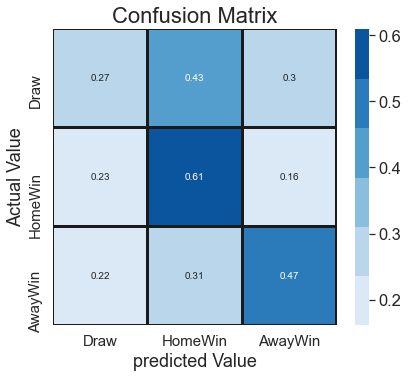

In [107]:
evaluate_model(baseline_model, X_train_scaled, X_test_scaled, y_train, y_test)

The baseline model was overfitting on the training data, while able to predict an accuracy score of 48% on the test set with a probability of loss at -18.0. With this information, I will go ahead and build more models in order to compare the results with the baseline model.

### First Models without parameters

Here, I will build different types of model without a parameter then compare it against the baseline model. The results will help to decide how to tune each model for better score.

In [108]:
#prepare models
models =[]
models.append(('knn model',KNeighborsClassifier()))
models.append(('Logistic model',LogisticRegression()))
models.append(('Random forest',RandomForestClassifier()))
models.append(('Naive Bayes',GaussianNB()))
models.append(('xgboost',XGBClassifier()))
models.append(('SVC model',SVC()))

#evaluate each models
results=[]
names=[]
df=[]

target=['draw','HomeWin','AwayWin']
for name, model in models:
    Kfold = KFold(n_splits=2, random_state=200, shuffle=True)
    cv_results = cross_validate(model,X_train_scaled, y_train,cv=5,scoring=scoring)
    model_fit = model.fit(X_train_scaled,y_train)
    pred = model_fit.predict(X_test_scaled)
    print(name)
    print(classification_report(y_test,pred,target_names=target))
    
    #append results
    results.append(cv_results)
    names.append(name)
    
    #put results in dataframe
    data = pd.DataFrame(cv_results)
    data['model']=name
    df.append(data)
    
    final = pd.concat(df,ignore_index=True)
    print(final)

knn model
              precision    recall  f1-score   support

        draw       0.27      0.28      0.27       474
     HomeWin       0.60      0.69      0.64       912
     AwayWin       0.59      0.43      0.50       636

    accuracy                           0.51      2022
   macro avg       0.48      0.47      0.47      2022
weighted avg       0.52      0.51      0.51      2022

   fit_time  score_time  test_accuracy  test_f1_weighted      model
0  0.004948    0.084143       0.506494          0.502412  knn model
1  0.004712    0.084095       0.483612          0.483327  knn model
2  0.004610    0.078067       0.495362          0.491401  knn model
3  0.004445    0.076256       0.490414          0.487111  knn model
4  0.004440    0.079172       0.512678          0.507262  knn model
Logistic model
              precision    recall  f1-score   support

        draw       0.40      0.04      0.08       474
     HomeWin       0.61      0.86      0.71       912
     AwayWin       0.61

Firstly, we create a variable dataframe to hold all of the datasets that will be created from the application of 5-fold cross validation on the training set. Next, models in a list of tuples holding the name and class for each classifier to be tested. After this, we loop through this list and run 5-fold cross validation. The results of each run are recorded in a pandas dataframe which we append to the dataframe list. One must note that the metrics recorded here are weighted mean metrics across both classes. The SVC Model and LR model seems to be performing better than other models with a score of 59% even though it is yet to be hypertune. While the KNN model seems to be performing less but better than the baseline. With this information I will go ahead to tune each model using gridsearchCV and then predict the scores on both train and test set.

To better obtain the estimate of the distribution of metrics of each model I run a bootstrap of 30 samples and sort according to performance metrics and fit-time metrics

In [109]:
#obtain bootstrap of metrics and fit-time metrics
num_samples= []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    sample= model_df.sample(n=30, replace=True)
    num_samples.append(sample)
        
sample_df = pd.concat(num_samples, ignore_index=True)
results_df= pd.melt(sample_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
# performance metrics
results_nofit = results_df.loc[~results_df['metrics'].isin(time_metrics)] 
# get df without fit data
results_nofit = results_nofit.sort_values(by='values')
# time metrics
results_fit = results_df.loc[results_df['metrics'].isin(time_metrics)] 
# df with fit data
results_fit = results_fit.sort_values(by='values')

Now I am going to visualize the models by it's  performance metrics 

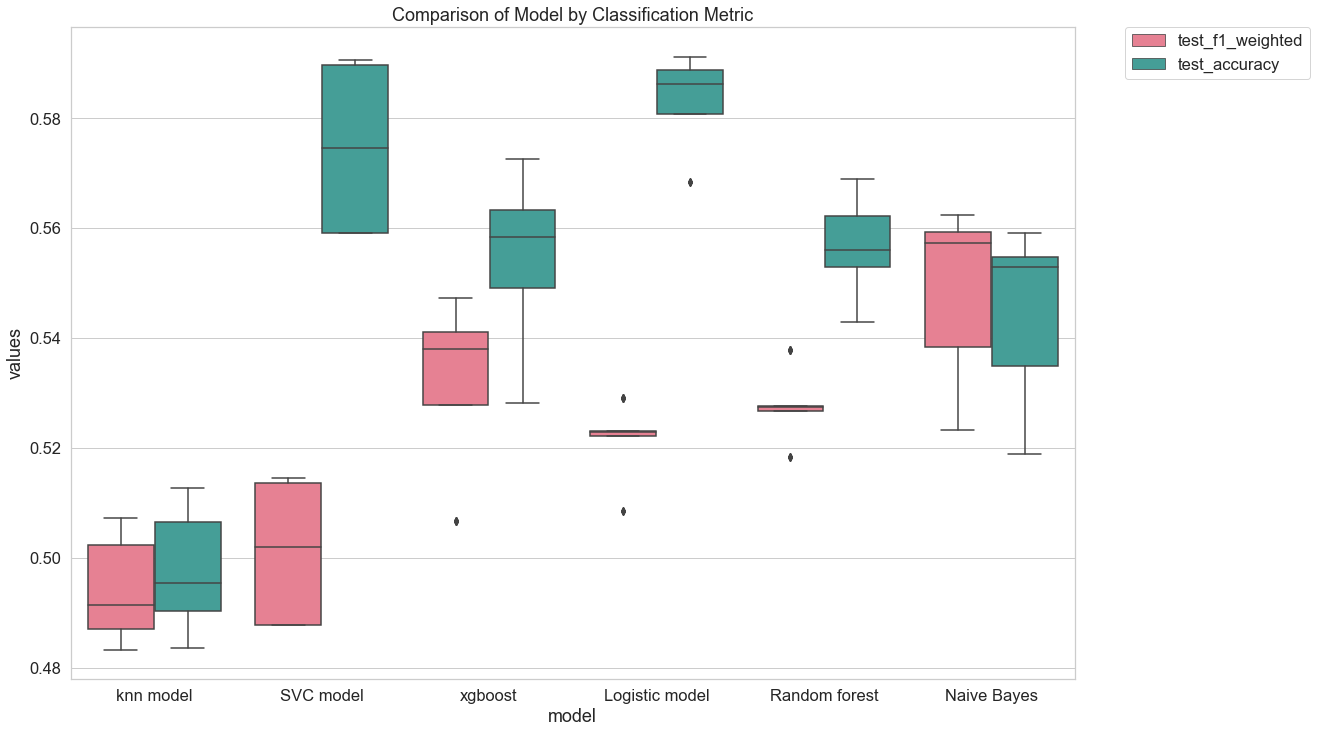

In [110]:
#plot a boxplot to compare the models
fig=plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111)
ax=sns.boxplot(x="model", y="values", hue="metrics", data=results_nofit, palette="husl")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.show()

Looking at the boxplot it is clear that the SVC seems to perform well on the test data.

### Modeling Iterations using Pipeline and GridsearchCV .

Now I will go ahead and iterate through each model with different parameters and see if the models will perform better on unseen data.

- ####  Logistic Regression model with GridsearchCV

In [111]:
#instantiate a pipeline with the steps
lg_model = Pipeline(steps=[('classifier', LogisticRegression(multi_class="multinomial"))])
lg_model

Pipeline(steps=[('classifier', LogisticRegression(multi_class='multinomial'))])

In [112]:
#use the gini and entropy as the criterion
#use the max_depth
#use best splitter
param = [{ 
    'classifier__penalty':['l2', 'elasticnet'],
    'classifier__C':[1.5,1.0,2.0,5.0,6.0],
    'classifier__solver': ['newton-cg', 'lbfgs','sag', 'saga','liblinear']}]

grid = GridSearchCV(estimator= lg_model,
                    param_grid = param, scoring='accuracy',cv =5)

In [113]:
#fit the grid on the training dataset
output = grid.fit(X_train_scaled, y_train)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,param_classifier__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.142159,6.266412e-03,0.000536,0.000026,1.5,l2,newton-cg,"{'classifier__C': 1.5, 'classifier__penalty': ...",0.590600,0.582560,0.579468,0.568336,0.590600,0.582313,0.008256,17
1,0.155076,5.297545e-03,0.000602,0.000129,1.5,l2,lbfgs,"{'classifier__C': 1.5, 'classifier__penalty': ...",0.589981,0.582560,0.578850,0.568336,0.590600,0.582066,0.008180,20
2,0.060834,4.149324e-03,0.000444,0.000006,1.5,l2,sag,"{'classifier__C': 1.5, 'classifier__penalty': ...",0.590600,0.583179,0.579468,0.568336,0.590600,0.582437,0.008264,13
3,0.101779,3.018951e-03,0.000475,0.000036,1.5,l2,saga,"{'classifier__C': 1.5, 'classifier__penalty': ...",0.590600,0.582560,0.579468,0.568336,0.590600,0.582313,0.008256,17
4,0.000831,2.669922e-05,0.000000,0.000000,1.5,l2,liblinear,"{'classifier__C': 1.5, 'classifier__penalty': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,33
5,0.000463,2.498481e-05,0.000000,0.000000,1.5,elasticnet,newton-cg,"{'classifier__C': 1.5, 'classifier__penalty': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,34
6,0.000437,1.715289e-06,0.000000,0.000000,1.5,elasticnet,lbfgs,"{'classifier__C': 1.5, 'classifier__penalty': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,35
7,0.000445,1.821530e-05,0.000000,0.000000,1.5,elasticnet,sag,"{'classifier__C': 1.5, 'classifier__penalty': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
8,0.000437,2.207916e-06,0.000000,0.000000,1.5,elasticnet,saga,"{'classifier__C': 1.5, 'classifier__penalty': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,37
9,0.000434,2.284841e-06,0.000000,0.000000,1.5,elasticnet,liblinear,"{'classifier__C': 1.5, 'classifier__penalty': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,38


In [114]:
#check the best parameter
output.best_params_

{'classifier__C': 5.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'newton-cg'}

In [115]:
#check the best score for the parameter
output.best_score_

0.5829313543599259

Training Scores:
Accuracy Score: 0.5841682127396413
----
Log loss Score: 0.8889645901774733
----
              precision    recall  f1-score   support

           0       0.40      0.06      0.11      1979
           1       0.60      0.84      0.70      3712
           2       0.57      0.62      0.60      2394

    accuracy                           0.58      8085
   macro avg       0.52      0.51      0.47      8085
weighted avg       0.54      0.58      0.52      8085

------------
Test Scores:
Accuracy Score: 0.6008902077151336
----
Log loss Score: 0.8812832230137887
----
              precision    recall  f1-score   support

           0       0.36      0.04      0.08       474
           1       0.61      0.86      0.71       912
           2       0.60      0.65      0.63       636

    accuracy                           0.60      2022
   macro avg       0.52      0.52      0.47      2022
weighted avg       0.55      0.60      0.54      2022



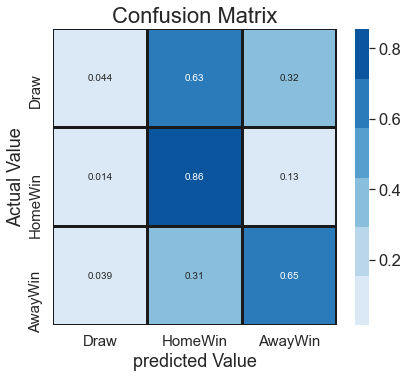

In [116]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_, X_train_scaled, X_test_scaled, y_train, y_test)

After tunning the Logistic model using penalty, C and different solvers the model was able to perform better than the baseline model with an accuracy score of 60%. Even though the recall is high for the Homewin, the probability of loss is stil at -0.9 .

- #### Random Forest model with GridsearchCV

In [136]:
#instantiate a pipeline with the steps
Random_forest = Pipeline(steps=[('classifier', RandomForestClassifier())])
Random_forest

Pipeline(steps=[('classifier', RandomForestClassifier())])

In [137]:
param = [{
    'classifier__criterion':['gini','entropy'],
    'classifier__max_features':['sqrt','log2'],
    'classifier__class_weight':["balanced_subsample"],
    'classifier__max_depth': [5,10,50,100],
    'classifier__min_samples_split':[10,20,100,]}]

grid = GridSearchCV(estimator= Random_forest,
                    param_grid = param, scoring='accuracy',cv=5)

In [138]:
#fit the grid on the training dataset
output = grid.fit(X_train_scaled, y_train)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__class_weight,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.706549,0.004878,0.018166,0.000184,balanced_subsample,gini,5,sqrt,10,{'classifier__class_weight': 'balanced_subsamp...,0.572047,0.543599,0.552257,0.541744,0.550402,0.552010,0.010773,43
1,0.704027,0.001522,0.018123,0.000116,balanced_subsample,gini,5,sqrt,20,{'classifier__class_weight': 'balanced_subsamp...,0.565863,0.538033,0.549784,0.546073,0.554731,0.550897,0.009259,45
2,0.698547,0.001886,0.018100,0.000109,balanced_subsample,gini,5,sqrt,100,{'classifier__class_weight': 'balanced_subsamp...,0.569573,0.536178,0.548547,0.537415,0.550402,0.548423,0.012020,47
3,0.704922,0.002649,0.018266,0.000330,balanced_subsample,gini,5,log2,10,{'classifier__class_weight': 'balanced_subsamp...,0.571429,0.541126,0.546073,0.544218,0.549165,0.550402,0.010832,46
4,0.703455,0.001319,0.018115,0.000146,balanced_subsample,gini,5,log2,20,{'classifier__class_weight': 'balanced_subsamp...,0.567100,0.540507,0.553494,0.546691,0.550402,0.551639,0.008859,44
5,0.701855,0.002276,0.018130,0.000098,balanced_subsample,gini,5,log2,100,{'classifier__class_weight': 'balanced_subsamp...,0.562152,0.541126,0.549165,0.543599,0.546073,0.548423,0.007363,47
6,1.062915,0.002269,0.024125,0.000148,balanced_subsample,gini,10,sqrt,10,{'classifier__class_weight': 'balanced_subsamp...,0.572047,0.560297,0.561534,0.554731,0.555349,0.560792,0.006226,5
7,1.040238,0.003399,0.023327,0.000094,balanced_subsample,gini,10,sqrt,20,{'classifier__class_weight': 'balanced_subsamp...,0.569573,0.557205,0.547928,0.553494,0.553494,0.556339,0.007250,30
8,0.920847,0.005605,0.021085,0.000076,balanced_subsample,gini,10,sqrt,100,{'classifier__class_weight': 'balanced_subsamp...,0.569573,0.552876,0.557205,0.549784,0.554113,0.556710,0.006858,25
9,1.064969,0.002076,0.024028,0.000155,balanced_subsample,gini,10,log2,10,{'classifier__class_weight': 'balanced_subsamp...,0.565244,0.550402,0.547310,0.554731,0.559678,0.555473,0.006420,34


In [139]:
output.best_params_

{'classifier__class_weight': 'balanced_subsample',
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 100,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_split': 10}

In [140]:
#check the best score for the parameter
output.best_score_

0.562152133580705

Training Scores:
Accuracy Score: 0.9529993815708101
----
Log loss Score: 0.46158700107210837
----
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1979
           1       0.96      0.94      0.95      3712
           2       0.92      0.96      0.94      2394

    accuracy                           0.95      8085
   macro avg       0.95      0.95      0.95      8085
weighted avg       0.95      0.95      0.95      8085

------------
Test Scores:
Accuracy Score: 0.576162215628091
----
Log loss Score: 0.9127718815947071
----
              precision    recall  f1-score   support

           0       0.35      0.23      0.27       474
           1       0.64      0.71      0.68       912
           2       0.58      0.64      0.61       636

    accuracy                           0.58      2022
   macro avg       0.52      0.53      0.52      2022
weighted avg       0.55      0.58      0.56      2022



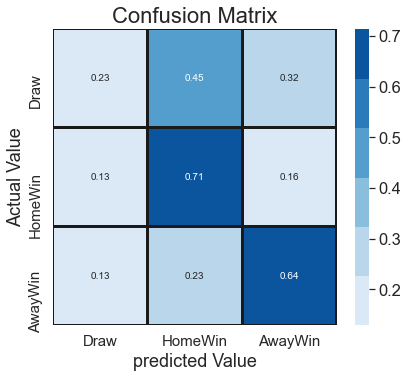

In [141]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_,X_train_scaled,X_test_scaled,y_train,y_test)

There is a 2% slight change in the accuracy score for the Random forest model, but still better than the baseline single decision tree.

- #### XGBoost model using the gridsearchCV

In [142]:
#instantiate a pipeline with the steps
xgb_model= Pipeline(steps=[('pca',PCA()),
                           ('classifier', XGBClassifier(objective='multi:softmax'))])
xgb_model

Pipeline(steps=[('pca', PCA()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softmax', random_state=None,
                               reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method=None, validate_parameters=None,
                 

In [143]:
#set the parameters
param = [{
    'pca__n_components':[5,10],
    'classifier__gamma':[0.5,0.1],
    'classifier__max_depth': [10,20,50],
    'classifier__n_estimators':[20,60,100]}]

grid = GridSearchCV(estimator = xgb_model,
                    param_grid = param, scoring='accuracy',cv=5)

In [144]:
#fit the grid on the training dataset
output = grid.fit(X_train_scaled, y_train)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__gamma,param_classifier__max_depth,param_classifier__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.237544,0.011874,0.003032,0.000054,0.5,10,20,5,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.523191,0.509586,0.505875,0.481756,0.517625,0.507607,0.014272,20
1,0.379589,0.018938,0.003605,0.000418,0.5,10,20,10,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.562771,0.565863,0.558442,0.533704,0.565863,0.557328,0.012121,1
2,0.583988,0.004962,0.006378,0.001312,0.5,10,60,5,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.504020,0.492888,0.505875,0.471861,0.507730,0.496475,0.013347,22
3,0.993680,0.024617,0.007244,0.001936,0.5,10,60,10,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.557823,0.559060,0.554113,0.528757,0.559678,0.551886,0.011725,5
4,0.941031,0.015725,0.007472,0.000365,0.5,10,100,5,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.499691,0.499691,0.498454,0.470625,0.505875,0.494867,0.012396,24
5,1.659380,0.048497,0.007937,0.000622,0.5,10,100,10,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.559060,0.561534,0.552257,0.531231,0.557823,0.552381,0.011003,4
6,0.451677,0.012352,0.004484,0.000164,0.5,20,20,5,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.498454,0.482993,0.507730,0.468769,0.495980,0.490785,0.013552,27
7,0.681627,0.004078,0.004631,0.000045,0.5,20,20,10,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.547928,0.549784,0.548547,0.532468,0.554731,0.546691,0.007503,12
8,1.219277,0.008683,0.007466,0.000482,0.5,20,60,5,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.488559,0.485467,0.506494,0.463203,0.490414,0.486827,0.013875,33
9,2.021236,0.027068,0.007175,0.000605,0.5,20,60,10,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.546073,0.549784,0.540507,0.531231,0.553494,0.544218,0.007783,16


In [146]:
output.best_params_

{'classifier__gamma': 0.5,
 'classifier__max_depth': 10,
 'classifier__n_estimators': 20,
 'pca__n_components': 10}

In [147]:
#check the best score for the parameter
output.best_score_

0.5573283858998146

Training Scores:
Accuracy Score: 0.9521335807050093
----
Log loss Score: 0.37619527098328226
----
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1979
           1       0.93      0.99      0.96      3712
           2       0.96      0.95      0.96      2394

    accuracy                           0.95      8085
   macro avg       0.96      0.94      0.95      8085
weighted avg       0.95      0.95      0.95      8085

------------
Test Scores:
Accuracy Score: 0.5731948565776459
----
Log loss Score: 0.9352934806576343
----
              precision    recall  f1-score   support

           0       0.36      0.16      0.22       474
           1       0.60      0.78      0.68       912
           2       0.59      0.58      0.59       636

    accuracy                           0.57      2022
   macro avg       0.52      0.51      0.50      2022
weighted avg       0.54      0.57      0.54      2022



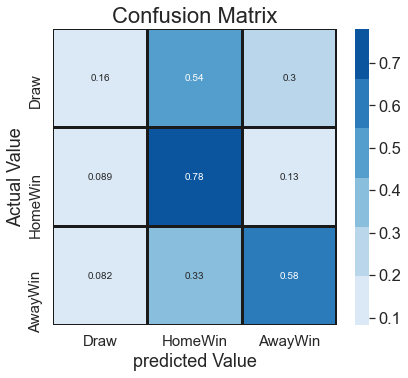

In [148]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_,X_train_scaled,X_test_scaled,y_train,y_test)

After tuning the XGBoost model, it was over fitting on the training data but when tested on unseen data, the accuracy score drop to 57% with a probability of loss at -0.9

- #### KNN model using the gridsearchCV

In [118]:
#instantiate the pipeline with the steps
knn_model = Pipeline(steps=[('classifier', KNeighborsClassifier())])
knn_model

Pipeline(steps=[('classifier', KNeighborsClassifier())])

In [119]:
#set the n_neighbors
#set the metric to euclidean and minkowski
param = [{
    'classifier__leaf_size':[5,10,20,40,60],
    'classifier__n_neighbors': [3,5,10,20,50,],
    'classifier__weights':['uniform','distance'],
    'classifier__metric':['euclidean','minkowski','manhattan']}]

grid = GridSearchCV(estimator = knn_model,
                    param_grid = param,scoring='accuracy',cv=5)

In [120]:
#fit the grid on the training dataset
output = grid.fit(X_train_scaled, y_train)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__leaf_size,param_classifier__metric,param_classifier__n_neighbors,param_classifier__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006103,0.000360,0.101951,0.005646,5,euclidean,3,uniform,"{'classifier__leaf_size': 5, 'classifier__metr...",0.495980,0.452690,0.493506,0.474954,0.509586,0.485343,0.019706,136
1,0.005729,0.000072,0.064435,0.002199,5,euclidean,3,distance,"{'classifier__leaf_size': 5, 'classifier__metr...",0.502165,0.474335,0.490414,0.489796,0.518244,0.494991,0.014606,121
2,0.005896,0.000198,0.113425,0.001294,5,euclidean,5,uniform,"{'classifier__leaf_size': 5, 'classifier__metr...",0.506494,0.483612,0.495362,0.490414,0.512678,0.497712,0.010571,106
3,0.005807,0.000064,0.078386,0.002539,5,euclidean,5,distance,"{'classifier__leaf_size': 5, 'classifier__metr...",0.522573,0.491651,0.499072,0.516388,0.518244,0.509586,0.012017,91
4,0.005876,0.000159,0.136435,0.002648,5,euclidean,10,uniform,"{'classifier__leaf_size': 5, 'classifier__metr...",0.545455,0.502783,0.534323,0.536797,0.556586,0.535189,0.017982,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.006428,0.003649,0.116056,0.022384,60,manhattan,10,distance,"{'classifier__leaf_size': 60, 'classifier__met...",0.549165,0.511441,0.512678,0.529375,0.541126,0.528757,0.015022,81
146,0.005112,0.000550,0.183600,0.014462,60,manhattan,20,uniform,"{'classifier__leaf_size': 60, 'classifier__met...",0.562771,0.526283,0.538033,0.540507,0.555968,0.544712,0.013074,56
147,0.005037,0.000444,0.117181,0.006303,60,manhattan,20,distance,"{'classifier__leaf_size': 60, 'classifier__met...",0.560297,0.529375,0.541126,0.547928,0.561534,0.548052,0.012071,51
148,0.004906,0.000363,0.195633,0.014441,60,manhattan,50,uniform,"{'classifier__leaf_size': 60, 'classifier__met...",0.565244,0.555349,0.557205,0.541126,0.572665,0.558318,0.010578,26


In [121]:
#check the best parameter from the models
output.best_params_

{'classifier__leaf_size': 5,
 'classifier__metric': 'euclidean',
 'classifier__n_neighbors': 50,
 'classifier__weights': 'uniform'}

In [122]:
#check the best score for the best parameter
output.best_score_

0.5638837353123068

Training Scores:
Accuracy Score: 0.5851576994434138
----
Log loss Score: 0.8942307941207521
----
              precision    recall  f1-score   support

           0       0.44      0.12      0.19      1979
           1       0.59      0.85      0.70      3712
           2       0.60      0.56      0.58      2394

    accuracy                           0.59      8085
   macro avg       0.54      0.51      0.49      8085
weighted avg       0.56      0.59      0.54      8085

------------
Test Scores:
Accuracy Score: 0.5791295746785361
----
Log loss Score: 0.9162315204373364
----
              precision    recall  f1-score   support

           0       0.33      0.09      0.14       474
           1       0.59      0.85      0.69       912
           2       0.62      0.56      0.59       636

    accuracy                           0.58      2022
   macro avg       0.51      0.50      0.47      2022
weighted avg       0.54      0.58      0.53      2022



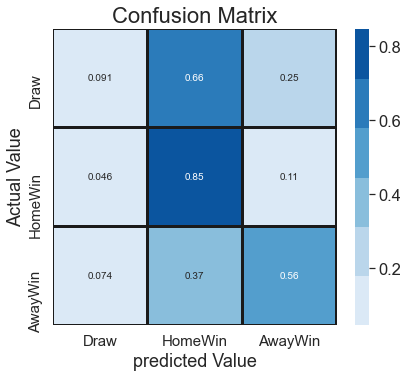

In [123]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_,X_train_scaled,X_test_scaled,y_train,y_test)

KNN increase with 6% after hyper tuning it.

- #### Naive Bayes model using the gridsearchCV

In [124]:
#instantiate the pipeline with the steps
naive_bayes = Pipeline(steps=[('classifier', GaussianNB())])
naive_bayes

Pipeline(steps=[('classifier', GaussianNB())])

In [125]:
param = [{
    'classifier__var_smoothing':[2e-9,2e-10,2e-5,2e-20,1e-10,1e-9,2e-8,2e-1]}]

grid = GridSearchCV(estimator =naive_bayes,
                    param_grid = param, scoring='accuracy',cv=5)

In [126]:
#fit the grid on the training dataset
output = grid.fit(X_train_scaled, y_train)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002324,0.000175,0.000903,0.000026,2e-09,{'classifier__var_smoothing': 2e-09},0.559060,0.518862,0.554731,0.534941,0.552876,0.544094,0.015064,3
1,0.002363,0.000149,0.000903,0.000025,2e-10,{'classifier__var_smoothing': 2e-10},0.559060,0.518862,0.554731,0.534941,0.552876,0.544094,0.015064,3
2,0.002231,0.000062,0.000890,0.000008,2e-05,{'classifier__var_smoothing': 2e-05},0.559060,0.518862,0.554731,0.535560,0.552876,0.544218,0.014991,2
3,0.002349,0.000225,0.000977,0.000187,2e-20,{'classifier__var_smoothing': 2e-20},0.559060,0.518862,0.554731,0.534941,0.552876,0.544094,0.015064,3
4,0.002790,0.000364,0.000939,0.000030,1e-10,{'classifier__var_smoothing': 1e-10},0.559060,0.518862,0.554731,0.534941,0.552876,0.544094,0.015064,3
5,0.002398,0.000299,0.000912,0.000083,1e-09,{'classifier__var_smoothing': 1e-09},0.559060,0.518862,0.554731,0.534941,0.552876,0.544094,0.015064,3
6,0.002422,0.000348,0.000883,0.000014,2e-08,{'classifier__var_smoothing': 2e-08},0.559060,0.518862,0.554731,0.534941,0.552876,0.544094,0.015064,3
7,0.002244,0.000161,0.000921,0.000108,0.2,{'classifier__var_smoothing': 0.2},0.557823,0.528139,0.559678,0.538652,0.560915,0.549041,0.013237,1


In [127]:
#check the best parameter from the models
output.best_params_

{'classifier__var_smoothing': 0.2}

In [128]:
#check the best score for the best parameter
output.best_score_

0.5490414347557204

Training Scores:
Accuracy Score: 0.5481756338899196
----
Log loss Score: 0.9761756417807783
----
              precision    recall  f1-score   support

           0       0.33      0.26      0.29      1979
           1       0.63      0.72      0.67      3712
           2       0.55      0.53      0.54      2394

    accuracy                           0.55      8085
   macro avg       0.50      0.50      0.50      8085
weighted avg       0.53      0.55      0.54      8085

------------
Test Scores:
Accuracy Score: 0.5741839762611276
----
Log loss Score: 0.9569325216360846
----
              precision    recall  f1-score   support

           0       0.34      0.26      0.30       474
           1       0.64      0.74      0.68       912
           2       0.61      0.56      0.59       636

    accuracy                           0.57      2022
   macro avg       0.53      0.52      0.52      2022
weighted avg       0.56      0.57      0.56      2022



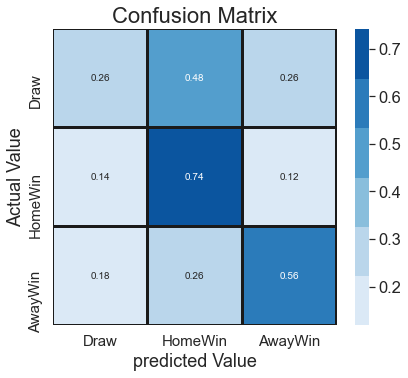

In [129]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_,X_train_scaled,X_test_scaled,y_train,y_test)

Naive bayes model also increase with 1% after tuning it with a probability of loss still at -0.9 . 

- #### Support Vector Machine(SVC) model using the gridsearchCV

In [130]:
#instantiate the pipeline with the steps
svc= Pipeline(steps=[('classifier', SVC(decision_function_shape='ovo',probability=True))])
svc

Pipeline(steps=[('classifier',
                 SVC(decision_function_shape='ovo', probability=True))])

In [131]:
param = [{
    'classifier__C':[0.5,0.2,1.0,1.5,2.0,5.0],
    'classifier__gamma':['auto']}]

grid = GridSearchCV(estimator = svc,
                    param_grid = param, scoring='accuracy',cv=5)

In [132]:
#fit the grid on the training dataset
output = grid.fit(X_train_scaled, y_train)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.759967,0.058667,0.154200,0.002645,0.5,auto,"{'classifier__C': 0.5, 'classifier__gamma': 'a...",0.594929,0.572047,0.568336,0.561534,0.591218,0.577613,0.013119,5
1,6.894263,0.049237,0.158403,0.000832,0.2,auto,"{'classifier__C': 0.2, 'classifier__gamma': 'a...",0.577613,0.567718,0.567718,0.551639,0.579468,0.568831,0.009882,6
2,6.614446,0.076446,0.153322,0.003924,1,auto,"{'classifier__C': 1.0, 'classifier__gamma': 'a...",0.599258,0.576994,0.573284,0.562152,0.594310,0.581200,0.013720,1
3,6.620695,0.038199,0.148924,0.000923,1.5,auto,"{'classifier__C': 1.5, 'classifier__gamma': 'a...",0.597403,0.577613,0.573284,0.561534,0.591218,0.580210,0.012809,4
4,6.531283,0.051746,0.148804,0.002118,2,auto,"{'classifier__C': 2.0, 'classifier__gamma': 'a...",0.596166,0.577613,0.576994,0.562152,0.589981,0.580581,0.011769,3
5,6.692991,0.179231,0.151557,0.004690,5,auto,"{'classifier__C': 5.0, 'classifier__gamma': 'a...",0.594310,0.578850,0.577613,0.562152,0.591218,0.580829,0.011426,2


In [133]:
#check the best parameter from the models
output.best_params_

{'classifier__C': 1.0, 'classifier__gamma': 'auto'}

In [134]:
#check the best score for the best parameter
output.best_score_

0.581199752628324

Training Scores:
Accuracy Score: 0.5825602968460112
----
Log loss Score: 0.9032089595668754
----
              precision    recall  f1-score   support

           0       0.46      0.02      0.04      1979
           1       0.58      0.87      0.70      3712
           2       0.59      0.60      0.59      2394

    accuracy                           0.58      8085
   macro avg       0.54      0.50      0.44      8085
weighted avg       0.55      0.58      0.51      8085

------------
Test Scores:
Accuracy Score: 0.5909990108803165
----
Log loss Score: 0.8893182939863091
----
              precision    recall  f1-score   support

           0       0.29      0.01      0.03       474
           1       0.58      0.88      0.70       912
           2       0.62      0.61      0.61       636

    accuracy                           0.59      2022
   macro avg       0.50      0.50      0.45      2022
weighted avg       0.53      0.59      0.52      2022



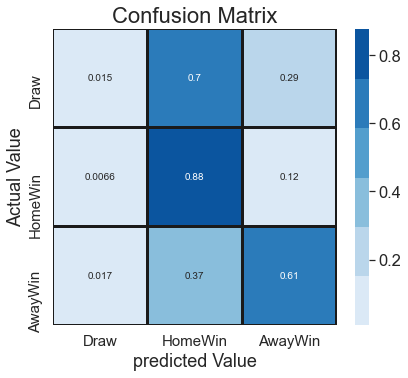

In [135]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_,X_train_scaled,X_test_scaled,y_train,y_test)

The SVC model performed better on unseen data with an accuracy of 59% and a probability of loss at -0.9 . With the tuning we are able to achieve a 1% change in the score.

- #### CatBoost model using the gridsearchCV

In [149]:
#instantiate the pipeline with the steps
cat_boost = Pipeline(steps=[('classifier', CatBoostClassifier(loss_function='MultiClass',classes_count=3))])
cat_boost

Pipeline(steps=[('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7fdd8450f580>)])

In [151]:
#set the parameters
param = [{
    'classifier__depth':[10,20],
    'classifier__border_count':[100,128],
    'classifier__l2_leaf_reg': [5,8],
    'classifier__leaf_estimation_method':['Newton'],
    'classifier__eval_metric':['Accuracy'],
    'classifier__iterations':[800]}]


grid = GridSearchCV(estimator = cat_boost,
                    param_grid = param, scoring='accuracy',cv=5)

In [152]:
#fit the grid on the training dataset
output = grid.fit(X_train_scaled, y_train)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

0:	learn: 0.5994125	total: 86.3ms	remaining: 1m 8s
1:	learn: 0.6080705	total: 113ms	remaining: 45.2s
2:	learn: 0.6040507	total: 141ms	remaining: 37.4s
3:	learn: 0.6117811	total: 168ms	remaining: 33.4s
4:	learn: 0.6158009	total: 196ms	remaining: 31.1s
5:	learn: 0.6153370	total: 223ms	remaining: 29.5s
6:	learn: 0.6173469	total: 249ms	remaining: 28.3s
7:	learn: 0.6148732	total: 277ms	remaining: 27.4s
8:	learn: 0.6154917	total: 306ms	remaining: 26.9s
9:	learn: 0.6187384	total: 343ms	remaining: 27.1s
10:	learn: 0.6171923	total: 372ms	remaining: 26.7s
11:	learn: 0.6184292	total: 400ms	remaining: 26.3s
12:	learn: 0.6202845	total: 428ms	remaining: 25.9s
13:	learn: 0.6207483	total: 456ms	remaining: 25.6s
14:	learn: 0.6202845	total: 484ms	remaining: 25.3s
15:	learn: 0.6173469	total: 514ms	remaining: 25.2s
16:	learn: 0.6176562	total: 553ms	remaining: 25.5s
17:	learn: 0.6175015	total: 589ms	remaining: 25.6s
18:	learn: 0.6158009	total: 627ms	remaining: 25.8s
19:	learn: 0.6170377	total: 669ms	remain

168:	learn: 0.6810451	total: 4.89s	remaining: 18.2s
169:	learn: 0.6808905	total: 4.92s	remaining: 18.2s
170:	learn: 0.6818182	total: 4.95s	remaining: 18.2s
171:	learn: 0.6818182	total: 4.97s	remaining: 18.2s
172:	learn: 0.6829004	total: 5s	remaining: 18.1s
173:	learn: 0.6839827	total: 5.03s	remaining: 18.1s
174:	learn: 0.6842919	total: 5.05s	remaining: 18s
175:	learn: 0.6853741	total: 5.08s	remaining: 18s
176:	learn: 0.6863018	total: 5.11s	remaining: 18s
177:	learn: 0.6867656	total: 5.14s	remaining: 18s
178:	learn: 0.6872294	total: 5.17s	remaining: 17.9s
179:	learn: 0.6876933	total: 5.19s	remaining: 17.9s
180:	learn: 0.6883117	total: 5.22s	remaining: 17.9s
181:	learn: 0.6880025	total: 5.25s	remaining: 17.8s
182:	learn: 0.6887755	total: 5.28s	remaining: 17.8s
183:	learn: 0.6897032	total: 5.3s	remaining: 17.7s
184:	learn: 0.6895485	total: 5.33s	remaining: 17.7s
185:	learn: 0.6906308	total: 5.36s	remaining: 17.7s
186:	learn: 0.6912492	total: 5.38s	remaining: 17.7s
187:	learn: 0.6914038	to

328:	learn: 0.7589672	total: 10s	remaining: 14.4s
329:	learn: 0.7591218	total: 10.1s	remaining: 14.3s
330:	learn: 0.7597403	total: 10.1s	remaining: 14.3s
331:	learn: 0.7598949	total: 10.1s	remaining: 14.3s
332:	learn: 0.7605133	total: 10.2s	remaining: 14.3s
333:	learn: 0.7600495	total: 10.2s	remaining: 14.2s
334:	learn: 0.7608225	total: 10.2s	remaining: 14.2s
335:	learn: 0.7611317	total: 10.3s	remaining: 14.2s
336:	learn: 0.7620594	total: 10.3s	remaining: 14.2s
337:	learn: 0.7614409	total: 10.4s	remaining: 14.2s
338:	learn: 0.7634508	total: 10.4s	remaining: 14.2s
339:	learn: 0.7634508	total: 10.4s	remaining: 14.1s
340:	learn: 0.7637600	total: 10.5s	remaining: 14.1s
341:	learn: 0.7639147	total: 10.5s	remaining: 14.1s
342:	learn: 0.7640693	total: 10.6s	remaining: 14.1s
343:	learn: 0.7653061	total: 10.6s	remaining: 14s
344:	learn: 0.7651515	total: 10.6s	remaining: 14s
345:	learn: 0.7648423	total: 10.6s	remaining: 14s
346:	learn: 0.7649969	total: 10.7s	remaining: 13.9s
347:	learn: 0.766697

491:	learn: 0.8214286	total: 14.7s	remaining: 9.21s
492:	learn: 0.8217378	total: 14.7s	remaining: 9.18s
493:	learn: 0.8212740	total: 14.8s	remaining: 9.15s
494:	learn: 0.8220470	total: 14.8s	remaining: 9.12s
495:	learn: 0.8218924	total: 14.8s	remaining: 9.08s
496:	learn: 0.8215832	total: 14.8s	remaining: 9.05s
497:	learn: 0.8226654	total: 14.9s	remaining: 9.02s
498:	learn: 0.8242115	total: 14.9s	remaining: 8.99s
499:	learn: 0.8251391	total: 14.9s	remaining: 8.96s
500:	learn: 0.8246753	total: 15s	remaining: 8.93s
501:	learn: 0.8248299	total: 15s	remaining: 8.9s
502:	learn: 0.8254484	total: 15s	remaining: 8.87s
503:	learn: 0.8254484	total: 15s	remaining: 8.84s
504:	learn: 0.8254484	total: 15.1s	remaining: 8.8s
505:	learn: 0.8257576	total: 15.1s	remaining: 8.77s
506:	learn: 0.8263760	total: 15.1s	remaining: 8.74s
507:	learn: 0.8263760	total: 15.2s	remaining: 8.71s
508:	learn: 0.8269944	total: 15.2s	remaining: 8.68s
509:	learn: 0.8274583	total: 15.2s	remaining: 8.65s
510:	learn: 0.8277675	

651:	learn: 0.8675015	total: 19.1s	remaining: 4.34s
652:	learn: 0.8679654	total: 19.2s	remaining: 4.31s
653:	learn: 0.8684292	total: 19.2s	remaining: 4.28s
654:	learn: 0.8684292	total: 19.2s	remaining: 4.25s
655:	learn: 0.8688930	total: 19.2s	remaining: 4.22s
656:	learn: 0.8696660	total: 19.3s	remaining: 4.19s
657:	learn: 0.8702845	total: 19.3s	remaining: 4.16s
658:	learn: 0.8704391	total: 19.3s	remaining: 4.13s
659:	learn: 0.8705937	total: 19.4s	remaining: 4.1s
660:	learn: 0.8704391	total: 19.4s	remaining: 4.08s
661:	learn: 0.8704391	total: 19.4s	remaining: 4.04s
662:	learn: 0.8712121	total: 19.4s	remaining: 4.01s
663:	learn: 0.8715213	total: 19.5s	remaining: 3.99s
664:	learn: 0.8715213	total: 19.5s	remaining: 3.96s
665:	learn: 0.8718306	total: 19.5s	remaining: 3.93s
666:	learn: 0.8719852	total: 19.5s	remaining: 3.9s
667:	learn: 0.8722944	total: 19.6s	remaining: 3.87s
668:	learn: 0.8721398	total: 19.6s	remaining: 3.84s
669:	learn: 0.8724490	total: 19.6s	remaining: 3.81s
670:	learn: 0.

16:	learn: 0.6192022	total: 473ms	remaining: 21.8s
17:	learn: 0.6205937	total: 501ms	remaining: 21.8s
18:	learn: 0.6210575	total: 528ms	remaining: 21.7s
19:	learn: 0.6226036	total: 555ms	remaining: 21.6s
20:	learn: 0.6213667	total: 582ms	remaining: 21.6s
21:	learn: 0.6212121	total: 610ms	remaining: 21.6s
22:	learn: 0.6216759	total: 637ms	remaining: 21.5s
23:	learn: 0.6226036	total: 664ms	remaining: 21.5s
24:	learn: 0.6229128	total: 693ms	remaining: 21.5s
25:	learn: 0.6252319	total: 721ms	remaining: 21.4s
26:	learn: 0.6264688	total: 748ms	remaining: 21.4s
27:	learn: 0.6278602	total: 775ms	remaining: 21.4s
28:	learn: 0.6278602	total: 802ms	remaining: 21.3s
29:	learn: 0.6286333	total: 829ms	remaining: 21.3s
30:	learn: 0.6286333	total: 857ms	remaining: 21.2s
31:	learn: 0.6277056	total: 884ms	remaining: 21.2s
32:	learn: 0.6289425	total: 912ms	remaining: 21.2s
33:	learn: 0.6292517	total: 940ms	remaining: 21.2s
34:	learn: 0.6289425	total: 968ms	remaining: 21.1s
35:	learn: 0.6314162	total: 995

181:	learn: 0.6999072	total: 5.12s	remaining: 17.4s
182:	learn: 0.7005257	total: 5.14s	remaining: 17.3s
183:	learn: 0.7003711	total: 5.17s	remaining: 17.3s
184:	learn: 0.7008349	total: 5.2s	remaining: 17.3s
185:	learn: 0.7022263	total: 5.23s	remaining: 17.3s
186:	learn: 0.7026902	total: 5.25s	remaining: 17.2s
187:	learn: 0.7023810	total: 5.28s	remaining: 17.2s
188:	learn: 0.7034632	total: 5.31s	remaining: 17.2s
189:	learn: 0.7037724	total: 5.34s	remaining: 17.1s
190:	learn: 0.7036178	total: 5.37s	remaining: 17.1s
191:	learn: 0.7045455	total: 5.39s	remaining: 17.1s
192:	learn: 0.7042362	total: 5.42s	remaining: 17s
193:	learn: 0.7051639	total: 5.45s	remaining: 17s
194:	learn: 0.7057823	total: 5.47s	remaining: 17s
195:	learn: 0.7059369	total: 5.5s	remaining: 17s
196:	learn: 0.7070192	total: 5.53s	remaining: 16.9s
197:	learn: 0.7077922	total: 5.56s	remaining: 16.9s
198:	learn: 0.7085652	total: 5.59s	remaining: 16.9s
199:	learn: 0.7088745	total: 5.62s	remaining: 16.8s
200:	learn: 0.7094929	

341:	learn: 0.7682437	total: 9.53s	remaining: 12.8s
342:	learn: 0.7687075	total: 9.56s	remaining: 12.7s
343:	learn: 0.7679344	total: 9.59s	remaining: 12.7s
344:	learn: 0.7679344	total: 9.61s	remaining: 12.7s
345:	learn: 0.7687075	total: 9.64s	remaining: 12.7s
346:	learn: 0.7685529	total: 9.67s	remaining: 12.6s
347:	learn: 0.7694805	total: 9.7s	remaining: 12.6s
348:	learn: 0.7696351	total: 9.72s	remaining: 12.6s
349:	learn: 0.7699443	total: 9.75s	remaining: 12.5s
350:	learn: 0.7707174	total: 9.78s	remaining: 12.5s
351:	learn: 0.7708720	total: 9.81s	remaining: 12.5s
352:	learn: 0.7714904	total: 9.83s	remaining: 12.5s
353:	learn: 0.7721088	total: 9.86s	remaining: 12.4s
354:	learn: 0.7721088	total: 9.89s	remaining: 12.4s
355:	learn: 0.7724181	total: 9.92s	remaining: 12.4s
356:	learn: 0.7730365	total: 9.94s	remaining: 12.3s
357:	learn: 0.7742733	total: 9.97s	remaining: 12.3s
358:	learn: 0.7735003	total: 10s	remaining: 12.3s
359:	learn: 0.7741187	total: 10s	remaining: 12.3s
360:	learn: 0.774

501:	learn: 0.8252938	total: 14s	remaining: 8.29s
502:	learn: 0.8259122	total: 14s	remaining: 8.26s
503:	learn: 0.8262214	total: 14s	remaining: 8.23s
504:	learn: 0.8265306	total: 14s	remaining: 8.21s
505:	learn: 0.8271490	total: 14.1s	remaining: 8.18s
506:	learn: 0.8268398	total: 14.1s	remaining: 8.15s
507:	learn: 0.8273036	total: 14.1s	remaining: 8.12s
508:	learn: 0.8282313	total: 14.2s	remaining: 8.09s
509:	learn: 0.8285405	total: 14.2s	remaining: 8.07s
510:	learn: 0.8283859	total: 14.2s	remaining: 8.04s
511:	learn: 0.8288497	total: 14.2s	remaining: 8.01s
512:	learn: 0.8296228	total: 14.3s	remaining: 7.98s
513:	learn: 0.8299320	total: 14.3s	remaining: 7.96s
514:	learn: 0.8296228	total: 14.3s	remaining: 7.93s
515:	learn: 0.8299320	total: 14.4s	remaining: 7.9s
516:	learn: 0.8303958	total: 14.4s	remaining: 7.87s
517:	learn: 0.8310142	total: 14.4s	remaining: 7.85s
518:	learn: 0.8319419	total: 14.4s	remaining: 7.82s
519:	learn: 0.8319419	total: 14.5s	remaining: 7.79s
520:	learn: 0.8330241

661:	learn: 0.8709029	total: 18.4s	remaining: 3.84s
662:	learn: 0.8709029	total: 18.4s	remaining: 3.81s
663:	learn: 0.8715213	total: 18.5s	remaining: 3.78s
664:	learn: 0.8713667	total: 18.5s	remaining: 3.75s
665:	learn: 0.8718306	total: 18.5s	remaining: 3.73s
666:	learn: 0.8718306	total: 18.5s	remaining: 3.7s
667:	learn: 0.8719852	total: 18.6s	remaining: 3.67s
668:	learn: 0.8722944	total: 18.6s	remaining: 3.64s
669:	learn: 0.8726036	total: 18.6s	remaining: 3.61s
670:	learn: 0.8735312	total: 18.7s	remaining: 3.59s
671:	learn: 0.8741497	total: 18.7s	remaining: 3.56s
672:	learn: 0.8738404	total: 18.7s	remaining: 3.53s
673:	learn: 0.8738404	total: 18.7s	remaining: 3.5s
674:	learn: 0.8746135	total: 18.8s	remaining: 3.48s
675:	learn: 0.8747681	total: 18.8s	remaining: 3.45s
676:	learn: 0.8746135	total: 18.8s	remaining: 3.42s
677:	learn: 0.8752319	total: 18.9s	remaining: 3.39s
678:	learn: 0.8752319	total: 18.9s	remaining: 3.36s
679:	learn: 0.8752319	total: 18.9s	remaining: 3.34s
680:	learn: 0.

24:	learn: 0.6241497	total: 699ms	remaining: 21.7s
25:	learn: 0.6246135	total: 727ms	remaining: 21.6s
26:	learn: 0.6252319	total: 754ms	remaining: 21.6s
27:	learn: 0.6244589	total: 783ms	remaining: 21.6s
28:	learn: 0.6253865	total: 810ms	remaining: 21.5s
29:	learn: 0.6264688	total: 838ms	remaining: 21.5s
30:	learn: 0.6277056	total: 865ms	remaining: 21.5s
31:	learn: 0.6267780	total: 892ms	remaining: 21.4s
32:	learn: 0.6277056	total: 922ms	remaining: 21.4s
33:	learn: 0.6277056	total: 951ms	remaining: 21.4s
34:	learn: 0.6270872	total: 978ms	remaining: 21.4s
35:	learn: 0.6297155	total: 1s	remaining: 21.3s
36:	learn: 0.6307978	total: 1.03s	remaining: 21.3s
37:	learn: 0.6298701	total: 1.06s	remaining: 21.2s
38:	learn: 0.6304886	total: 1.09s	remaining: 21.2s
39:	learn: 0.6318800	total: 1.11s	remaining: 21.2s
40:	learn: 0.6324985	total: 1.14s	remaining: 21.2s
41:	learn: 0.6309524	total: 1.17s	remaining: 21.1s
42:	learn: 0.6320346	total: 1.2s	remaining: 21.1s
43:	learn: 0.6349722	total: 1.23s	r

184:	learn: 0.6961967	total: 5.13s	remaining: 17s
185:	learn: 0.6958874	total: 5.16s	remaining: 17s
186:	learn: 0.6971243	total: 5.18s	remaining: 17s
187:	learn: 0.6965059	total: 5.21s	remaining: 17s
188:	learn: 0.6968151	total: 5.24s	remaining: 16.9s
189:	learn: 0.6974335	total: 5.26s	remaining: 16.9s
190:	learn: 0.6974335	total: 5.29s	remaining: 16.9s
191:	learn: 0.6974335	total: 5.32s	remaining: 16.8s
192:	learn: 0.6972789	total: 5.35s	remaining: 16.8s
193:	learn: 0.6980519	total: 5.38s	remaining: 16.8s
194:	learn: 0.6985158	total: 5.41s	remaining: 16.8s
195:	learn: 0.6994434	total: 5.43s	remaining: 16.7s
196:	learn: 0.6999072	total: 5.46s	remaining: 16.7s
197:	learn: 0.6999072	total: 5.49s	remaining: 16.7s
198:	learn: 0.7017625	total: 5.51s	remaining: 16.7s
199:	learn: 0.7014533	total: 5.54s	remaining: 16.6s
200:	learn: 0.7022263	total: 5.57s	remaining: 16.6s
201:	learn: 0.7023810	total: 5.6s	remaining: 16.6s
202:	learn: 0.7029994	total: 5.63s	remaining: 16.5s
203:	learn: 0.7022263

344:	learn: 0.7611317	total: 9.57s	remaining: 12.6s
345:	learn: 0.7611317	total: 9.6s	remaining: 12.6s
346:	learn: 0.7617502	total: 9.62s	remaining: 12.6s
347:	learn: 0.7617502	total: 9.65s	remaining: 12.5s
348:	learn: 0.7628324	total: 9.68s	remaining: 12.5s
349:	learn: 0.7629870	total: 9.71s	remaining: 12.5s
350:	learn: 0.7639147	total: 9.73s	remaining: 12.4s
351:	learn: 0.7643785	total: 9.76s	remaining: 12.4s
352:	learn: 0.7654607	total: 9.79s	remaining: 12.4s
353:	learn: 0.7656153	total: 9.82s	remaining: 12.4s
354:	learn: 0.7662338	total: 9.85s	remaining: 12.3s
355:	learn: 0.7660792	total: 9.87s	remaining: 12.3s
356:	learn: 0.7663884	total: 9.9s	remaining: 12.3s
357:	learn: 0.7665430	total: 9.93s	remaining: 12.3s
358:	learn: 0.7670068	total: 9.96s	remaining: 12.2s
359:	learn: 0.7671614	total: 9.98s	remaining: 12.2s
360:	learn: 0.7674706	total: 10s	remaining: 12.2s
361:	learn: 0.7673160	total: 10s	remaining: 12.2s
362:	learn: 0.7674706	total: 10.1s	remaining: 12.1s
363:	learn: 0.7685

505:	learn: 0.8188002	total: 14.2s	remaining: 8.27s
506:	learn: 0.8195733	total: 14.3s	remaining: 8.24s
507:	learn: 0.8200371	total: 14.3s	remaining: 8.21s
508:	learn: 0.8206555	total: 14.3s	remaining: 8.18s
509:	learn: 0.8206555	total: 14.3s	remaining: 8.15s
510:	learn: 0.8212740	total: 14.4s	remaining: 8.13s
511:	learn: 0.8215832	total: 14.4s	remaining: 8.1s
512:	learn: 0.8209647	total: 14.4s	remaining: 8.07s
513:	learn: 0.8217378	total: 14.5s	remaining: 8.09s
514:	learn: 0.8214286	total: 14.6s	remaining: 8.06s
515:	learn: 0.8220470	total: 14.6s	remaining: 8.03s
516:	learn: 0.8226654	total: 14.6s	remaining: 8s
517:	learn: 0.8228200	total: 14.6s	remaining: 7.97s
518:	learn: 0.8234385	total: 14.7s	remaining: 7.95s
519:	learn: 0.8235931	total: 14.7s	remaining: 7.92s
520:	learn: 0.8243661	total: 14.7s	remaining: 7.89s
521:	learn: 0.8246753	total: 14.8s	remaining: 7.87s
522:	learn: 0.8246753	total: 14.8s	remaining: 7.84s
523:	learn: 0.8248299	total: 14.8s	remaining: 7.81s
524:	learn: 0.82

665:	learn: 0.8676562	total: 18.9s	remaining: 3.81s
666:	learn: 0.8678108	total: 19s	remaining: 3.78s
667:	learn: 0.8687384	total: 19s	remaining: 3.75s
668:	learn: 0.8679654	total: 19s	remaining: 3.73s
669:	learn: 0.8682746	total: 19.1s	remaining: 3.7s
670:	learn: 0.8684292	total: 19.1s	remaining: 3.67s
671:	learn: 0.8687384	total: 19.1s	remaining: 3.64s
672:	learn: 0.8685838	total: 19.1s	remaining: 3.61s
673:	learn: 0.8688930	total: 19.2s	remaining: 3.58s
674:	learn: 0.8685838	total: 19.2s	remaining: 3.56s
675:	learn: 0.8685838	total: 19.2s	remaining: 3.53s
676:	learn: 0.8687384	total: 19.3s	remaining: 3.5s
677:	learn: 0.8696660	total: 19.3s	remaining: 3.47s
678:	learn: 0.8701299	total: 19.3s	remaining: 3.44s
679:	learn: 0.8704391	total: 19.3s	remaining: 3.41s
680:	learn: 0.8702845	total: 19.4s	remaining: 3.38s
681:	learn: 0.8707483	total: 19.4s	remaining: 3.35s
682:	learn: 0.8713667	total: 19.4s	remaining: 3.33s
683:	learn: 0.8716759	total: 19.5s	remaining: 3.3s
684:	learn: 0.8716759

24:	learn: 0.6249227	total: 699ms	remaining: 21.7s
25:	learn: 0.6247681	total: 727ms	remaining: 21.6s
26:	learn: 0.6260049	total: 755ms	remaining: 21.6s
27:	learn: 0.6263142	total: 821ms	remaining: 22.6s
28:	learn: 0.6278602	total: 872ms	remaining: 23.2s
29:	learn: 0.6275510	total: 910ms	remaining: 23.4s
30:	learn: 0.6275510	total: 944ms	remaining: 23.4s
31:	learn: 0.6292517	total: 973ms	remaining: 23.3s
32:	learn: 0.6290971	total: 1s	remaining: 23.2s
33:	learn: 0.6292517	total: 1.03s	remaining: 23.2s
34:	learn: 0.6300247	total: 1.05s	remaining: 23.1s
35:	learn: 0.6309524	total: 1.08s	remaining: 23s
36:	learn: 0.6297155	total: 1.11s	remaining: 22.9s
37:	learn: 0.6315708	total: 1.14s	remaining: 22.8s
38:	learn: 0.6317254	total: 1.17s	remaining: 22.8s
39:	learn: 0.6311070	total: 1.19s	remaining: 22.7s
40:	learn: 0.6321892	total: 1.22s	remaining: 22.6s
41:	learn: 0.6329623	total: 1.25s	remaining: 22.5s
42:	learn: 0.6337353	total: 1.28s	remaining: 22.5s
43:	learn: 0.6345083	total: 1.3s	rem

186:	learn: 0.6971243	total: 5.39s	remaining: 17.7s
187:	learn: 0.6974335	total: 5.42s	remaining: 17.6s
188:	learn: 0.6977427	total: 5.44s	remaining: 17.6s
189:	learn: 0.6977427	total: 5.47s	remaining: 17.6s
190:	learn: 0.6982066	total: 5.5s	remaining: 17.5s
191:	learn: 0.6985158	total: 5.53s	remaining: 17.5s
192:	learn: 0.6989796	total: 5.55s	remaining: 17.5s
193:	learn: 0.6997526	total: 5.58s	remaining: 17.4s
194:	learn: 0.7012987	total: 5.61s	remaining: 17.4s
195:	learn: 0.7011441	total: 5.64s	remaining: 17.4s
196:	learn: 0.7009895	total: 5.67s	remaining: 17.3s
197:	learn: 0.7016079	total: 5.69s	remaining: 17.3s
198:	learn: 0.7011441	total: 5.72s	remaining: 17.3s
199:	learn: 0.7014533	total: 5.75s	remaining: 17.2s
200:	learn: 0.7020717	total: 5.78s	remaining: 17.2s
201:	learn: 0.7022263	total: 5.81s	remaining: 17.2s
202:	learn: 0.7025356	total: 5.84s	remaining: 17.2s
203:	learn: 0.7033086	total: 5.87s	remaining: 17.1s
204:	learn: 0.7034632	total: 5.89s	remaining: 17.1s
205:	learn: 0

346:	learn: 0.7629870	total: 9.89s	remaining: 12.9s
347:	learn: 0.7626778	total: 9.92s	remaining: 12.9s
348:	learn: 0.7634508	total: 9.94s	remaining: 12.8s
349:	learn: 0.7642239	total: 9.97s	remaining: 12.8s
350:	learn: 0.7648423	total: 10s	remaining: 12.8s
351:	learn: 0.7659246	total: 10s	remaining: 12.8s
352:	learn: 0.7663884	total: 10.1s	remaining: 12.7s
353:	learn: 0.7665430	total: 10.1s	remaining: 12.7s
354:	learn: 0.7673160	total: 10.1s	remaining: 12.7s
355:	learn: 0.7668522	total: 10.1s	remaining: 12.6s
356:	learn: 0.7676252	total: 10.2s	remaining: 12.6s
357:	learn: 0.7679344	total: 10.2s	remaining: 12.6s
358:	learn: 0.7680891	total: 10.2s	remaining: 12.6s
359:	learn: 0.7680891	total: 10.2s	remaining: 12.5s
360:	learn: 0.7682437	total: 10.3s	remaining: 12.5s
361:	learn: 0.7683983	total: 10.3s	remaining: 12.5s
362:	learn: 0.7690167	total: 10.3s	remaining: 12.4s
363:	learn: 0.7688621	total: 10.4s	remaining: 12.4s
364:	learn: 0.7694805	total: 10.4s	remaining: 12.4s
365:	learn: 0.77

506:	learn: 0.8215832	total: 14.4s	remaining: 8.31s
507:	learn: 0.8212740	total: 14.4s	remaining: 8.28s
508:	learn: 0.8222016	total: 14.5s	remaining: 8.28s
509:	learn: 0.8220470	total: 14.5s	remaining: 8.26s
510:	learn: 0.8228200	total: 14.6s	remaining: 8.23s
511:	learn: 0.8222016	total: 14.6s	remaining: 8.21s
512:	learn: 0.8223562	total: 14.6s	remaining: 8.18s
513:	learn: 0.8234385	total: 14.6s	remaining: 8.15s
514:	learn: 0.8239023	total: 14.7s	remaining: 8.12s
515:	learn: 0.8239023	total: 14.7s	remaining: 8.09s
516:	learn: 0.8245207	total: 14.7s	remaining: 8.06s
517:	learn: 0.8251391	total: 14.8s	remaining: 8.03s
518:	learn: 0.8252938	total: 14.8s	remaining: 8s
519:	learn: 0.8256030	total: 14.8s	remaining: 7.98s
520:	learn: 0.8257576	total: 14.8s	remaining: 7.95s
521:	learn: 0.8263760	total: 14.9s	remaining: 7.92s
522:	learn: 0.8265306	total: 14.9s	remaining: 7.89s
523:	learn: 0.8273036	total: 14.9s	remaining: 7.86s
524:	learn: 0.8273036	total: 15s	remaining: 7.83s
525:	learn: 0.827

668:	learn: 0.8684292	total: 19s	remaining: 3.73s
669:	learn: 0.8685838	total: 19.1s	remaining: 3.7s
670:	learn: 0.8695114	total: 19.1s	remaining: 3.67s
671:	learn: 0.8693568	total: 19.1s	remaining: 3.64s
672:	learn: 0.8698207	total: 19.2s	remaining: 3.62s
673:	learn: 0.8702845	total: 19.2s	remaining: 3.59s
674:	learn: 0.8710575	total: 19.2s	remaining: 3.56s
675:	learn: 0.8710575	total: 19.2s	remaining: 3.53s
676:	learn: 0.8712121	total: 19.3s	remaining: 3.5s
677:	learn: 0.8713667	total: 19.3s	remaining: 3.47s
678:	learn: 0.8713667	total: 19.3s	remaining: 3.44s
679:	learn: 0.8713667	total: 19.4s	remaining: 3.42s
680:	learn: 0.8712121	total: 19.4s	remaining: 3.39s
681:	learn: 0.8707483	total: 19.4s	remaining: 3.36s
682:	learn: 0.8713667	total: 19.4s	remaining: 3.33s
683:	learn: 0.8718306	total: 19.5s	remaining: 3.3s
684:	learn: 0.8719852	total: 19.5s	remaining: 3.27s
685:	learn: 0.8719852	total: 19.5s	remaining: 3.24s
686:	learn: 0.8722944	total: 19.6s	remaining: 3.22s
687:	learn: 0.871

32:	learn: 0.6290971	total: 918ms	remaining: 21.3s
33:	learn: 0.6300247	total: 947ms	remaining: 21.3s
34:	learn: 0.6297155	total: 975ms	remaining: 21.3s
35:	learn: 0.6301793	total: 1s	remaining: 21.3s
36:	learn: 0.6303340	total: 1.03s	remaining: 21.2s
37:	learn: 0.6307978	total: 1.06s	remaining: 21.2s
38:	learn: 0.6311070	total: 1.08s	remaining: 21.2s
39:	learn: 0.6304886	total: 1.11s	remaining: 21.2s
40:	learn: 0.6321892	total: 1.14s	remaining: 21.2s
41:	learn: 0.6329623	total: 1.17s	remaining: 21.2s
42:	learn: 0.6331169	total: 1.2s	remaining: 21.1s
43:	learn: 0.6340445	total: 1.23s	remaining: 21.1s
44:	learn: 0.6354360	total: 1.25s	remaining: 21s
45:	learn: 0.6346630	total: 1.28s	remaining: 21s
46:	learn: 0.6349722	total: 1.31s	remaining: 21s
47:	learn: 0.6357452	total: 1.34s	remaining: 21s
48:	learn: 0.6362090	total: 1.37s	remaining: 21s
49:	learn: 0.6369821	total: 1.4s	remaining: 21s
50:	learn: 0.6362090	total: 1.43s	remaining: 20.9s
51:	learn: 0.6371367	total: 1.45s	remaining: 20.

192:	learn: 0.7036178	total: 5.4s	remaining: 17s
193:	learn: 0.7056277	total: 5.42s	remaining: 16.9s
194:	learn: 0.7057823	total: 5.45s	remaining: 16.9s
195:	learn: 0.7059369	total: 5.48s	remaining: 16.9s
196:	learn: 0.7065553	total: 5.51s	remaining: 16.9s
197:	learn: 0.7070192	total: 5.54s	remaining: 16.8s
198:	learn: 0.7071738	total: 5.56s	remaining: 16.8s
199:	learn: 0.7068646	total: 5.59s	remaining: 16.8s
200:	learn: 0.7071738	total: 5.62s	remaining: 16.7s
201:	learn: 0.7081014	total: 5.65s	remaining: 16.7s
202:	learn: 0.7090291	total: 5.68s	remaining: 16.7s
203:	learn: 0.7091837	total: 5.7s	remaining: 16.7s
204:	learn: 0.7104205	total: 5.73s	remaining: 16.6s
205:	learn: 0.7105751	total: 5.76s	remaining: 16.6s
206:	learn: 0.7111936	total: 5.79s	remaining: 16.6s
207:	learn: 0.7113482	total: 5.81s	remaining: 16.5s
208:	learn: 0.7119666	total: 5.84s	remaining: 16.5s
209:	learn: 0.7122758	total: 5.87s	remaining: 16.5s
210:	learn: 0.7121212	total: 5.9s	remaining: 16.5s
211:	learn: 0.712

354:	learn: 0.7738095	total: 10.1s	remaining: 12.6s
355:	learn: 0.7731911	total: 10.1s	remaining: 12.6s
356:	learn: 0.7739641	total: 10.1s	remaining: 12.6s
357:	learn: 0.7741187	total: 10.1s	remaining: 12.5s
358:	learn: 0.7741187	total: 10.2s	remaining: 12.5s
359:	learn: 0.7752010	total: 10.2s	remaining: 12.5s
360:	learn: 0.7759740	total: 10.2s	remaining: 12.4s
361:	learn: 0.7758194	total: 10.3s	remaining: 12.4s
362:	learn: 0.7765925	total: 10.3s	remaining: 12.4s
363:	learn: 0.7767471	total: 10.3s	remaining: 12.4s
364:	learn: 0.7770563	total: 10.3s	remaining: 12.3s
365:	learn: 0.7776747	total: 10.4s	remaining: 12.3s
366:	learn: 0.7782931	total: 10.4s	remaining: 12.3s
367:	learn: 0.7787570	total: 10.4s	remaining: 12.2s
368:	learn: 0.7799938	total: 10.5s	remaining: 12.2s
369:	learn: 0.7801484	total: 10.5s	remaining: 12.2s
370:	learn: 0.7804576	total: 10.5s	remaining: 12.2s
371:	learn: 0.7799938	total: 10.5s	remaining: 12.1s
372:	learn: 0.7803030	total: 10.6s	remaining: 12.1s
373:	learn: 

518:	learn: 0.8305504	total: 14.8s	remaining: 7.99s
519:	learn: 0.8310142	total: 14.8s	remaining: 7.96s
520:	learn: 0.8314780	total: 14.8s	remaining: 7.93s
521:	learn: 0.8317873	total: 14.8s	remaining: 7.91s
522:	learn: 0.8324057	total: 14.9s	remaining: 7.88s
523:	learn: 0.8319419	total: 14.9s	remaining: 7.87s
524:	learn: 0.8328695	total: 15s	remaining: 7.86s
525:	learn: 0.8330241	total: 15s	remaining: 7.83s
526:	learn: 0.8330241	total: 15.1s	remaining: 7.8s
527:	learn: 0.8339518	total: 15.1s	remaining: 7.77s
528:	learn: 0.8342610	total: 15.1s	remaining: 7.74s
529:	learn: 0.8347248	total: 15.1s	remaining: 7.71s
530:	learn: 0.8353432	total: 15.2s	remaining: 7.69s
531:	learn: 0.8354978	total: 15.2s	remaining: 7.66s
532:	learn: 0.8356524	total: 15.2s	remaining: 7.63s
533:	learn: 0.8362709	total: 15.3s	remaining: 7.6s
534:	learn: 0.8359617	total: 15.3s	remaining: 7.57s
535:	learn: 0.8356524	total: 15.3s	remaining: 7.54s
536:	learn: 0.8356524	total: 15.3s	remaining: 7.51s
537:	learn: 0.8361

679:	learn: 0.8712121	total: 19.4s	remaining: 3.43s
680:	learn: 0.8713667	total: 19.5s	remaining: 3.4s
681:	learn: 0.8716759	total: 19.5s	remaining: 3.37s
682:	learn: 0.8715213	total: 19.5s	remaining: 3.34s
683:	learn: 0.8718306	total: 19.5s	remaining: 3.31s
684:	learn: 0.8716759	total: 19.6s	remaining: 3.28s
685:	learn: 0.8726036	total: 19.6s	remaining: 3.25s
686:	learn: 0.8726036	total: 19.6s	remaining: 3.23s
687:	learn: 0.8729128	total: 19.6s	remaining: 3.2s
688:	learn: 0.8726036	total: 19.7s	remaining: 3.17s
689:	learn: 0.8732220	total: 19.7s	remaining: 3.14s
690:	learn: 0.8735312	total: 19.7s	remaining: 3.11s
691:	learn: 0.8732220	total: 19.8s	remaining: 3.08s
692:	learn: 0.8735312	total: 19.8s	remaining: 3.05s
693:	learn: 0.8738404	total: 19.8s	remaining: 3.03s
694:	learn: 0.8744589	total: 19.8s	remaining: 3s
695:	learn: 0.8746135	total: 19.9s	remaining: 2.97s
696:	learn: 0.8750773	total: 19.9s	remaining: 2.94s
697:	learn: 0.8752319	total: 19.9s	remaining: 2.91s
698:	learn: 0.875

40:	learn: 0.6198207	total: 1.13s	remaining: 20.9s
41:	learn: 0.6198207	total: 1.16s	remaining: 20.9s
42:	learn: 0.6201299	total: 1.19s	remaining: 20.9s
43:	learn: 0.6198207	total: 1.21s	remaining: 20.9s
44:	learn: 0.6204391	total: 1.24s	remaining: 20.8s
45:	learn: 0.6209029	total: 1.27s	remaining: 20.8s
46:	learn: 0.6222944	total: 1.3s	remaining: 20.8s
47:	learn: 0.6224490	total: 1.32s	remaining: 20.7s
48:	learn: 0.6216759	total: 1.35s	remaining: 20.8s
49:	learn: 0.6219852	total: 1.38s	remaining: 20.7s
50:	learn: 0.6232220	total: 1.41s	remaining: 20.7s
51:	learn: 0.6238404	total: 1.44s	remaining: 20.7s
52:	learn: 0.6239951	total: 1.46s	remaining: 20.6s
53:	learn: 0.6249227	total: 1.49s	remaining: 20.6s
54:	learn: 0.6238404	total: 1.52s	remaining: 20.6s
55:	learn: 0.6249227	total: 1.55s	remaining: 20.5s
56:	learn: 0.6264688	total: 1.57s	remaining: 20.5s
57:	learn: 0.6255411	total: 1.6s	remaining: 20.5s
58:	learn: 0.6261596	total: 1.63s	remaining: 20.5s
59:	learn: 0.6263142	total: 1.66s

207:	learn: 0.6805813	total: 5.75s	remaining: 16.4s
208:	learn: 0.6798083	total: 5.78s	remaining: 16.3s
209:	learn: 0.6801175	total: 5.81s	remaining: 16.3s
210:	learn: 0.6810451	total: 5.83s	remaining: 16.3s
211:	learn: 0.6818182	total: 5.86s	remaining: 16.3s
212:	learn: 0.6824366	total: 5.89s	remaining: 16.2s
213:	learn: 0.6827458	total: 5.92s	remaining: 16.2s
214:	learn: 0.6833643	total: 5.95s	remaining: 16.2s
215:	learn: 0.6835189	total: 5.97s	remaining: 16.2s
216:	learn: 0.6836735	total: 6s	remaining: 16.1s
217:	learn: 0.6832096	total: 6.03s	remaining: 16.1s
218:	learn: 0.6842919	total: 6.06s	remaining: 16.1s
219:	learn: 0.6842919	total: 6.09s	remaining: 16s
220:	learn: 0.6855288	total: 6.11s	remaining: 16s
221:	learn: 0.6858380	total: 6.14s	remaining: 16s
222:	learn: 0.6855288	total: 6.17s	remaining: 16s
223:	learn: 0.6856834	total: 6.2s	remaining: 15.9s
224:	learn: 0.6856834	total: 6.23s	remaining: 15.9s
225:	learn: 0.6855288	total: 6.25s	remaining: 15.9s
226:	learn: 0.6866110	to

367:	learn: 0.7401051	total: 10.2s	remaining: 12s
368:	learn: 0.7404143	total: 10.2s	remaining: 11.9s
369:	learn: 0.7407236	total: 10.3s	remaining: 11.9s
370:	learn: 0.7410328	total: 10.3s	remaining: 11.9s
371:	learn: 0.7414966	total: 10.3s	remaining: 11.9s
372:	learn: 0.7421150	total: 10.3s	remaining: 11.8s
373:	learn: 0.7422696	total: 10.4s	remaining: 11.8s
374:	learn: 0.7425788	total: 10.4s	remaining: 11.8s
375:	learn: 0.7435065	total: 10.4s	remaining: 11.8s
376:	learn: 0.7438157	total: 10.5s	remaining: 11.7s
377:	learn: 0.7444341	total: 10.5s	remaining: 11.7s
378:	learn: 0.7452072	total: 10.5s	remaining: 11.7s
379:	learn: 0.7456710	total: 10.5s	remaining: 11.6s
380:	learn: 0.7459802	total: 10.6s	remaining: 11.6s
381:	learn: 0.7459802	total: 10.6s	remaining: 11.6s
382:	learn: 0.7459802	total: 10.6s	remaining: 11.6s
383:	learn: 0.7464440	total: 10.6s	remaining: 11.5s
384:	learn: 0.7465986	total: 10.7s	remaining: 11.5s
385:	learn: 0.7475263	total: 10.7s	remaining: 11.5s
386:	learn: 0.

527:	learn: 0.7920532	total: 14.6s	remaining: 7.53s
528:	learn: 0.7929808	total: 14.6s	remaining: 7.5s
529:	learn: 0.7929808	total: 14.7s	remaining: 7.47s
530:	learn: 0.7932900	total: 14.7s	remaining: 7.44s
531:	learn: 0.7935993	total: 14.7s	remaining: 7.42s
532:	learn: 0.7934447	total: 14.7s	remaining: 7.39s
533:	learn: 0.7942177	total: 14.8s	remaining: 7.36s
534:	learn: 0.7951453	total: 14.8s	remaining: 7.33s
535:	learn: 0.7952999	total: 14.8s	remaining: 7.3s
536:	learn: 0.7959184	total: 14.9s	remaining: 7.28s
537:	learn: 0.7952999	total: 14.9s	remaining: 7.25s
538:	learn: 0.7957638	total: 14.9s	remaining: 7.22s
539:	learn: 0.7965368	total: 14.9s	remaining: 7.19s
540:	learn: 0.7966914	total: 15s	remaining: 7.17s
541:	learn: 0.7966914	total: 15s	remaining: 7.14s
542:	learn: 0.7965368	total: 15s	remaining: 7.11s
543:	learn: 0.7970006	total: 15.1s	remaining: 7.08s
544:	learn: 0.7980829	total: 15.1s	remaining: 7.06s
545:	learn: 0.7974644	total: 15.1s	remaining: 7.03s
546:	learn: 0.797773

687:	learn: 0.8344156	total: 19s	remaining: 3.1s
688:	learn: 0.8345702	total: 19s	remaining: 3.07s
689:	learn: 0.8345702	total: 19.1s	remaining: 3.04s
690:	learn: 0.8350340	total: 19.1s	remaining: 3.01s
691:	learn: 0.8347248	total: 19.1s	remaining: 2.98s
692:	learn: 0.8348794	total: 19.2s	remaining: 2.96s
693:	learn: 0.8348794	total: 19.2s	remaining: 2.93s
694:	learn: 0.8347248	total: 19.2s	remaining: 2.9s
695:	learn: 0.8350340	total: 19.2s	remaining: 2.87s
696:	learn: 0.8351886	total: 19.3s	remaining: 2.85s
697:	learn: 0.8361163	total: 19.3s	remaining: 2.82s
698:	learn: 0.8359617	total: 19.3s	remaining: 2.79s
699:	learn: 0.8361163	total: 19.3s	remaining: 2.76s
700:	learn: 0.8359617	total: 19.4s	remaining: 2.74s
701:	learn: 0.8365801	total: 19.4s	remaining: 2.71s
702:	learn: 0.8373531	total: 19.4s	remaining: 2.68s
703:	learn: 0.8371985	total: 19.5s	remaining: 2.65s
704:	learn: 0.8381262	total: 19.5s	remaining: 2.63s
705:	learn: 0.8382808	total: 19.5s	remaining: 2.6s
706:	learn: 0.83797

48:	learn: 0.6292517	total: 1.35s	remaining: 20.8s
49:	learn: 0.6300247	total: 1.38s	remaining: 20.7s
50:	learn: 0.6297155	total: 1.41s	remaining: 20.7s
51:	learn: 0.6295609	total: 1.44s	remaining: 20.7s
52:	learn: 0.6294063	total: 1.46s	remaining: 20.6s
53:	learn: 0.6303340	total: 1.49s	remaining: 20.6s
54:	learn: 0.6312616	total: 1.52s	remaining: 20.6s
55:	learn: 0.6312616	total: 1.54s	remaining: 20.5s
56:	learn: 0.6318800	total: 1.57s	remaining: 20.5s
57:	learn: 0.6329623	total: 1.6s	remaining: 20.5s
58:	learn: 0.6329623	total: 1.63s	remaining: 20.5s
59:	learn: 0.6331169	total: 1.66s	remaining: 20.4s
60:	learn: 0.6343537	total: 1.68s	remaining: 20.4s
61:	learn: 0.6357452	total: 1.71s	remaining: 20.4s
62:	learn: 0.6366729	total: 1.74s	remaining: 20.3s
63:	learn: 0.6371367	total: 1.76s	remaining: 20.3s
64:	learn: 0.6368275	total: 1.79s	remaining: 20.3s
65:	learn: 0.6379097	total: 1.82s	remaining: 20.3s
66:	learn: 0.6366729	total: 1.85s	remaining: 20.2s
67:	learn: 0.6374459	total: 1.88

214:	learn: 0.6934137	total: 5.99s	remaining: 16.3s
215:	learn: 0.6937229	total: 5.99s	remaining: 16.2s
216:	learn: 0.6940322	total: 6.02s	remaining: 16.2s
217:	learn: 0.6949598	total: 6.04s	remaining: 16.1s
218:	learn: 0.6954236	total: 6.07s	remaining: 16.1s
219:	learn: 0.6949598	total: 6.1s	remaining: 16.1s
220:	learn: 0.6954236	total: 6.13s	remaining: 16.1s
221:	learn: 0.6960421	total: 6.15s	remaining: 16s
222:	learn: 0.6969697	total: 6.18s	remaining: 16s
223:	learn: 0.6982066	total: 6.21s	remaining: 16s
224:	learn: 0.6983612	total: 6.24s	remaining: 15.9s
225:	learn: 0.6983612	total: 6.26s	remaining: 15.9s
226:	learn: 0.6985158	total: 6.29s	remaining: 15.9s
227:	learn: 0.6986704	total: 6.32s	remaining: 15.9s
228:	learn: 0.6995980	total: 6.34s	remaining: 15.8s
229:	learn: 0.6997526	total: 6.37s	remaining: 15.8s
230:	learn: 0.7005257	total: 6.4s	remaining: 15.8s
231:	learn: 0.7011441	total: 6.43s	remaining: 15.7s
232:	learn: 0.7009895	total: 6.45s	remaining: 15.7s
233:	learn: 0.700989

375:	learn: 0.7524737	total: 10.4s	remaining: 11.7s
376:	learn: 0.7527829	total: 10.4s	remaining: 11.7s
377:	learn: 0.7535560	total: 10.4s	remaining: 11.7s
378:	learn: 0.7534014	total: 10.5s	remaining: 11.6s
379:	learn: 0.7537106	total: 10.5s	remaining: 11.6s
380:	learn: 0.7544836	total: 10.5s	remaining: 11.6s
381:	learn: 0.7544836	total: 10.6s	remaining: 11.5s
382:	learn: 0.7544836	total: 10.6s	remaining: 11.5s
383:	learn: 0.7555659	total: 10.6s	remaining: 11.5s
384:	learn: 0.7555659	total: 10.6s	remaining: 11.5s
385:	learn: 0.7557205	total: 10.7s	remaining: 11.4s
386:	learn: 0.7557205	total: 10.7s	remaining: 11.4s
387:	learn: 0.7571119	total: 10.7s	remaining: 11.4s
388:	learn: 0.7566481	total: 10.7s	remaining: 11.4s
389:	learn: 0.7575758	total: 10.8s	remaining: 11.3s
390:	learn: 0.7585034	total: 10.8s	remaining: 11.3s
391:	learn: 0.7586580	total: 10.8s	remaining: 11.3s
392:	learn: 0.7586580	total: 10.9s	remaining: 11.2s
393:	learn: 0.7591218	total: 10.9s	remaining: 11.2s
394:	learn: 

535:	learn: 0.8000928	total: 14.8s	remaining: 7.29s
536:	learn: 0.8011750	total: 14.8s	remaining: 7.26s
537:	learn: 0.8013296	total: 14.9s	remaining: 7.23s
538:	learn: 0.8013296	total: 14.9s	remaining: 7.21s
539:	learn: 0.8013296	total: 14.9s	remaining: 7.18s
540:	learn: 0.8011750	total: 14.9s	remaining: 7.15s
541:	learn: 0.8013296	total: 15s	remaining: 7.12s
542:	learn: 0.8017934	total: 15s	remaining: 7.09s
543:	learn: 0.8014842	total: 15s	remaining: 7.07s
544:	learn: 0.8019481	total: 15s	remaining: 7.04s
545:	learn: 0.8022573	total: 15.1s	remaining: 7.01s
546:	learn: 0.8021027	total: 15.1s	remaining: 6.99s
547:	learn: 0.8027211	total: 15.1s	remaining: 6.96s
548:	learn: 0.8034941	total: 15.2s	remaining: 6.93s
549:	learn: 0.8041126	total: 15.2s	remaining: 6.9s
550:	learn: 0.8042672	total: 15.2s	remaining: 6.87s
551:	learn: 0.8045764	total: 15.2s	remaining: 6.85s
552:	learn: 0.8041126	total: 15.3s	remaining: 6.82s
553:	learn: 0.8042672	total: 15.3s	remaining: 6.79s
554:	learn: 0.8044218

694:	learn: 0.8378169	total: 19.2s	remaining: 2.9s
695:	learn: 0.8382808	total: 19.2s	remaining: 2.87s
696:	learn: 0.8385900	total: 19.3s	remaining: 2.85s
697:	learn: 0.8387446	total: 19.3s	remaining: 2.82s
698:	learn: 0.8392084	total: 19.3s	remaining: 2.79s
699:	learn: 0.8392084	total: 19.3s	remaining: 2.76s
700:	learn: 0.8395176	total: 19.4s	remaining: 2.73s
701:	learn: 0.8402907	total: 19.4s	remaining: 2.71s
702:	learn: 0.8407545	total: 19.4s	remaining: 2.68s
703:	learn: 0.8405999	total: 19.5s	remaining: 2.65s
704:	learn: 0.8410637	total: 19.5s	remaining: 2.63s
705:	learn: 0.8412183	total: 19.5s	remaining: 2.6s
706:	learn: 0.8409091	total: 19.5s	remaining: 2.57s
707:	learn: 0.8412183	total: 19.6s	remaining: 2.54s
708:	learn: 0.8415275	total: 19.6s	remaining: 2.51s
709:	learn: 0.8415275	total: 19.6s	remaining: 2.49s
710:	learn: 0.8416821	total: 19.6s	remaining: 2.46s
711:	learn: 0.8418367	total: 19.7s	remaining: 2.43s
712:	learn: 0.8419913	total: 19.7s	remaining: 2.4s
713:	learn: 0.8

56:	learn: 0.6323438	total: 1.57s	remaining: 20.5s
57:	learn: 0.6329623	total: 1.6s	remaining: 20.5s
58:	learn: 0.6331169	total: 1.63s	remaining: 20.4s
59:	learn: 0.6335807	total: 1.65s	remaining: 20.4s
60:	learn: 0.6337353	total: 1.68s	remaining: 20.4s
61:	learn: 0.6346630	total: 1.71s	remaining: 20.3s
62:	learn: 0.6348176	total: 1.74s	remaining: 20.3s
63:	learn: 0.6340445	total: 1.76s	remaining: 20.3s
64:	learn: 0.6351268	total: 1.79s	remaining: 20.2s
65:	learn: 0.6346630	total: 1.82s	remaining: 20.2s
66:	learn: 0.6349722	total: 1.84s	remaining: 20.2s
67:	learn: 0.6360544	total: 1.87s	remaining: 20.2s
68:	learn: 0.6365182	total: 1.9s	remaining: 20.1s
69:	learn: 0.6372913	total: 1.93s	remaining: 20.1s
70:	learn: 0.6383735	total: 1.95s	remaining: 20.1s
71:	learn: 0.6391466	total: 1.98s	remaining: 20s
72:	learn: 0.6385281	total: 2.01s	remaining: 20s
73:	learn: 0.6388374	total: 2.04s	remaining: 20s
74:	learn: 0.6391466	total: 2.06s	remaining: 19.9s
75:	learn: 0.6399196	total: 2.09s	remai

217:	learn: 0.6875387	total: 5.97s	remaining: 15.9s
218:	learn: 0.6873840	total: 6s	remaining: 15.9s
219:	learn: 0.6878479	total: 6.02s	remaining: 15.9s
220:	learn: 0.6886209	total: 6.05s	remaining: 15.9s
221:	learn: 0.6887755	total: 6.08s	remaining: 15.8s
222:	learn: 0.6898578	total: 6.11s	remaining: 15.8s
223:	learn: 0.6895485	total: 6.13s	remaining: 15.8s
224:	learn: 0.6900124	total: 6.16s	remaining: 15.7s
225:	learn: 0.6904762	total: 6.19s	remaining: 15.7s
226:	learn: 0.6907854	total: 6.22s	remaining: 15.7s
227:	learn: 0.6910946	total: 6.24s	remaining: 15.7s
228:	learn: 0.6918677	total: 6.27s	remaining: 15.6s
229:	learn: 0.6923315	total: 6.3s	remaining: 15.6s
230:	learn: 0.6931045	total: 6.33s	remaining: 15.6s
231:	learn: 0.6927953	total: 6.35s	remaining: 15.6s
232:	learn: 0.6934137	total: 6.38s	remaining: 15.5s
233:	learn: 0.6934137	total: 6.41s	remaining: 15.5s
234:	learn: 0.6946506	total: 6.44s	remaining: 15.5s
235:	learn: 0.6946506	total: 6.46s	remaining: 15.4s
236:	learn: 0.69

377:	learn: 0.7425788	total: 10.4s	remaining: 11.6s
378:	learn: 0.7435065	total: 10.4s	remaining: 11.6s
379:	learn: 0.7442795	total: 10.4s	remaining: 11.5s
380:	learn: 0.7442795	total: 10.5s	remaining: 11.5s
381:	learn: 0.7450526	total: 10.5s	remaining: 11.5s
382:	learn: 0.7456710	total: 10.5s	remaining: 11.4s
383:	learn: 0.7458256	total: 10.5s	remaining: 11.4s
384:	learn: 0.7465986	total: 10.6s	remaining: 11.4s
385:	learn: 0.7467532	total: 10.6s	remaining: 11.4s
386:	learn: 0.7481447	total: 10.6s	remaining: 11.3s
387:	learn: 0.7482993	total: 10.7s	remaining: 11.3s
388:	learn: 0.7486085	total: 10.7s	remaining: 11.3s
389:	learn: 0.7492270	total: 10.7s	remaining: 11.3s
390:	learn: 0.7495362	total: 10.7s	remaining: 11.2s
391:	learn: 0.7500000	total: 10.8s	remaining: 11.2s
392:	learn: 0.7492270	total: 10.8s	remaining: 11.2s
393:	learn: 0.7503092	total: 10.8s	remaining: 11.1s
394:	learn: 0.7504638	total: 10.8s	remaining: 11.1s
395:	learn: 0.7503092	total: 10.9s	remaining: 11.1s
396:	learn: 

537:	learn: 0.7929808	total: 14.7s	remaining: 7.18s
538:	learn: 0.7939085	total: 14.8s	remaining: 7.15s
539:	learn: 0.7934447	total: 14.8s	remaining: 7.12s
540:	learn: 0.7939085	total: 14.8s	remaining: 7.1s
541:	learn: 0.7935993	total: 14.8s	remaining: 7.07s
542:	learn: 0.7935993	total: 14.9s	remaining: 7.04s
543:	learn: 0.7939085	total: 14.9s	remaining: 7.01s
544:	learn: 0.7945269	total: 14.9s	remaining: 6.99s
545:	learn: 0.7948361	total: 15s	remaining: 6.96s
546:	learn: 0.7943723	total: 15s	remaining: 6.93s
547:	learn: 0.7948361	total: 15s	remaining: 6.9s
548:	learn: 0.7952999	total: 15s	remaining: 6.88s
549:	learn: 0.7956092	total: 15.1s	remaining: 6.85s
550:	learn: 0.7960730	total: 15.1s	remaining: 6.82s
551:	learn: 0.7966914	total: 15.1s	remaining: 6.79s
552:	learn: 0.7963822	total: 15.1s	remaining: 6.77s
553:	learn: 0.7963822	total: 15.2s	remaining: 6.74s
554:	learn: 0.7968460	total: 15.2s	remaining: 6.71s
555:	learn: 0.7965368	total: 15.2s	remaining: 6.68s
556:	learn: 0.7971552	

702:	learn: 0.8342610	total: 19.3s	remaining: 2.66s
703:	learn: 0.8344156	total: 19.3s	remaining: 2.64s
704:	learn: 0.8345702	total: 19.4s	remaining: 2.61s
705:	learn: 0.8341064	total: 19.4s	remaining: 2.58s
706:	learn: 0.8344156	total: 19.4s	remaining: 2.55s
707:	learn: 0.8348794	total: 19.4s	remaining: 2.53s
708:	learn: 0.8351886	total: 19.5s	remaining: 2.5s
709:	learn: 0.8353432	total: 19.5s	remaining: 2.47s
710:	learn: 0.8351886	total: 19.5s	remaining: 2.44s
711:	learn: 0.8348794	total: 19.6s	remaining: 2.42s
712:	learn: 0.8350340	total: 19.6s	remaining: 2.39s
713:	learn: 0.8347248	total: 19.6s	remaining: 2.36s
714:	learn: 0.8350340	total: 19.6s	remaining: 2.33s
715:	learn: 0.8358071	total: 19.7s	remaining: 2.31s
716:	learn: 0.8359617	total: 19.7s	remaining: 2.28s
717:	learn: 0.8367347	total: 19.7s	remaining: 2.25s
718:	learn: 0.8370439	total: 19.8s	remaining: 2.23s
719:	learn: 0.8365801	total: 19.8s	remaining: 2.2s
720:	learn: 0.8368893	total: 19.8s	remaining: 2.17s
721:	learn: 0.

64:	learn: 0.6393012	total: 1.8s	remaining: 20.4s
65:	learn: 0.6386827	total: 1.83s	remaining: 20.4s
66:	learn: 0.6377551	total: 1.86s	remaining: 20.3s
67:	learn: 0.6391466	total: 1.88s	remaining: 20.3s
68:	learn: 0.6388374	total: 1.91s	remaining: 20.3s
69:	learn: 0.6405380	total: 1.94s	remaining: 20.2s
70:	learn: 0.6402288	total: 1.97s	remaining: 20.2s
71:	learn: 0.6416203	total: 1.99s	remaining: 20.2s
72:	learn: 0.6416203	total: 2.02s	remaining: 20.2s
73:	learn: 0.6420841	total: 2.05s	remaining: 20.1s
74:	learn: 0.6417749	total: 2.08s	remaining: 20.1s
75:	learn: 0.6419295	total: 2.1s	remaining: 20.1s
76:	learn: 0.6423933	total: 2.13s	remaining: 20s
77:	learn: 0.6427025	total: 2.16s	remaining: 20s
78:	learn: 0.6431664	total: 2.19s	remaining: 20s
79:	learn: 0.6434756	total: 2.21s	remaining: 19.9s
80:	learn: 0.6434756	total: 2.24s	remaining: 19.9s
81:	learn: 0.6445578	total: 2.27s	remaining: 19.9s
82:	learn: 0.6445578	total: 2.3s	remaining: 19.9s
83:	learn: 0.6450216	total: 2.33s	remain

225:	learn: 0.6918677	total: 6.2s	remaining: 15.7s
226:	learn: 0.6917130	total: 6.23s	remaining: 15.7s
227:	learn: 0.6934137	total: 6.25s	remaining: 15.7s
228:	learn: 0.6932591	total: 6.28s	remaining: 15.7s
229:	learn: 0.6938776	total: 6.31s	remaining: 15.6s
230:	learn: 0.6943414	total: 6.34s	remaining: 15.6s
231:	learn: 0.6948052	total: 6.36s	remaining: 15.6s
232:	learn: 0.6952690	total: 6.39s	remaining: 15.6s
233:	learn: 0.6961967	total: 6.42s	remaining: 15.5s
234:	learn: 0.6957328	total: 6.45s	remaining: 15.5s
235:	learn: 0.6958874	total: 6.47s	remaining: 15.5s
236:	learn: 0.6961967	total: 6.5s	remaining: 15.4s
237:	learn: 0.6961967	total: 6.53s	remaining: 15.4s
238:	learn: 0.6969697	total: 6.56s	remaining: 15.4s
239:	learn: 0.6971243	total: 6.58s	remaining: 15.4s
240:	learn: 0.6982066	total: 6.61s	remaining: 15.3s
241:	learn: 0.6982066	total: 6.64s	remaining: 15.3s
242:	learn: 0.6985158	total: 6.67s	remaining: 15.3s
243:	learn: 0.6985158	total: 6.7s	remaining: 15.3s
244:	learn: 0.6

385:	learn: 0.7450526	total: 10.6s	remaining: 11.4s
386:	learn: 0.7455164	total: 10.6s	remaining: 11.4s
387:	learn: 0.7458256	total: 10.7s	remaining: 11.3s
388:	learn: 0.7465986	total: 10.7s	remaining: 11.3s
389:	learn: 0.7476809	total: 10.7s	remaining: 11.3s
390:	learn: 0.7478355	total: 10.8s	remaining: 11.3s
391:	learn: 0.7484539	total: 10.8s	remaining: 11.2s
392:	learn: 0.7476809	total: 10.8s	remaining: 11.2s
393:	learn: 0.7484539	total: 10.8s	remaining: 11.2s
394:	learn: 0.7482993	total: 10.9s	remaining: 11.1s
395:	learn: 0.7489177	total: 10.9s	remaining: 11.1s
396:	learn: 0.7487631	total: 10.9s	remaining: 11.1s
397:	learn: 0.7484539	total: 10.9s	remaining: 11.1s
398:	learn: 0.7492270	total: 11s	remaining: 11s
399:	learn: 0.7490724	total: 11s	remaining: 11s
400:	learn: 0.7496908	total: 11s	remaining: 11s
401:	learn: 0.7500000	total: 11.1s	remaining: 10.9s
402:	learn: 0.7509276	total: 11.1s	remaining: 10.9s
403:	learn: 0.7506184	total: 11.1s	remaining: 10.9s
404:	learn: 0.7513915	to

551:	learn: 0.7943723	total: 15.2s	remaining: 6.84s
552:	learn: 0.7948361	total: 15.3s	remaining: 6.81s
553:	learn: 0.7952999	total: 15.3s	remaining: 6.79s
554:	learn: 0.7957638	total: 15.3s	remaining: 6.76s
555:	learn: 0.7957638	total: 15.3s	remaining: 6.73s
556:	learn: 0.7963822	total: 15.4s	remaining: 6.7s
557:	learn: 0.7968460	total: 15.4s	remaining: 6.67s
558:	learn: 0.7968460	total: 15.4s	remaining: 6.65s
559:	learn: 0.7971552	total: 15.4s	remaining: 6.62s
560:	learn: 0.7976190	total: 15.5s	remaining: 6.59s
561:	learn: 0.7976190	total: 15.5s	remaining: 6.57s
562:	learn: 0.7979283	total: 15.5s	remaining: 6.54s
563:	learn: 0.7977737	total: 15.6s	remaining: 6.51s
564:	learn: 0.7991651	total: 15.6s	remaining: 6.48s
565:	learn: 0.7994743	total: 15.6s	remaining: 6.45s
566:	learn: 0.7994743	total: 15.6s	remaining: 6.43s
567:	learn: 0.7999382	total: 15.7s	remaining: 6.4s
568:	learn: 0.7997835	total: 15.7s	remaining: 6.37s
569:	learn: 0.7999382	total: 15.7s	remaining: 6.34s
570:	learn: 0.

711:	learn: 0.8347248	total: 19.6s	remaining: 2.42s
712:	learn: 0.8350340	total: 19.7s	remaining: 2.4s
713:	learn: 0.8351886	total: 19.7s	remaining: 2.37s
714:	learn: 0.8354978	total: 19.7s	remaining: 2.34s
715:	learn: 0.8353432	total: 19.7s	remaining: 2.31s
716:	learn: 0.8362709	total: 19.8s	remaining: 2.29s
717:	learn: 0.8358071	total: 19.8s	remaining: 2.26s
718:	learn: 0.8358071	total: 19.8s	remaining: 2.23s
719:	learn: 0.8365801	total: 19.8s	remaining: 2.2s
720:	learn: 0.8358071	total: 19.9s	remaining: 2.18s
721:	learn: 0.8364255	total: 19.9s	remaining: 2.15s
722:	learn: 0.8370439	total: 19.9s	remaining: 2.12s
723:	learn: 0.8375077	total: 20s	remaining: 2.09s
724:	learn: 0.8382808	total: 20s	remaining: 2.07s
725:	learn: 0.8382808	total: 20s	remaining: 2.04s
726:	learn: 0.8381262	total: 20s	remaining: 2.01s
727:	learn: 0.8387446	total: 20.1s	remaining: 1.98s
728:	learn: 0.8390538	total: 20.1s	remaining: 1.96s
729:	learn: 0.8390538	total: 20.1s	remaining: 1.93s
730:	learn: 0.8388992	

72:	learn: 0.6362090	total: 2.01s	remaining: 20s
73:	learn: 0.6371367	total: 2.03s	remaining: 20s
74:	learn: 0.6380643	total: 2.06s	remaining: 19.9s
75:	learn: 0.6376005	total: 2.09s	remaining: 19.9s
76:	learn: 0.6391466	total: 2.12s	remaining: 19.9s
77:	learn: 0.6406926	total: 2.14s	remaining: 19.8s
78:	learn: 0.6406926	total: 2.17s	remaining: 19.8s
79:	learn: 0.6405380	total: 2.2s	remaining: 19.8s
80:	learn: 0.6408472	total: 2.23s	remaining: 19.8s
81:	learn: 0.6405380	total: 2.25s	remaining: 19.8s
82:	learn: 0.6413111	total: 2.28s	remaining: 19.7s
83:	learn: 0.6416203	total: 2.31s	remaining: 19.7s
84:	learn: 0.6425479	total: 2.34s	remaining: 19.7s
85:	learn: 0.6433210	total: 2.36s	remaining: 19.6s
86:	learn: 0.6434756	total: 2.39s	remaining: 19.6s
87:	learn: 0.6427025	total: 2.42s	remaining: 19.6s
88:	learn: 0.6442486	total: 2.45s	remaining: 19.6s
89:	learn: 0.6445578	total: 2.48s	remaining: 19.5s
90:	learn: 0.6462585	total: 2.5s	remaining: 19.5s
91:	learn: 0.6470315	total: 2.53s	rem

233:	learn: 0.6982066	total: 6.42s	remaining: 15.5s
234:	learn: 0.6982066	total: 6.45s	remaining: 15.5s
235:	learn: 0.6986704	total: 6.47s	remaining: 15.5s
236:	learn: 0.6991342	total: 6.5s	remaining: 15.4s
237:	learn: 0.6992888	total: 6.53s	remaining: 15.4s
238:	learn: 0.7011441	total: 6.56s	remaining: 15.4s
239:	learn: 0.7011441	total: 6.58s	remaining: 15.4s
240:	learn: 0.7011441	total: 6.61s	remaining: 15.3s
241:	learn: 0.7009895	total: 6.64s	remaining: 15.3s
242:	learn: 0.7009895	total: 6.67s	remaining: 15.3s
243:	learn: 0.7017625	total: 6.7s	remaining: 15.3s
244:	learn: 0.7016079	total: 6.72s	remaining: 15.2s
245:	learn: 0.7023810	total: 6.75s	remaining: 15.2s
246:	learn: 0.7028448	total: 6.78s	remaining: 15.2s
247:	learn: 0.7033086	total: 6.8s	remaining: 15.1s
248:	learn: 0.7040816	total: 6.83s	remaining: 15.1s
249:	learn: 0.7043908	total: 6.86s	remaining: 15.1s
250:	learn: 0.7045455	total: 6.89s	remaining: 15.1s
251:	learn: 0.7050093	total: 6.92s	remaining: 15s
252:	learn: 0.705

393:	learn: 0.7524737	total: 10.8s	remaining: 11.2s
394:	learn: 0.7532468	total: 10.8s	remaining: 11.1s
395:	learn: 0.7541744	total: 10.9s	remaining: 11.1s
396:	learn: 0.7544836	total: 10.9s	remaining: 11.1s
397:	learn: 0.7554113	total: 10.9s	remaining: 11s
398:	learn: 0.7552566	total: 11s	remaining: 11s
399:	learn: 0.7554113	total: 11s	remaining: 11s
400:	learn: 0.7560297	total: 11s	remaining: 11s
401:	learn: 0.7566481	total: 11s	remaining: 10.9s
402:	learn: 0.7574212	total: 11.1s	remaining: 10.9s
403:	learn: 0.7588126	total: 11.1s	remaining: 10.9s
404:	learn: 0.7589672	total: 11.1s	remaining: 10.9s
405:	learn: 0.7589672	total: 11.2s	remaining: 10.8s
406:	learn: 0.7597403	total: 11.2s	remaining: 10.8s
407:	learn: 0.7595857	total: 11.2s	remaining: 10.8s
408:	learn: 0.7597403	total: 11.2s	remaining: 10.7s
409:	learn: 0.7608225	total: 11.3s	remaining: 10.7s
410:	learn: 0.7612863	total: 11.3s	remaining: 10.7s
411:	learn: 0.7611317	total: 11.3s	remaining: 10.7s
412:	learn: 0.7612863	total:

553:	learn: 0.8022573	total: 15.2s	remaining: 6.76s
554:	learn: 0.8027211	total: 15.3s	remaining: 6.74s
555:	learn: 0.8031849	total: 15.3s	remaining: 6.71s
556:	learn: 0.8036487	total: 15.3s	remaining: 6.68s
557:	learn: 0.8042672	total: 15.3s	remaining: 6.65s
558:	learn: 0.8041126	total: 15.4s	remaining: 6.63s
559:	learn: 0.8045764	total: 15.4s	remaining: 6.6s
560:	learn: 0.8044218	total: 15.4s	remaining: 6.57s
561:	learn: 0.8045764	total: 15.4s	remaining: 6.54s
562:	learn: 0.8045764	total: 15.5s	remaining: 6.52s
563:	learn: 0.8055040	total: 15.5s	remaining: 6.49s
564:	learn: 0.8050402	total: 15.5s	remaining: 6.46s
565:	learn: 0.8053494	total: 15.6s	remaining: 6.43s
566:	learn: 0.8058132	total: 15.6s	remaining: 6.41s
567:	learn: 0.8061224	total: 15.6s	remaining: 6.38s
568:	learn: 0.8062771	total: 15.6s	remaining: 6.35s
569:	learn: 0.8067409	total: 15.7s	remaining: 6.32s
570:	learn: 0.8065863	total: 15.7s	remaining: 6.3s
571:	learn: 0.8072047	total: 15.7s	remaining: 6.27s
572:	learn: 0.

712:	learn: 0.8365801	total: 19.6s	remaining: 2.39s
713:	learn: 0.8368893	total: 19.7s	remaining: 2.37s
714:	learn: 0.8371985	total: 19.7s	remaining: 2.34s
715:	learn: 0.8371985	total: 19.7s	remaining: 2.31s
716:	learn: 0.8373531	total: 19.7s	remaining: 2.28s
717:	learn: 0.8379716	total: 19.8s	remaining: 2.26s
718:	learn: 0.8379716	total: 19.8s	remaining: 2.23s
719:	learn: 0.8376623	total: 19.8s	remaining: 2.2s
720:	learn: 0.8384354	total: 19.8s	remaining: 2.17s
721:	learn: 0.8385900	total: 19.9s	remaining: 2.15s
722:	learn: 0.8388992	total: 19.9s	remaining: 2.12s
723:	learn: 0.8388992	total: 19.9s	remaining: 2.09s
724:	learn: 0.8392084	total: 20s	remaining: 2.06s
725:	learn: 0.8392084	total: 20s	remaining: 2.04s
726:	learn: 0.8395176	total: 20s	remaining: 2.01s
727:	learn: 0.8396722	total: 20s	remaining: 1.98s
728:	learn: 0.8396722	total: 20.1s	remaining: 1.95s
729:	learn: 0.8399814	total: 20.1s	remaining: 1.93s
730:	learn: 0.8399814	total: 20.1s	remaining: 1.9s
731:	learn: 0.8404453	

76:	learn: 0.6427025	total: 2.6s	remaining: 24.4s
77:	learn: 0.6422387	total: 2.63s	remaining: 24.4s
78:	learn: 0.6434756	total: 2.67s	remaining: 24.3s
79:	learn: 0.6420841	total: 2.7s	remaining: 24.3s
80:	learn: 0.6431664	total: 2.73s	remaining: 24.3s
81:	learn: 0.6436302	total: 2.77s	remaining: 24.2s
82:	learn: 0.6448670	total: 2.8s	remaining: 24.2s
83:	learn: 0.6447124	total: 2.84s	remaining: 24.2s
84:	learn: 0.6440940	total: 2.87s	remaining: 24.1s
85:	learn: 0.6457947	total: 2.9s	remaining: 24.1s
86:	learn: 0.6453309	total: 2.94s	remaining: 24.1s
87:	learn: 0.6462585	total: 2.97s	remaining: 24s
88:	learn: 0.6473408	total: 3s	remaining: 24s
89:	learn: 0.6470315	total: 3.04s	remaining: 24s
90:	learn: 0.6487322	total: 3.07s	remaining: 23.9s
91:	learn: 0.6490414	total: 3.1s	remaining: 23.9s
92:	learn: 0.6496599	total: 3.14s	remaining: 23.9s
93:	learn: 0.6512059	total: 3.17s	remaining: 23.8s
94:	learn: 0.6521336	total: 3.21s	remaining: 23.8s
95:	learn: 0.6525974	total: 3.24s	remaining: 

239:	learn: 0.7210884	total: 8.1s	remaining: 18.9s
240:	learn: 0.7218615	total: 8.14s	remaining: 18.9s
241:	learn: 0.7221707	total: 8.17s	remaining: 18.8s
242:	learn: 0.7235622	total: 8.21s	remaining: 18.8s
243:	learn: 0.7249536	total: 8.24s	remaining: 18.8s
244:	learn: 0.7252628	total: 8.27s	remaining: 18.7s
245:	learn: 0.7251082	total: 8.3s	remaining: 18.7s
246:	learn: 0.7258813	total: 8.34s	remaining: 18.7s
247:	learn: 0.7261905	total: 8.37s	remaining: 18.6s
248:	learn: 0.7266543	total: 8.41s	remaining: 18.6s
249:	learn: 0.7257267	total: 8.44s	remaining: 18.6s
250:	learn: 0.7264997	total: 8.47s	remaining: 18.5s
251:	learn: 0.7275819	total: 8.51s	remaining: 18.5s
252:	learn: 0.7275819	total: 8.54s	remaining: 18.5s
253:	learn: 0.7280458	total: 8.58s	remaining: 18.4s
254:	learn: 0.7286642	total: 8.61s	remaining: 18.4s
255:	learn: 0.7292826	total: 8.64s	remaining: 18.4s
256:	learn: 0.7300557	total: 8.68s	remaining: 18.3s
257:	learn: 0.7302103	total: 8.71s	remaining: 18.3s
258:	learn: 0.

400:	learn: 0.7874150	total: 13.5s	remaining: 13.5s
401:	learn: 0.7886518	total: 13.6s	remaining: 13.4s
402:	learn: 0.7884972	total: 13.6s	remaining: 13.4s
403:	learn: 0.7891156	total: 13.6s	remaining: 13.4s
404:	learn: 0.7900433	total: 13.7s	remaining: 13.3s
405:	learn: 0.7906617	total: 13.7s	remaining: 13.3s
406:	learn: 0.7911255	total: 13.7s	remaining: 13.3s
407:	learn: 0.7914348	total: 13.8s	remaining: 13.2s
408:	learn: 0.7917440	total: 13.8s	remaining: 13.2s
409:	learn: 0.7922078	total: 13.8s	remaining: 13.2s
410:	learn: 0.7923624	total: 13.9s	remaining: 13.1s
411:	learn: 0.7931354	total: 13.9s	remaining: 13.1s
412:	learn: 0.7929808	total: 13.9s	remaining: 13s
413:	learn: 0.7932900	total: 14s	remaining: 13s
414:	learn: 0.7932900	total: 14s	remaining: 13s
415:	learn: 0.7940631	total: 14s	remaining: 12.9s
416:	learn: 0.7940631	total: 14.1s	remaining: 12.9s
417:	learn: 0.7943723	total: 14.1s	remaining: 12.9s
418:	learn: 0.7942177	total: 14.1s	remaining: 12.8s
419:	learn: 0.7945269	to

559:	learn: 0.8401361	total: 18.9s	remaining: 8.09s
560:	learn: 0.8409091	total: 18.9s	remaining: 8.06s
561:	learn: 0.8412183	total: 19s	remaining: 8.03s
562:	learn: 0.8415275	total: 19s	remaining: 7.99s
563:	learn: 0.8412183	total: 19s	remaining: 7.96s
564:	learn: 0.8419913	total: 19.1s	remaining: 7.92s
565:	learn: 0.8421459	total: 19.1s	remaining: 7.89s
566:	learn: 0.8418367	total: 19.1s	remaining: 7.86s
567:	learn: 0.8426098	total: 19.2s	remaining: 7.82s
568:	learn: 0.8424552	total: 19.2s	remaining: 7.79s
569:	learn: 0.8430736	total: 19.2s	remaining: 7.75s
570:	learn: 0.8429190	total: 19.3s	remaining: 7.72s
571:	learn: 0.8433828	total: 19.3s	remaining: 7.69s
572:	learn: 0.8433828	total: 19.3s	remaining: 7.65s
573:	learn: 0.8430736	total: 19.4s	remaining: 7.62s
574:	learn: 0.8432282	total: 19.4s	remaining: 7.59s
575:	learn: 0.8438466	total: 19.4s	remaining: 7.55s
576:	learn: 0.8449289	total: 19.5s	remaining: 7.52s
577:	learn: 0.8450835	total: 19.5s	remaining: 7.48s
578:	learn: 0.8457

722:	learn: 0.8811070	total: 24.4s	remaining: 2.6s
723:	learn: 0.8812616	total: 24.4s	remaining: 2.56s
724:	learn: 0.8811070	total: 24.4s	remaining: 2.53s
725:	learn: 0.8812616	total: 24.5s	remaining: 2.5s
726:	learn: 0.8817254	total: 24.5s	remaining: 2.46s
727:	learn: 0.8821892	total: 24.5s	remaining: 2.43s
728:	learn: 0.8826531	total: 24.6s	remaining: 2.39s
729:	learn: 0.8823438	total: 24.6s	remaining: 2.36s
730:	learn: 0.8826531	total: 24.6s	remaining: 2.33s
731:	learn: 0.8832715	total: 24.7s	remaining: 2.29s
732:	learn: 0.8837353	total: 24.7s	remaining: 2.26s
733:	learn: 0.8838899	total: 24.7s	remaining: 2.23s
734:	learn: 0.8837353	total: 24.8s	remaining: 2.19s
735:	learn: 0.8840445	total: 24.8s	remaining: 2.16s
736:	learn: 0.8841991	total: 24.9s	remaining: 2.12s
737:	learn: 0.8845083	total: 24.9s	remaining: 2.09s
738:	learn: 0.8852814	total: 24.9s	remaining: 2.06s
739:	learn: 0.8852814	total: 25s	remaining: 2.02s
740:	learn: 0.8854360	total: 25s	remaining: 1.99s
741:	learn: 0.8855

83:	learn: 0.6518244	total: 2.84s	remaining: 24.2s
84:	learn: 0.6533704	total: 2.88s	remaining: 24.2s
85:	learn: 0.6536797	total: 2.91s	remaining: 24.2s
86:	learn: 0.6544527	total: 2.94s	remaining: 24.1s
87:	learn: 0.6544527	total: 2.98s	remaining: 24.1s
88:	learn: 0.6549165	total: 3.01s	remaining: 24s
89:	learn: 0.6555349	total: 3.04s	remaining: 24s
90:	learn: 0.6549165	total: 3.08s	remaining: 24s
91:	learn: 0.6563080	total: 3.11s	remaining: 23.9s
92:	learn: 0.6564626	total: 3.15s	remaining: 23.9s
93:	learn: 0.6564626	total: 3.18s	remaining: 23.9s
94:	learn: 0.6569264	total: 3.21s	remaining: 23.8s
95:	learn: 0.6567718	total: 3.24s	remaining: 23.8s
96:	learn: 0.6566172	total: 3.28s	remaining: 23.8s
97:	learn: 0.6583179	total: 3.31s	remaining: 23.7s
98:	learn: 0.6589363	total: 3.35s	remaining: 23.7s
99:	learn: 0.6598639	total: 3.38s	remaining: 23.7s
100:	learn: 0.6607916	total: 3.41s	remaining: 23.6s
101:	learn: 0.6621831	total: 3.45s	remaining: 23.6s
102:	learn: 0.6611008	total: 3.48s	

242:	learn: 0.7285096	total: 8.18s	remaining: 18.7s
243:	learn: 0.7288188	total: 8.21s	remaining: 18.7s
244:	learn: 0.7289734	total: 8.25s	remaining: 18.7s
245:	learn: 0.7295918	total: 8.28s	remaining: 18.6s
246:	learn: 0.7308287	total: 8.31s	remaining: 18.6s
247:	learn: 0.7314471	total: 8.35s	remaining: 18.6s
248:	learn: 0.7320656	total: 8.38s	remaining: 18.5s
249:	learn: 0.7322202	total: 8.42s	remaining: 18.5s
250:	learn: 0.7328386	total: 8.45s	remaining: 18.5s
251:	learn: 0.7331478	total: 8.48s	remaining: 18.5s
252:	learn: 0.7348485	total: 8.52s	remaining: 18.4s
253:	learn: 0.7357761	total: 8.55s	remaining: 18.4s
254:	learn: 0.7354669	total: 8.59s	remaining: 18.4s
255:	learn: 0.7360853	total: 8.62s	remaining: 18.3s
256:	learn: 0.7362400	total: 8.66s	remaining: 18.3s
257:	learn: 0.7376314	total: 8.69s	remaining: 18.3s
258:	learn: 0.7388683	total: 8.72s	remaining: 18.2s
259:	learn: 0.7396413	total: 8.76s	remaining: 18.2s
260:	learn: 0.7396413	total: 8.79s	remaining: 18.2s
261:	learn: 

404:	learn: 0.7940631	total: 13.6s	remaining: 13.3s
405:	learn: 0.7948361	total: 13.7s	remaining: 13.3s
406:	learn: 0.7946815	total: 13.7s	remaining: 13.2s
407:	learn: 0.7951453	total: 13.7s	remaining: 13.2s
408:	learn: 0.7960730	total: 13.8s	remaining: 13.2s
409:	learn: 0.7954545	total: 13.8s	remaining: 13.1s
410:	learn: 0.7960730	total: 13.8s	remaining: 13.1s
411:	learn: 0.7963822	total: 13.9s	remaining: 13.1s
412:	learn: 0.7956092	total: 13.9s	remaining: 13s
413:	learn: 0.7965368	total: 13.9s	remaining: 13s
414:	learn: 0.7973098	total: 14s	remaining: 13s
415:	learn: 0.7973098	total: 14s	remaining: 12.9s
416:	learn: 0.7979283	total: 14s	remaining: 12.9s
417:	learn: 0.7979283	total: 14.1s	remaining: 12.9s
418:	learn: 0.7983921	total: 14.1s	remaining: 12.8s
419:	learn: 0.7976190	total: 14.1s	remaining: 12.8s
420:	learn: 0.7980829	total: 14.2s	remaining: 12.8s
421:	learn: 0.7990105	total: 14.2s	remaining: 12.7s
422:	learn: 0.7987013	total: 14.2s	remaining: 12.7s
423:	learn: 0.7988559	to

564:	learn: 0.8464750	total: 19s	remaining: 7.9s
565:	learn: 0.8467842	total: 19s	remaining: 7.87s
566:	learn: 0.8469388	total: 19.1s	remaining: 7.83s
567:	learn: 0.8472480	total: 19.1s	remaining: 7.8s
568:	learn: 0.8472480	total: 19.1s	remaining: 7.77s
569:	learn: 0.8470934	total: 19.2s	remaining: 7.73s
570:	learn: 0.8472480	total: 19.2s	remaining: 7.7s
571:	learn: 0.8472480	total: 19.2s	remaining: 7.67s
572:	learn: 0.8477118	total: 19.3s	remaining: 7.63s
573:	learn: 0.8483302	total: 19.3s	remaining: 7.6s
574:	learn: 0.8484848	total: 19.3s	remaining: 7.57s
575:	learn: 0.8484848	total: 19.4s	remaining: 7.53s
576:	learn: 0.8483302	total: 19.4s	remaining: 7.5s
577:	learn: 0.8487941	total: 19.4s	remaining: 7.46s
578:	learn: 0.8491033	total: 19.5s	remaining: 7.43s
579:	learn: 0.8495671	total: 19.5s	remaining: 7.4s
580:	learn: 0.8494125	total: 19.5s	remaining: 7.36s
581:	learn: 0.8497217	total: 19.6s	remaining: 7.33s
582:	learn: 0.8495671	total: 19.6s	remaining: 7.29s
583:	learn: 0.8491033	

725:	learn: 0.8877551	total: 24.4s	remaining: 2.49s
726:	learn: 0.8880643	total: 24.4s	remaining: 2.45s
727:	learn: 0.8885281	total: 24.5s	remaining: 2.42s
728:	learn: 0.8885281	total: 24.5s	remaining: 2.39s
729:	learn: 0.8882189	total: 24.5s	remaining: 2.35s
730:	learn: 0.8888374	total: 24.6s	remaining: 2.32s
731:	learn: 0.8893012	total: 24.6s	remaining: 2.29s
732:	learn: 0.8894558	total: 24.6s	remaining: 2.25s
733:	learn: 0.8897650	total: 24.7s	remaining: 2.22s
734:	learn: 0.8899196	total: 24.7s	remaining: 2.18s
735:	learn: 0.8905380	total: 24.7s	remaining: 2.15s
736:	learn: 0.8903834	total: 24.8s	remaining: 2.12s
737:	learn: 0.8903834	total: 24.8s	remaining: 2.08s
738:	learn: 0.8914657	total: 24.8s	remaining: 2.05s
739:	learn: 0.8920841	total: 24.9s	remaining: 2.02s
740:	learn: 0.8922387	total: 24.9s	remaining: 1.98s
741:	learn: 0.8923933	total: 24.9s	remaining: 1.95s
742:	learn: 0.8923933	total: 25s	remaining: 1.92s
743:	learn: 0.8930118	total: 25s	remaining: 1.88s
744:	learn: 0.89

87:	learn: 0.6547619	total: 2.96s	remaining: 23.9s
88:	learn: 0.6549165	total: 2.99s	remaining: 23.9s
89:	learn: 0.6563080	total: 3.02s	remaining: 23.8s
90:	learn: 0.6555349	total: 3.06s	remaining: 23.8s
91:	learn: 0.6561534	total: 3.09s	remaining: 23.8s
92:	learn: 0.6567718	total: 3.12s	remaining: 23.7s
93:	learn: 0.6569264	total: 3.16s	remaining: 23.7s
94:	learn: 0.6586271	total: 3.19s	remaining: 23.7s
95:	learn: 0.6587817	total: 3.23s	remaining: 23.7s
96:	learn: 0.6584725	total: 3.26s	remaining: 23.6s
97:	learn: 0.6594001	total: 3.29s	remaining: 23.6s
98:	learn: 0.6595547	total: 3.33s	remaining: 23.5s
99:	learn: 0.6604824	total: 3.36s	remaining: 23.5s
100:	learn: 0.6595547	total: 3.39s	remaining: 23.5s
101:	learn: 0.6601732	total: 3.42s	remaining: 23.4s
102:	learn: 0.6600186	total: 3.46s	remaining: 23.4s
103:	learn: 0.6604824	total: 3.49s	remaining: 23.4s
104:	learn: 0.6606370	total: 3.52s	remaining: 23.3s
105:	learn: 0.6609462	total: 3.56s	remaining: 23.3s
106:	learn: 0.6628015	tot

247:	learn: 0.7229437	total: 8.37s	remaining: 18.6s
248:	learn: 0.7232529	total: 8.41s	remaining: 18.6s
249:	learn: 0.7238714	total: 8.44s	remaining: 18.6s
250:	learn: 0.7252628	total: 8.47s	remaining: 18.5s
251:	learn: 0.7255720	total: 8.51s	remaining: 18.5s
252:	learn: 0.7260359	total: 8.54s	remaining: 18.5s
253:	learn: 0.7266543	total: 8.58s	remaining: 18.5s
254:	learn: 0.7269635	total: 8.63s	remaining: 18.4s
255:	learn: 0.7269635	total: 8.67s	remaining: 18.4s
256:	learn: 0.7277365	total: 8.7s	remaining: 18.4s
257:	learn: 0.7275819	total: 8.73s	remaining: 18.4s
258:	learn: 0.7280458	total: 8.77s	remaining: 18.3s
259:	learn: 0.7285096	total: 8.8s	remaining: 18.3s
260:	learn: 0.7289734	total: 8.85s	remaining: 18.3s
261:	learn: 0.7295918	total: 8.89s	remaining: 18.3s
262:	learn: 0.7295918	total: 8.93s	remaining: 18.2s
263:	learn: 0.7305195	total: 8.97s	remaining: 18.2s
264:	learn: 0.7311379	total: 9s	remaining: 18.2s
265:	learn: 0.7317563	total: 9.04s	remaining: 18.1s
266:	learn: 0.732

409:	learn: 0.7871058	total: 14s	remaining: 13.4s
410:	learn: 0.7874150	total: 14.1s	remaining: 13.3s
411:	learn: 0.7877242	total: 14.1s	remaining: 13.3s
412:	learn: 0.7886518	total: 14.1s	remaining: 13.2s
413:	learn: 0.7889610	total: 14.2s	remaining: 13.2s
414:	learn: 0.7895795	total: 14.2s	remaining: 13.2s
415:	learn: 0.7894249	total: 14.2s	remaining: 13.1s
416:	learn: 0.7892703	total: 14.3s	remaining: 13.1s
417:	learn: 0.7898887	total: 14.3s	remaining: 13.1s
418:	learn: 0.7898887	total: 14.3s	remaining: 13s
419:	learn: 0.7906617	total: 14.4s	remaining: 13s
420:	learn: 0.7912801	total: 14.4s	remaining: 13s
421:	learn: 0.7914348	total: 14.4s	remaining: 12.9s
422:	learn: 0.7914348	total: 14.5s	remaining: 12.9s
423:	learn: 0.7922078	total: 14.5s	remaining: 12.9s
424:	learn: 0.7923624	total: 14.6s	remaining: 12.8s
425:	learn: 0.7925170	total: 14.6s	remaining: 12.8s
426:	learn: 0.7935993	total: 14.6s	remaining: 12.8s
427:	learn: 0.7926716	total: 14.7s	remaining: 12.7s
428:	learn: 0.793599

571:	learn: 0.8412183	total: 19.7s	remaining: 7.85s
572:	learn: 0.8415275	total: 19.7s	remaining: 7.81s
573:	learn: 0.8418367	total: 19.8s	remaining: 7.78s
574:	learn: 0.8424552	total: 19.8s	remaining: 7.74s
575:	learn: 0.8427644	total: 19.8s	remaining: 7.71s
576:	learn: 0.8435374	total: 19.9s	remaining: 7.67s
577:	learn: 0.8441558	total: 19.9s	remaining: 7.64s
578:	learn: 0.8444651	total: 19.9s	remaining: 7.61s
579:	learn: 0.8447743	total: 20s	remaining: 7.57s
580:	learn: 0.8450835	total: 20s	remaining: 7.54s
581:	learn: 0.8455473	total: 20s	remaining: 7.5s
582:	learn: 0.8460111	total: 20.1s	remaining: 7.46s
583:	learn: 0.8463203	total: 20.1s	remaining: 7.43s
584:	learn: 0.8458565	total: 20.1s	remaining: 7.4s
585:	learn: 0.8463203	total: 20.2s	remaining: 7.36s
586:	learn: 0.8464750	total: 20.2s	remaining: 7.33s
587:	learn: 0.8474026	total: 20.2s	remaining: 7.29s
588:	learn: 0.8474026	total: 20.3s	remaining: 7.26s
589:	learn: 0.8484848	total: 20.3s	remaining: 7.22s
590:	learn: 0.848021

733:	learn: 0.8820346	total: 25.1s	remaining: 2.25s
734:	learn: 0.8823438	total: 25.1s	remaining: 2.22s
735:	learn: 0.8826531	total: 25.2s	remaining: 2.19s
736:	learn: 0.8824985	total: 25.2s	remaining: 2.15s
737:	learn: 0.8837353	total: 25.2s	remaining: 2.12s
738:	learn: 0.8832715	total: 25.3s	remaining: 2.08s
739:	learn: 0.8835807	total: 25.3s	remaining: 2.05s
740:	learn: 0.8831169	total: 25.3s	remaining: 2.02s
741:	learn: 0.8832715	total: 25.4s	remaining: 1.98s
742:	learn: 0.8838899	total: 25.4s	remaining: 1.95s
743:	learn: 0.8843537	total: 25.4s	remaining: 1.91s
744:	learn: 0.8843537	total: 25.5s	remaining: 1.88s
745:	learn: 0.8848176	total: 25.5s	remaining: 1.84s
746:	learn: 0.8849722	total: 25.5s	remaining: 1.81s
747:	learn: 0.8852814	total: 25.6s	remaining: 1.78s
748:	learn: 0.8849722	total: 25.6s	remaining: 1.74s
749:	learn: 0.8854360	total: 25.6s	remaining: 1.71s
750:	learn: 0.8851268	total: 25.7s	remaining: 1.67s
751:	learn: 0.8852814	total: 25.7s	remaining: 1.64s
752:	learn: 

98:	learn: 0.6623377	total: 3.3s	remaining: 23.4s
99:	learn: 0.6628015	total: 3.34s	remaining: 23.4s
100:	learn: 0.6629561	total: 3.37s	remaining: 23.3s
101:	learn: 0.6635745	total: 3.4s	remaining: 23.3s
102:	learn: 0.6645022	total: 3.43s	remaining: 23.2s
103:	learn: 0.6648114	total: 3.47s	remaining: 23.2s
104:	learn: 0.6646568	total: 3.5s	remaining: 23.2s
105:	learn: 0.6651206	total: 3.54s	remaining: 23.2s
106:	learn: 0.6654298	total: 3.57s	remaining: 23.1s
107:	learn: 0.6658936	total: 3.6s	remaining: 23.1s
108:	learn: 0.6655844	total: 3.64s	remaining: 23.1s
109:	learn: 0.6658936	total: 3.67s	remaining: 23s
110:	learn: 0.6665121	total: 3.7s	remaining: 23s
111:	learn: 0.6665121	total: 3.74s	remaining: 23s
112:	learn: 0.6668213	total: 3.77s	remaining: 23s
113:	learn: 0.6675943	total: 3.81s	remaining: 22.9s
114:	learn: 0.6683673	total: 3.84s	remaining: 22.9s
115:	learn: 0.6694496	total: 3.88s	remaining: 22.8s
116:	learn: 0.6691404	total: 3.91s	remaining: 22.8s
117:	learn: 0.6689858	total

262:	learn: 0.7272727	total: 8.82s	remaining: 18s
263:	learn: 0.7269635	total: 8.85s	remaining: 18s
264:	learn: 0.7274273	total: 8.88s	remaining: 17.9s
265:	learn: 0.7285096	total: 8.91s	remaining: 17.9s
266:	learn: 0.7289734	total: 8.95s	remaining: 17.9s
267:	learn: 0.7295918	total: 8.98s	remaining: 17.8s
268:	learn: 0.7305195	total: 9.01s	remaining: 17.8s
269:	learn: 0.7309833	total: 9.05s	remaining: 17.8s
270:	learn: 0.7309833	total: 9.08s	remaining: 17.7s
271:	learn: 0.7311379	total: 9.12s	remaining: 17.7s
272:	learn: 0.7308287	total: 9.15s	remaining: 17.7s
273:	learn: 0.7320656	total: 9.18s	remaining: 17.6s
274:	learn: 0.7328386	total: 9.21s	remaining: 17.6s
275:	learn: 0.7331478	total: 9.25s	remaining: 17.6s
276:	learn: 0.7329932	total: 9.28s	remaining: 17.5s
277:	learn: 0.7337662	total: 9.31s	remaining: 17.5s
278:	learn: 0.7340754	total: 9.35s	remaining: 17.5s
279:	learn: 0.7343847	total: 9.38s	remaining: 17.4s
280:	learn: 0.7348485	total: 9.41s	remaining: 17.4s
281:	learn: 0.73

422:	learn: 0.7922078	total: 14.1s	remaining: 12.6s
423:	learn: 0.7923624	total: 14.1s	remaining: 12.5s
424:	learn: 0.7935993	total: 14.2s	remaining: 12.5s
425:	learn: 0.7934447	total: 14.2s	remaining: 12.5s
426:	learn: 0.7939085	total: 14.2s	remaining: 12.4s
427:	learn: 0.7942177	total: 14.3s	remaining: 12.4s
428:	learn: 0.7946815	total: 14.3s	remaining: 12.4s
429:	learn: 0.7946815	total: 14.3s	remaining: 12.3s
430:	learn: 0.7952999	total: 14.4s	remaining: 12.3s
431:	learn: 0.7952999	total: 14.4s	remaining: 12.3s
432:	learn: 0.7966914	total: 14.4s	remaining: 12.2s
433:	learn: 0.7966914	total: 14.5s	remaining: 12.2s
434:	learn: 0.7976190	total: 14.5s	remaining: 12.2s
435:	learn: 0.7979283	total: 14.5s	remaining: 12.1s
436:	learn: 0.7977737	total: 14.6s	remaining: 12.1s
437:	learn: 0.7977737	total: 14.6s	remaining: 12.1s
438:	learn: 0.7980829	total: 14.6s	remaining: 12s
439:	learn: 0.7985467	total: 14.7s	remaining: 12s
440:	learn: 0.7990105	total: 14.7s	remaining: 12s
441:	learn: 0.7991

583:	learn: 0.8449289	total: 19.5s	remaining: 7.2s
584:	learn: 0.8450835	total: 19.5s	remaining: 7.16s
585:	learn: 0.8452381	total: 19.5s	remaining: 7.13s
586:	learn: 0.8449289	total: 19.6s	remaining: 7.1s
587:	learn: 0.8460111	total: 19.6s	remaining: 7.06s
588:	learn: 0.8463203	total: 19.6s	remaining: 7.03s
589:	learn: 0.8466296	total: 19.7s	remaining: 7s
590:	learn: 0.8463203	total: 19.7s	remaining: 6.96s
591:	learn: 0.8474026	total: 19.7s	remaining: 6.93s
592:	learn: 0.8475572	total: 19.8s	remaining: 6.9s
593:	learn: 0.8478664	total: 19.8s	remaining: 6.86s
594:	learn: 0.8481756	total: 19.8s	remaining: 6.83s
595:	learn: 0.8486395	total: 19.9s	remaining: 6.8s
596:	learn: 0.8491033	total: 19.9s	remaining: 6.76s
597:	learn: 0.8495671	total: 19.9s	remaining: 6.73s
598:	learn: 0.8497217	total: 20s	remaining: 6.7s
599:	learn: 0.8501855	total: 20s	remaining: 6.66s
600:	learn: 0.8501855	total: 20s	remaining: 6.63s
601:	learn: 0.8501855	total: 20.1s	remaining: 6.6s
602:	learn: 0.8508040	total

744:	learn: 0.8854360	total: 24.8s	remaining: 1.83s
745:	learn: 0.8857452	total: 24.8s	remaining: 1.8s
746:	learn: 0.8858998	total: 24.9s	remaining: 1.76s
747:	learn: 0.8862090	total: 24.9s	remaining: 1.73s
748:	learn: 0.8862090	total: 24.9s	remaining: 1.7s
749:	learn: 0.8866729	total: 25s	remaining: 1.66s
750:	learn: 0.8869821	total: 25s	remaining: 1.63s
751:	learn: 0.8871367	total: 25s	remaining: 1.6s
752:	learn: 0.8876005	total: 25.1s	remaining: 1.56s
753:	learn: 0.8874459	total: 25.1s	remaining: 1.53s
754:	learn: 0.8879097	total: 25.1s	remaining: 1.5s
755:	learn: 0.8879097	total: 25.2s	remaining: 1.46s
756:	learn: 0.8883735	total: 25.2s	remaining: 1.43s
757:	learn: 0.8879097	total: 25.2s	remaining: 1.4s
758:	learn: 0.8879097	total: 25.3s	remaining: 1.36s
759:	learn: 0.8880643	total: 25.3s	remaining: 1.33s
760:	learn: 0.8886827	total: 25.3s	remaining: 1.3s
761:	learn: 0.8888374	total: 25.4s	remaining: 1.26s
762:	learn: 0.8891466	total: 25.4s	remaining: 1.23s
763:	learn: 0.8891466	to

105:	learn: 0.6641929	total: 3.52s	remaining: 23s
106:	learn: 0.6658936	total: 3.55s	remaining: 23s
107:	learn: 0.6665121	total: 3.58s	remaining: 23s
108:	learn: 0.6671305	total: 3.62s	remaining: 22.9s
109:	learn: 0.6675943	total: 3.65s	remaining: 22.9s
110:	learn: 0.6677489	total: 3.68s	remaining: 22.9s
111:	learn: 0.6686766	total: 3.71s	remaining: 22.8s
112:	learn: 0.6692950	total: 3.75s	remaining: 22.8s
113:	learn: 0.6699134	total: 3.78s	remaining: 22.8s
114:	learn: 0.6711503	total: 3.81s	remaining: 22.7s
115:	learn: 0.6711503	total: 3.85s	remaining: 22.7s
116:	learn: 0.6717687	total: 3.88s	remaining: 22.6s
117:	learn: 0.6725417	total: 3.91s	remaining: 22.6s
118:	learn: 0.6725417	total: 3.94s	remaining: 22.6s
119:	learn: 0.6734694	total: 3.98s	remaining: 22.6s
120:	learn: 0.6736240	total: 4.01s	remaining: 22.5s
121:	learn: 0.6728510	total: 4.04s	remaining: 22.5s
122:	learn: 0.6736240	total: 4.08s	remaining: 22.4s
123:	learn: 0.6737786	total: 4.11s	remaining: 22.4s
124:	learn: 0.6745

266:	learn: 0.7387137	total: 8.84s	remaining: 17.6s
267:	learn: 0.7390229	total: 8.88s	remaining: 17.6s
268:	learn: 0.7402597	total: 8.91s	remaining: 17.6s
269:	learn: 0.7402597	total: 8.94s	remaining: 17.6s
270:	learn: 0.7408782	total: 8.97s	remaining: 17.5s
271:	learn: 0.7408782	total: 9.01s	remaining: 17.5s
272:	learn: 0.7421150	total: 9.04s	remaining: 17.5s
273:	learn: 0.7418058	total: 9.07s	remaining: 17.4s
274:	learn: 0.7421150	total: 9.11s	remaining: 17.4s
275:	learn: 0.7422696	total: 9.14s	remaining: 17.4s
276:	learn: 0.7430427	total: 9.17s	remaining: 17.3s
277:	learn: 0.7435065	total: 9.21s	remaining: 17.3s
278:	learn: 0.7433519	total: 9.24s	remaining: 17.3s
279:	learn: 0.7436611	total: 9.27s	remaining: 17.2s
280:	learn: 0.7438157	total: 9.31s	remaining: 17.2s
281:	learn: 0.7444341	total: 9.34s	remaining: 17.2s
282:	learn: 0.7445887	total: 9.37s	remaining: 17.1s
283:	learn: 0.7456710	total: 9.4s	remaining: 17.1s
284:	learn: 0.7458256	total: 9.43s	remaining: 17s
285:	learn: 0.7

427:	learn: 0.7971552	total: 14.2s	remaining: 12.3s
428:	learn: 0.7973098	total: 14.2s	remaining: 12.3s
429:	learn: 0.7973098	total: 14.2s	remaining: 12.3s
430:	learn: 0.7976190	total: 14.3s	remaining: 12.2s
431:	learn: 0.7983921	total: 14.3s	remaining: 12.2s
432:	learn: 0.7993197	total: 14.3s	remaining: 12.2s
433:	learn: 0.7999382	total: 14.4s	remaining: 12.1s
434:	learn: 0.7997835	total: 14.4s	remaining: 12.1s
435:	learn: 0.8005566	total: 14.4s	remaining: 12.1s
436:	learn: 0.8007112	total: 14.5s	remaining: 12s
437:	learn: 0.8011750	total: 14.5s	remaining: 12s
438:	learn: 0.8000928	total: 14.5s	remaining: 12s
439:	learn: 0.8013296	total: 14.6s	remaining: 11.9s
440:	learn: 0.8014842	total: 14.6s	remaining: 11.9s
441:	learn: 0.8013296	total: 14.6s	remaining: 11.9s
442:	learn: 0.8019481	total: 14.7s	remaining: 11.8s
443:	learn: 0.8025665	total: 14.7s	remaining: 11.8s
444:	learn: 0.8022573	total: 14.7s	remaining: 11.8s
445:	learn: 0.8033395	total: 14.8s	remaining: 11.7s
446:	learn: 0.8036

586:	learn: 0.8483302	total: 19.5s	remaining: 7.06s
587:	learn: 0.8484848	total: 19.5s	remaining: 7.03s
588:	learn: 0.8489487	total: 19.5s	remaining: 7s
589:	learn: 0.8497217	total: 19.6s	remaining: 6.96s
590:	learn: 0.8498763	total: 19.6s	remaining: 6.93s
591:	learn: 0.8495671	total: 19.6s	remaining: 6.9s
592:	learn: 0.8500309	total: 19.7s	remaining: 6.86s
593:	learn: 0.8500309	total: 19.7s	remaining: 6.83s
594:	learn: 0.8500309	total: 19.7s	remaining: 6.8s
595:	learn: 0.8506494	total: 19.8s	remaining: 6.76s
596:	learn: 0.8506494	total: 19.8s	remaining: 6.73s
597:	learn: 0.8512678	total: 19.8s	remaining: 6.7s
598:	learn: 0.8515770	total: 19.9s	remaining: 6.66s
599:	learn: 0.8520408	total: 19.9s	remaining: 6.63s
600:	learn: 0.8523500	total: 19.9s	remaining: 6.6s
601:	learn: 0.8521954	total: 20s	remaining: 6.57s
602:	learn: 0.8521954	total: 20s	remaining: 6.53s
603:	learn: 0.8523500	total: 20s	remaining: 6.5s
604:	learn: 0.8528139	total: 20.1s	remaining: 6.47s
605:	learn: 0.8537415	tota

751:	learn: 0.8882189	total: 25s	remaining: 1.6s
752:	learn: 0.8880643	total: 25.1s	remaining: 1.56s
753:	learn: 0.8880643	total: 25.1s	remaining: 1.53s
754:	learn: 0.8882189	total: 25.1s	remaining: 1.5s
755:	learn: 0.8880643	total: 25.2s	remaining: 1.46s
756:	learn: 0.8889920	total: 25.2s	remaining: 1.43s
757:	learn: 0.8891466	total: 25.2s	remaining: 1.4s
758:	learn: 0.8891466	total: 25.3s	remaining: 1.36s
759:	learn: 0.8893012	total: 25.3s	remaining: 1.33s
760:	learn: 0.8894558	total: 25.3s	remaining: 1.3s
761:	learn: 0.8902288	total: 25.4s	remaining: 1.26s
762:	learn: 0.8905380	total: 25.4s	remaining: 1.23s
763:	learn: 0.8908472	total: 25.4s	remaining: 1.2s
764:	learn: 0.8908472	total: 25.5s	remaining: 1.17s
765:	learn: 0.8914657	total: 25.5s	remaining: 1.13s
766:	learn: 0.8920841	total: 25.5s	remaining: 1.1s
767:	learn: 0.8917749	total: 25.6s	remaining: 1.06s
768:	learn: 0.8922387	total: 25.6s	remaining: 1.03s
769:	learn: 0.8923933	total: 25.6s	remaining: 999ms
770:	learn: 0.892702

112:	learn: 0.6464131	total: 3.71s	remaining: 22.5s
113:	learn: 0.6471861	total: 3.74s	remaining: 22.5s
114:	learn: 0.6478046	total: 3.77s	remaining: 22.5s
115:	learn: 0.6482684	total: 3.8s	remaining: 22.4s
116:	learn: 0.6485776	total: 3.83s	remaining: 22.4s
117:	learn: 0.6482684	total: 3.87s	remaining: 22.3s
118:	learn: 0.6491960	total: 3.9s	remaining: 22.3s
119:	learn: 0.6490414	total: 3.93s	remaining: 22.3s
120:	learn: 0.6493506	total: 3.97s	remaining: 22.3s
121:	learn: 0.6493506	total: 4s	remaining: 22.2s
122:	learn: 0.6499691	total: 4.03s	remaining: 22.2s
123:	learn: 0.6510513	total: 4.06s	remaining: 22.2s
124:	learn: 0.6512059	total: 4.1s	remaining: 22.1s
125:	learn: 0.6518244	total: 4.13s	remaining: 22.1s
126:	learn: 0.6518244	total: 4.17s	remaining: 22.1s
127:	learn: 0.6525974	total: 4.2s	remaining: 22.1s
128:	learn: 0.6521336	total: 4.23s	remaining: 22s
129:	learn: 0.6529066	total: 4.27s	remaining: 22s
130:	learn: 0.6536797	total: 4.3s	remaining: 21.9s
131:	learn: 0.6536797	to

273:	learn: 0.7071738	total: 9s	remaining: 17.3s
274:	learn: 0.7071738	total: 9.03s	remaining: 17.2s
275:	learn: 0.7076376	total: 9.06s	remaining: 17.2s
276:	learn: 0.7081014	total: 9.1s	remaining: 17.2s
277:	learn: 0.7087199	total: 9.13s	remaining: 17.1s
278:	learn: 0.7098021	total: 9.16s	remaining: 17.1s
279:	learn: 0.7102659	total: 9.19s	remaining: 17.1s
280:	learn: 0.7107297	total: 9.23s	remaining: 17s
281:	learn: 0.7110390	total: 9.26s	remaining: 17s
282:	learn: 0.7113482	total: 9.29s	remaining: 17s
283:	learn: 0.7113482	total: 9.33s	remaining: 16.9s
284:	learn: 0.7122758	total: 9.36s	remaining: 16.9s
285:	learn: 0.7127396	total: 9.39s	remaining: 16.9s
286:	learn: 0.7132035	total: 9.42s	remaining: 16.8s
287:	learn: 0.7130489	total: 9.46s	remaining: 16.8s
288:	learn: 0.7132035	total: 9.49s	remaining: 16.8s
289:	learn: 0.7130489	total: 9.52s	remaining: 16.7s
290:	learn: 0.7136673	total: 9.55s	remaining: 16.7s
291:	learn: 0.7142857	total: 9.59s	remaining: 16.7s
292:	learn: 0.7145949	

434:	learn: 0.7628324	total: 14.3s	remaining: 12s
435:	learn: 0.7628324	total: 14.3s	remaining: 12s
436:	learn: 0.7631416	total: 14.4s	remaining: 11.9s
437:	learn: 0.7645331	total: 14.4s	remaining: 11.9s
438:	learn: 0.7648423	total: 14.4s	remaining: 11.9s
439:	learn: 0.7651515	total: 14.5s	remaining: 11.8s
440:	learn: 0.7653061	total: 14.5s	remaining: 11.8s
441:	learn: 0.7660792	total: 14.5s	remaining: 11.8s
442:	learn: 0.7662338	total: 14.6s	remaining: 11.7s
443:	learn: 0.7662338	total: 14.6s	remaining: 11.7s
444:	learn: 0.7662338	total: 14.6s	remaining: 11.7s
445:	learn: 0.7666976	total: 14.7s	remaining: 11.6s
446:	learn: 0.7673160	total: 14.7s	remaining: 11.6s
447:	learn: 0.7676252	total: 14.7s	remaining: 11.6s
448:	learn: 0.7665430	total: 14.8s	remaining: 11.5s
449:	learn: 0.7668522	total: 14.8s	remaining: 11.5s
450:	learn: 0.7671614	total: 14.8s	remaining: 11.5s
451:	learn: 0.7677798	total: 14.9s	remaining: 11.4s
452:	learn: 0.7679344	total: 14.9s	remaining: 11.4s
453:	learn: 0.76

595:	learn: 0.8119975	total: 19.6s	remaining: 6.71s
596:	learn: 0.8119975	total: 19.6s	remaining: 6.68s
597:	learn: 0.8129252	total: 19.7s	remaining: 6.65s
598:	learn: 0.8133890	total: 19.7s	remaining: 6.61s
599:	learn: 0.8132344	total: 19.7s	remaining: 6.58s
600:	learn: 0.8135436	total: 19.8s	remaining: 6.55s
601:	learn: 0.8140074	total: 19.8s	remaining: 6.51s
602:	learn: 0.8141620	total: 19.8s	remaining: 6.48s
603:	learn: 0.8140074	total: 19.9s	remaining: 6.45s
604:	learn: 0.8143166	total: 19.9s	remaining: 6.42s
605:	learn: 0.8147805	total: 19.9s	remaining: 6.38s
606:	learn: 0.8152443	total: 20s	remaining: 6.35s
607:	learn: 0.8158627	total: 20s	remaining: 6.32s
608:	learn: 0.8160173	total: 20s	remaining: 6.28s
609:	learn: 0.8160173	total: 20.1s	remaining: 6.25s
610:	learn: 0.8158627	total: 20.1s	remaining: 6.22s
611:	learn: 0.8163265	total: 20.1s	remaining: 6.19s
612:	learn: 0.8164811	total: 20.2s	remaining: 6.15s
613:	learn: 0.8163265	total: 20.2s	remaining: 6.12s
614:	learn: 0.8164

756:	learn: 0.8521954	total: 24.9s	remaining: 1.41s
757:	learn: 0.8525046	total: 24.9s	remaining: 1.38s
758:	learn: 0.8523500	total: 25s	remaining: 1.35s
759:	learn: 0.8529685	total: 25s	remaining: 1.32s
760:	learn: 0.8521954	total: 25s	remaining: 1.28s
761:	learn: 0.8523500	total: 25.1s	remaining: 1.25s
762:	learn: 0.8528139	total: 25.1s	remaining: 1.22s
763:	learn: 0.8529685	total: 25.1s	remaining: 1.18s
764:	learn: 0.8532777	total: 25.2s	remaining: 1.15s
765:	learn: 0.8535869	total: 25.2s	remaining: 1.12s
766:	learn: 0.8540507	total: 25.2s	remaining: 1.08s
767:	learn: 0.8535869	total: 25.3s	remaining: 1.05s
768:	learn: 0.8537415	total: 25.3s	remaining: 1.02s
769:	learn: 0.8537415	total: 25.3s	remaining: 987ms
770:	learn: 0.8540507	total: 25.4s	remaining: 954ms
771:	learn: 0.8535869	total: 25.4s	remaining: 921ms
772:	learn: 0.8542053	total: 25.4s	remaining: 888ms
773:	learn: 0.8548237	total: 25.5s	remaining: 855ms
774:	learn: 0.8546691	total: 25.5s	remaining: 823ms
775:	learn: 0.8545

123:	learn: 0.6559988	total: 4.17s	remaining: 22.7s
124:	learn: 0.6547619	total: 4.2s	remaining: 22.7s
125:	learn: 0.6555349	total: 4.24s	remaining: 22.7s
126:	learn: 0.6564626	total: 4.27s	remaining: 22.6s
127:	learn: 0.6575448	total: 4.3s	remaining: 22.6s
128:	learn: 0.6573902	total: 4.33s	remaining: 22.5s
129:	learn: 0.6581633	total: 4.37s	remaining: 22.5s
130:	learn: 0.6587817	total: 4.4s	remaining: 22.5s
131:	learn: 0.6581633	total: 4.44s	remaining: 22.5s
132:	learn: 0.6581633	total: 4.47s	remaining: 22.4s
133:	learn: 0.6583179	total: 4.5s	remaining: 22.4s
134:	learn: 0.6592455	total: 4.53s	remaining: 22.3s
135:	learn: 0.6597093	total: 4.57s	remaining: 22.3s
136:	learn: 0.6598639	total: 4.6s	remaining: 22.3s
137:	learn: 0.6606370	total: 4.63s	remaining: 22.2s
138:	learn: 0.6609462	total: 4.67s	remaining: 22.2s
139:	learn: 0.6612554	total: 4.7s	remaining: 22.2s
140:	learn: 0.6617192	total: 4.73s	remaining: 22.1s
141:	learn: 0.6628015	total: 4.76s	remaining: 22.1s
142:	learn: 0.6629

284:	learn: 0.7156772	total: 9.5s	remaining: 17.2s
285:	learn: 0.7162956	total: 9.54s	remaining: 17.1s
286:	learn: 0.7172233	total: 9.57s	remaining: 17.1s
287:	learn: 0.7170686	total: 9.6s	remaining: 17.1s
288:	learn: 0.7187693	total: 9.63s	remaining: 17s
289:	learn: 0.7186147	total: 9.66s	remaining: 17s
290:	learn: 0.7192331	total: 9.7s	remaining: 17s
291:	learn: 0.7204700	total: 9.73s	remaining: 16.9s
292:	learn: 0.7206246	total: 9.77s	remaining: 16.9s
293:	learn: 0.7203154	total: 9.8s	remaining: 16.9s
294:	learn: 0.7217069	total: 9.83s	remaining: 16.8s
295:	learn: 0.7212430	total: 9.86s	remaining: 16.8s
296:	learn: 0.7221707	total: 9.9s	remaining: 16.8s
297:	learn: 0.7229437	total: 9.93s	remaining: 16.7s
298:	learn: 0.7224799	total: 9.97s	remaining: 16.7s
299:	learn: 0.7224799	total: 10s	remaining: 16.7s
300:	learn: 0.7240260	total: 10s	remaining: 16.6s
301:	learn: 0.7258813	total: 10.1s	remaining: 16.6s
302:	learn: 0.7257267	total: 10.1s	remaining: 16.6s
303:	learn: 0.7255720	total

445:	learn: 0.7731911	total: 14.8s	remaining: 11.8s
446:	learn: 0.7733457	total: 14.9s	remaining: 11.7s
447:	learn: 0.7735003	total: 14.9s	remaining: 11.7s
448:	learn: 0.7742733	total: 14.9s	remaining: 11.7s
449:	learn: 0.7739641	total: 15s	remaining: 11.6s
450:	learn: 0.7748918	total: 15s	remaining: 11.6s
451:	learn: 0.7753556	total: 15s	remaining: 11.6s
452:	learn: 0.7755102	total: 15.1s	remaining: 11.5s
453:	learn: 0.7753556	total: 15.1s	remaining: 11.5s
454:	learn: 0.7759740	total: 15.1s	remaining: 11.5s
455:	learn: 0.7762832	total: 15.2s	remaining: 11.4s
456:	learn: 0.7759740	total: 15.2s	remaining: 11.4s
457:	learn: 0.7759740	total: 15.2s	remaining: 11.4s
458:	learn: 0.7761286	total: 15.3s	remaining: 11.3s
459:	learn: 0.7769017	total: 15.3s	remaining: 11.3s
460:	learn: 0.7773655	total: 15.3s	remaining: 11.3s
461:	learn: 0.7776747	total: 15.4s	remaining: 11.2s
462:	learn: 0.7778293	total: 15.4s	remaining: 11.2s
463:	learn: 0.7786024	total: 15.4s	remaining: 11.2s
464:	learn: 0.7779

605:	learn: 0.8161719	total: 20.2s	remaining: 6.46s
606:	learn: 0.8157081	total: 20.2s	remaining: 6.42s
607:	learn: 0.8160173	total: 20.2s	remaining: 6.39s
608:	learn: 0.8158627	total: 20.3s	remaining: 6.36s
609:	learn: 0.8158627	total: 20.3s	remaining: 6.32s
610:	learn: 0.8164811	total: 20.3s	remaining: 6.29s
611:	learn: 0.8166357	total: 20.4s	remaining: 6.25s
612:	learn: 0.8169450	total: 20.4s	remaining: 6.22s
613:	learn: 0.8169450	total: 20.4s	remaining: 6.19s
614:	learn: 0.8170996	total: 20.5s	remaining: 6.16s
615:	learn: 0.8175634	total: 20.5s	remaining: 6.12s
616:	learn: 0.8177180	total: 20.5s	remaining: 6.09s
617:	learn: 0.8184910	total: 20.6s	remaining: 6.05s
618:	learn: 0.8184910	total: 20.6s	remaining: 6.02s
619:	learn: 0.8184910	total: 20.6s	remaining: 5.99s
620:	learn: 0.8188002	total: 20.7s	remaining: 5.96s
621:	learn: 0.8191095	total: 20.7s	remaining: 5.92s
622:	learn: 0.8200371	total: 20.7s	remaining: 5.89s
623:	learn: 0.8200371	total: 20.8s	remaining: 5.86s
624:	learn: 

764:	learn: 0.8525046	total: 25.4s	remaining: 1.16s
765:	learn: 0.8520408	total: 25.5s	remaining: 1.13s
766:	learn: 0.8532777	total: 25.5s	remaining: 1.1s
767:	learn: 0.8538961	total: 25.5s	remaining: 1.06s
768:	learn: 0.8535869	total: 25.6s	remaining: 1.03s
769:	learn: 0.8538961	total: 25.6s	remaining: 997ms
770:	learn: 0.8537415	total: 25.6s	remaining: 964ms
771:	learn: 0.8538961	total: 25.7s	remaining: 931ms
772:	learn: 0.8543599	total: 25.7s	remaining: 898ms
773:	learn: 0.8549784	total: 25.7s	remaining: 864ms
774:	learn: 0.8554422	total: 25.8s	remaining: 831ms
775:	learn: 0.8552876	total: 25.8s	remaining: 798ms
776:	learn: 0.8560606	total: 25.8s	remaining: 765ms
777:	learn: 0.8566790	total: 25.9s	remaining: 731ms
778:	learn: 0.8566790	total: 25.9s	remaining: 698ms
779:	learn: 0.8571429	total: 25.9s	remaining: 665ms
780:	learn: 0.8572975	total: 26s	remaining: 632ms
781:	learn: 0.8574521	total: 26s	remaining: 598ms
782:	learn: 0.8568336	total: 26s	remaining: 565ms
783:	learn: 0.85714

128:	learn: 0.6586271	total: 4.3s	remaining: 22.3s
129:	learn: 0.6590909	total: 4.33s	remaining: 22.3s
130:	learn: 0.6592455	total: 4.36s	remaining: 22.3s
131:	learn: 0.6595547	total: 4.39s	remaining: 22.2s
132:	learn: 0.6590909	total: 4.43s	remaining: 22.2s
133:	learn: 0.6601732	total: 4.46s	remaining: 22.2s
134:	learn: 0.6612554	total: 4.49s	remaining: 22.1s
135:	learn: 0.6615646	total: 4.53s	remaining: 22.1s
136:	learn: 0.6620284	total: 4.56s	remaining: 22.1s
137:	learn: 0.6618738	total: 4.57s	remaining: 21.9s
138:	learn: 0.6626469	total: 4.61s	remaining: 21.9s
139:	learn: 0.6620284	total: 4.64s	remaining: 21.9s
140:	learn: 0.6626469	total: 4.67s	remaining: 21.8s
141:	learn: 0.6631107	total: 4.7s	remaining: 21.8s
142:	learn: 0.6629561	total: 4.74s	remaining: 21.8s
143:	learn: 0.6629561	total: 4.77s	remaining: 21.7s
144:	learn: 0.6631107	total: 4.8s	remaining: 21.7s
145:	learn: 0.6635745	total: 4.83s	remaining: 21.7s
146:	learn: 0.6646568	total: 4.87s	remaining: 21.6s
147:	learn: 0.6

289:	learn: 0.7116574	total: 9.6s	remaining: 16.9s
290:	learn: 0.7118120	total: 9.63s	remaining: 16.8s
291:	learn: 0.7125850	total: 9.67s	remaining: 16.8s
292:	learn: 0.7119666	total: 9.7s	remaining: 16.8s
293:	learn: 0.7128942	total: 9.73s	remaining: 16.8s
294:	learn: 0.7132035	total: 9.77s	remaining: 16.7s
295:	learn: 0.7138219	total: 9.8s	remaining: 16.7s
296:	learn: 0.7147495	total: 9.83s	remaining: 16.7s
297:	learn: 0.7144403	total: 9.87s	remaining: 16.6s
298:	learn: 0.7155226	total: 9.9s	remaining: 16.6s
299:	learn: 0.7159864	total: 9.93s	remaining: 16.6s
300:	learn: 0.7170686	total: 9.97s	remaining: 16.5s
301:	learn: 0.7167594	total: 10s	remaining: 16.5s
302:	learn: 0.7175325	total: 10s	remaining: 16.5s
303:	learn: 0.7187693	total: 10.1s	remaining: 16.4s
304:	learn: 0.7184601	total: 10.1s	remaining: 16.4s
305:	learn: 0.7186147	total: 10.1s	remaining: 16.4s
306:	learn: 0.7186147	total: 10.2s	remaining: 16.3s
307:	learn: 0.7183055	total: 10.2s	remaining: 16.3s
308:	learn: 0.718923

448:	learn: 0.7651515	total: 14.9s	remaining: 11.6s
449:	learn: 0.7659246	total: 14.9s	remaining: 11.6s
450:	learn: 0.7656153	total: 15s	remaining: 11.6s
451:	learn: 0.7656153	total: 15s	remaining: 11.5s
452:	learn: 0.7666976	total: 15s	remaining: 11.5s
453:	learn: 0.7666976	total: 15.1s	remaining: 11.5s
454:	learn: 0.7665430	total: 15.1s	remaining: 11.4s
455:	learn: 0.7665430	total: 15.1s	remaining: 11.4s
456:	learn: 0.7671614	total: 15.2s	remaining: 11.4s
457:	learn: 0.7679344	total: 15.2s	remaining: 11.3s
458:	learn: 0.7671614	total: 15.2s	remaining: 11.3s
459:	learn: 0.7677798	total: 15.3s	remaining: 11.3s
460:	learn: 0.7680891	total: 15.3s	remaining: 11.2s
461:	learn: 0.7682437	total: 15.3s	remaining: 11.2s
462:	learn: 0.7694805	total: 15.4s	remaining: 11.2s
463:	learn: 0.7700989	total: 15.4s	remaining: 11.2s
464:	learn: 0.7696351	total: 15.4s	remaining: 11.1s
465:	learn: 0.7705628	total: 15.5s	remaining: 11.1s
466:	learn: 0.7705628	total: 15.5s	remaining: 11.1s
467:	learn: 0.7710

609:	learn: 0.8090600	total: 20.2s	remaining: 6.31s
610:	learn: 0.8090600	total: 20.3s	remaining: 6.27s
611:	learn: 0.8093692	total: 20.3s	remaining: 6.24s
612:	learn: 0.8095238	total: 20.3s	remaining: 6.21s
613:	learn: 0.8096784	total: 20.4s	remaining: 6.17s
614:	learn: 0.8101422	total: 20.4s	remaining: 6.14s
615:	learn: 0.8102968	total: 20.4s	remaining: 6.11s
616:	learn: 0.8112245	total: 20.5s	remaining: 6.07s
617:	learn: 0.8109153	total: 20.5s	remaining: 6.04s
618:	learn: 0.8116883	total: 20.5s	remaining: 6.01s
619:	learn: 0.8115337	total: 20.6s	remaining: 5.97s
620:	learn: 0.8119975	total: 20.6s	remaining: 5.94s
621:	learn: 0.8119975	total: 20.6s	remaining: 5.91s
622:	learn: 0.8123067	total: 20.7s	remaining: 5.87s
623:	learn: 0.8126160	total: 20.7s	remaining: 5.84s
624:	learn: 0.8126160	total: 20.7s	remaining: 5.81s
625:	learn: 0.8132344	total: 20.8s	remaining: 5.78s
626:	learn: 0.8141620	total: 20.8s	remaining: 5.74s
627:	learn: 0.8141620	total: 20.8s	remaining: 5.71s
628:	learn: 

769:	learn: 0.8470934	total: 25.6s	remaining: 997ms
770:	learn: 0.8475572	total: 25.6s	remaining: 963ms
771:	learn: 0.8480210	total: 25.6s	remaining: 930ms
772:	learn: 0.8477118	total: 25.7s	remaining: 897ms
773:	learn: 0.8474026	total: 25.7s	remaining: 864ms
774:	learn: 0.8480210	total: 25.7s	remaining: 830ms
775:	learn: 0.8489487	total: 25.8s	remaining: 797ms
776:	learn: 0.8489487	total: 25.8s	remaining: 764ms
777:	learn: 0.8491033	total: 25.8s	remaining: 731ms
778:	learn: 0.8494125	total: 25.9s	remaining: 698ms
779:	learn: 0.8497217	total: 25.9s	remaining: 664ms
780:	learn: 0.8494125	total: 25.9s	remaining: 631ms
781:	learn: 0.8495671	total: 26s	remaining: 598ms
782:	learn: 0.8500309	total: 26s	remaining: 565ms
783:	learn: 0.8501855	total: 26s	remaining: 531ms
784:	learn: 0.8503401	total: 26.1s	remaining: 498ms
785:	learn: 0.8506494	total: 26.1s	remaining: 465ms
786:	learn: 0.8508040	total: 26.1s	remaining: 432ms
787:	learn: 0.8517316	total: 26.2s	remaining: 399ms
788:	learn: 0.8521

131:	learn: 0.6581633	total: 4.4s	remaining: 22.2s
132:	learn: 0.6587817	total: 4.43s	remaining: 22.2s
133:	learn: 0.6586271	total: 4.46s	remaining: 22.2s
134:	learn: 0.6590909	total: 4.5s	remaining: 22.1s
135:	learn: 0.6597093	total: 4.53s	remaining: 22.1s
136:	learn: 0.6595547	total: 4.56s	remaining: 22.1s
137:	learn: 0.6609462	total: 4.59s	remaining: 22s
138:	learn: 0.6604824	total: 4.63s	remaining: 22s
139:	learn: 0.6604824	total: 4.66s	remaining: 22s
140:	learn: 0.6603278	total: 4.69s	remaining: 21.9s
141:	learn: 0.6609462	total: 4.73s	remaining: 21.9s
142:	learn: 0.6607916	total: 4.76s	remaining: 21.9s
143:	learn: 0.6614100	total: 4.79s	remaining: 21.8s
144:	learn: 0.6620284	total: 4.83s	remaining: 21.8s
145:	learn: 0.6624923	total: 4.86s	remaining: 21.8s
146:	learn: 0.6629561	total: 4.89s	remaining: 21.7s
147:	learn: 0.6634199	total: 4.93s	remaining: 21.7s
148:	learn: 0.6634199	total: 4.96s	remaining: 21.7s
149:	learn: 0.6629561	total: 4.99s	remaining: 21.6s
150:	learn: 0.663574

291:	learn: 0.7127396	total: 9.71s	remaining: 16.9s
292:	learn: 0.7132035	total: 9.74s	remaining: 16.9s
293:	learn: 0.7133581	total: 9.77s	remaining: 16.8s
294:	learn: 0.7133581	total: 9.81s	remaining: 16.8s
295:	learn: 0.7138219	total: 9.84s	remaining: 16.8s
296:	learn: 0.7138219	total: 9.87s	remaining: 16.7s
297:	learn: 0.7147495	total: 9.9s	remaining: 16.7s
298:	learn: 0.7152134	total: 9.94s	remaining: 16.7s
299:	learn: 0.7150588	total: 9.97s	remaining: 16.6s
300:	learn: 0.7161410	total: 10s	remaining: 16.6s
301:	learn: 0.7162956	total: 10s	remaining: 16.6s
302:	learn: 0.7161410	total: 10.1s	remaining: 16.5s
303:	learn: 0.7167594	total: 10.1s	remaining: 16.5s
304:	learn: 0.7170686	total: 10.1s	remaining: 16.5s
305:	learn: 0.7173779	total: 10.2s	remaining: 16.4s
306:	learn: 0.7176871	total: 10.2s	remaining: 16.4s
307:	learn: 0.7172233	total: 10.2s	remaining: 16.4s
308:	learn: 0.7176871	total: 10.3s	remaining: 16.3s
309:	learn: 0.7183055	total: 10.3s	remaining: 16.3s
310:	learn: 0.718

451:	learn: 0.7657699	total: 15s	remaining: 11.6s
452:	learn: 0.7659246	total: 15.1s	remaining: 11.5s
453:	learn: 0.7659246	total: 15.1s	remaining: 11.5s
454:	learn: 0.7665430	total: 15.1s	remaining: 11.5s
455:	learn: 0.7676252	total: 15.2s	remaining: 11.4s
456:	learn: 0.7677798	total: 15.2s	remaining: 11.4s
457:	learn: 0.7676252	total: 15.2s	remaining: 11.4s
458:	learn: 0.7679344	total: 15.3s	remaining: 11.3s
459:	learn: 0.7685529	total: 15.3s	remaining: 11.3s
460:	learn: 0.7685529	total: 15.3s	remaining: 11.3s
461:	learn: 0.7690167	total: 15.4s	remaining: 11.2s
462:	learn: 0.7693259	total: 15.4s	remaining: 11.2s
463:	learn: 0.7697897	total: 15.4s	remaining: 11.2s
464:	learn: 0.7702536	total: 15.5s	remaining: 11.1s
465:	learn: 0.7700989	total: 15.5s	remaining: 11.1s
466:	learn: 0.7705628	total: 15.5s	remaining: 11.1s
467:	learn: 0.7710266	total: 15.6s	remaining: 11s
468:	learn: 0.7710266	total: 15.6s	remaining: 11s
469:	learn: 0.7714904	total: 15.6s	remaining: 11s
470:	learn: 0.771954

611:	learn: 0.8107607	total: 20.4s	remaining: 6.25s
612:	learn: 0.8113791	total: 20.4s	remaining: 6.22s
613:	learn: 0.8113791	total: 20.4s	remaining: 6.18s
614:	learn: 0.8112245	total: 20.4s	remaining: 6.15s
615:	learn: 0.8112245	total: 20.5s	remaining: 6.12s
616:	learn: 0.8123067	total: 20.5s	remaining: 6.08s
617:	learn: 0.8121521	total: 20.5s	remaining: 6.05s
618:	learn: 0.8121521	total: 20.6s	remaining: 6.02s
619:	learn: 0.8127706	total: 20.6s	remaining: 5.99s
620:	learn: 0.8130798	total: 20.6s	remaining: 5.95s
621:	learn: 0.8132344	total: 20.7s	remaining: 5.92s
622:	learn: 0.8133890	total: 20.7s	remaining: 5.88s
623:	learn: 0.8135436	total: 20.7s	remaining: 5.85s
624:	learn: 0.8132344	total: 20.8s	remaining: 5.82s
625:	learn: 0.8143166	total: 20.8s	remaining: 5.79s
626:	learn: 0.8136982	total: 20.9s	remaining: 5.75s
627:	learn: 0.8144712	total: 20.9s	remaining: 5.72s
628:	learn: 0.8152443	total: 20.9s	remaining: 5.69s
629:	learn: 0.8161719	total: 20.9s	remaining: 5.65s
630:	learn: 

772:	learn: 0.8486395	total: 25.7s	remaining: 898ms
773:	learn: 0.8489487	total: 25.7s	remaining: 865ms
774:	learn: 0.8491033	total: 25.8s	remaining: 831ms
775:	learn: 0.8492579	total: 25.8s	remaining: 798ms
776:	learn: 0.8495671	total: 25.8s	remaining: 765ms
777:	learn: 0.8500309	total: 25.9s	remaining: 732ms
778:	learn: 0.8498763	total: 25.9s	remaining: 698ms
779:	learn: 0.8504947	total: 25.9s	remaining: 665ms
780:	learn: 0.8506494	total: 26s	remaining: 632ms
781:	learn: 0.8508040	total: 26s	remaining: 599ms
782:	learn: 0.8509586	total: 26s	remaining: 565ms
783:	learn: 0.8511132	total: 26.1s	remaining: 532ms
784:	learn: 0.8512678	total: 26.1s	remaining: 499ms
785:	learn: 0.8515770	total: 26.1s	remaining: 466ms
786:	learn: 0.8520408	total: 26.2s	remaining: 432ms
787:	learn: 0.8521954	total: 26.2s	remaining: 399ms
788:	learn: 0.8523500	total: 26.2s	remaining: 366ms
789:	learn: 0.8523500	total: 26.3s	remaining: 333ms
790:	learn: 0.8526592	total: 26.3s	remaining: 299ms
791:	learn: 0.8525

133:	learn: 0.6623377	total: 4.45s	remaining: 22.1s
134:	learn: 0.6624923	total: 4.48s	remaining: 22.1s
135:	learn: 0.6632653	total: 4.52s	remaining: 22.1s
136:	learn: 0.6634199	total: 4.55s	remaining: 22s
137:	learn: 0.6648114	total: 4.58s	remaining: 22s
138:	learn: 0.6652752	total: 4.62s	remaining: 21.9s
139:	learn: 0.6654298	total: 4.65s	remaining: 21.9s
140:	learn: 0.6655844	total: 4.68s	remaining: 21.9s
141:	learn: 0.6655844	total: 4.72s	remaining: 21.9s
142:	learn: 0.6651206	total: 4.75s	remaining: 21.8s
143:	learn: 0.6665121	total: 4.78s	remaining: 21.8s
144:	learn: 0.6668213	total: 4.82s	remaining: 21.8s
145:	learn: 0.6668213	total: 4.85s	remaining: 21.7s
146:	learn: 0.6668213	total: 4.88s	remaining: 21.7s
147:	learn: 0.6662028	total: 4.92s	remaining: 21.7s
148:	learn: 0.6671305	total: 4.95s	remaining: 21.6s
149:	learn: 0.6675943	total: 4.98s	remaining: 21.6s
150:	learn: 0.6680581	total: 5.01s	remaining: 21.5s
151:	learn: 0.6680581	total: 5.04s	remaining: 21.5s
152:	learn: 0.66

297:	learn: 0.7215523	total: 9.9s	remaining: 16.7s
298:	learn: 0.7206246	total: 9.93s	remaining: 16.6s
299:	learn: 0.7221707	total: 9.97s	remaining: 16.6s
300:	learn: 0.7224799	total: 10s	remaining: 16.6s
301:	learn: 0.7224799	total: 10s	remaining: 16.5s
302:	learn: 0.7227891	total: 10.1s	remaining: 16.5s
303:	learn: 0.7232529	total: 10.1s	remaining: 16.5s
304:	learn: 0.7227891	total: 10.1s	remaining: 16.4s
305:	learn: 0.7237168	total: 10.2s	remaining: 16.4s
306:	learn: 0.7230983	total: 10.2s	remaining: 16.4s
307:	learn: 0.7235622	total: 10.2s	remaining: 16.3s
308:	learn: 0.7241806	total: 10.3s	remaining: 16.3s
309:	learn: 0.7240260	total: 10.3s	remaining: 16.3s
310:	learn: 0.7246444	total: 10.3s	remaining: 16.2s
311:	learn: 0.7244898	total: 10.4s	remaining: 16.2s
312:	learn: 0.7243352	total: 10.4s	remaining: 16.2s
313:	learn: 0.7252628	total: 10.4s	remaining: 16.2s
314:	learn: 0.7272727	total: 10.5s	remaining: 16.1s
315:	learn: 0.7271181	total: 10.5s	remaining: 16.1s
316:	learn: 0.728

458:	learn: 0.7741187	total: 15.2s	remaining: 11.3s
459:	learn: 0.7744280	total: 15.3s	remaining: 11.3s
460:	learn: 0.7741187	total: 15.3s	remaining: 11.2s
461:	learn: 0.7747372	total: 15.3s	remaining: 11.2s
462:	learn: 0.7755102	total: 15.4s	remaining: 11.2s
463:	learn: 0.7759740	total: 15.4s	remaining: 11.1s
464:	learn: 0.7755102	total: 15.4s	remaining: 11.1s
465:	learn: 0.7764378	total: 15.5s	remaining: 11.1s
466:	learn: 0.7767471	total: 15.5s	remaining: 11s
467:	learn: 0.7770563	total: 15.5s	remaining: 11s
468:	learn: 0.7778293	total: 15.6s	remaining: 11s
469:	learn: 0.7778293	total: 15.6s	remaining: 10.9s
470:	learn: 0.7781385	total: 15.6s	remaining: 10.9s
471:	learn: 0.7786024	total: 15.7s	remaining: 10.9s
472:	learn: 0.7784477	total: 15.7s	remaining: 10.8s
473:	learn: 0.7796846	total: 15.7s	remaining: 10.8s
474:	learn: 0.7798392	total: 15.8s	remaining: 10.8s
475:	learn: 0.7798392	total: 15.8s	remaining: 10.7s
476:	learn: 0.7806122	total: 15.8s	remaining: 10.7s
477:	learn: 0.7804

619:	learn: 0.8217378	total: 20.6s	remaining: 5.97s
620:	learn: 0.8215832	total: 20.6s	remaining: 5.94s
621:	learn: 0.8223562	total: 20.6s	remaining: 5.9s
622:	learn: 0.8231293	total: 20.7s	remaining: 5.87s
623:	learn: 0.8229746	total: 20.7s	remaining: 5.84s
624:	learn: 0.8232839	total: 20.7s	remaining: 5.8s
625:	learn: 0.8239023	total: 20.8s	remaining: 5.77s
626:	learn: 0.8240569	total: 20.8s	remaining: 5.74s
627:	learn: 0.8239023	total: 20.8s	remaining: 5.71s
628:	learn: 0.8243661	total: 20.9s	remaining: 5.67s
629:	learn: 0.8243661	total: 20.9s	remaining: 5.64s
630:	learn: 0.8245207	total: 20.9s	remaining: 5.61s
631:	learn: 0.8252938	total: 21s	remaining: 5.57s
632:	learn: 0.8257576	total: 21s	remaining: 5.54s
633:	learn: 0.8257576	total: 21s	remaining: 5.51s
634:	learn: 0.8263760	total: 21.1s	remaining: 5.47s
635:	learn: 0.8266852	total: 21.1s	remaining: 5.44s
636:	learn: 0.8266852	total: 21.1s	remaining: 5.41s
637:	learn: 0.8274583	total: 21.2s	remaining: 5.37s
638:	learn: 0.828231

780:	learn: 0.8551330	total: 25.9s	remaining: 630ms
781:	learn: 0.8552876	total: 25.9s	remaining: 597ms
782:	learn: 0.8549784	total: 26s	remaining: 564ms
783:	learn: 0.8557514	total: 26s	remaining: 531ms
784:	learn: 0.8562152	total: 26s	remaining: 498ms
785:	learn: 0.8566790	total: 26.1s	remaining: 464ms
786:	learn: 0.8563698	total: 26.1s	remaining: 431ms
787:	learn: 0.8569882	total: 26.1s	remaining: 398ms
788:	learn: 0.8571429	total: 26.2s	remaining: 365ms
789:	learn: 0.8577613	total: 26.2s	remaining: 332ms
790:	learn: 0.8574521	total: 26.2s	remaining: 299ms
791:	learn: 0.8580705	total: 26.3s	remaining: 265ms
792:	learn: 0.8579159	total: 26.3s	remaining: 232ms
793:	learn: 0.8576067	total: 26.3s	remaining: 199ms
794:	learn: 0.8585343	total: 26.4s	remaining: 166ms
795:	learn: 0.8591528	total: 26.4s	remaining: 133ms
796:	learn: 0.8586889	total: 26.4s	remaining: 99.5ms
797:	learn: 0.8589981	total: 26.5s	remaining: 66.3ms
798:	learn: 0.8593074	total: 26.5s	remaining: 33.2ms
799:	learn: 0.8

145:	learn: 0.6478664	total: 4.99s	remaining: 22.4s
146:	learn: 0.6483612	total: 5.03s	remaining: 22.3s
147:	learn: 0.6489796	total: 5.06s	remaining: 22.3s
148:	learn: 0.6484848	total: 5.09s	remaining: 22.3s
149:	learn: 0.6487322	total: 5.13s	remaining: 22.2s
150:	learn: 0.6499691	total: 5.16s	remaining: 22.2s
151:	learn: 0.6507112	total: 5.2s	remaining: 22.2s
152:	learn: 0.6509586	total: 5.23s	remaining: 22.1s
153:	learn: 0.6512059	total: 5.27s	remaining: 22.1s
154:	learn: 0.6517007	total: 5.3s	remaining: 22.1s
155:	learn: 0.6525665	total: 5.33s	remaining: 22s
156:	learn: 0.6526902	total: 5.37s	remaining: 22s
157:	learn: 0.6526902	total: 5.4s	remaining: 21.9s
158:	learn: 0.6533086	total: 5.44s	remaining: 21.9s
159:	learn: 0.6540507	total: 5.47s	remaining: 21.9s
160:	learn: 0.6538033	total: 5.5s	remaining: 21.8s
161:	learn: 0.6546691	total: 5.54s	remaining: 21.8s
162:	learn: 0.6551639	total: 5.57s	remaining: 21.8s
163:	learn: 0.6547928	total: 5.61s	remaining: 21.7s
164:	learn: 0.655163

309:	learn: 0.7024119	total: 10.6s	remaining: 16.8s
310:	learn: 0.7031540	total: 10.6s	remaining: 16.7s
311:	learn: 0.7034014	total: 10.7s	remaining: 16.7s
312:	learn: 0.7035250	total: 10.7s	remaining: 16.7s
313:	learn: 0.7041435	total: 10.7s	remaining: 16.6s
314:	learn: 0.7052566	total: 10.8s	remaining: 16.6s
315:	learn: 0.7055040	total: 10.8s	remaining: 16.6s
316:	learn: 0.7059988	total: 10.9s	remaining: 16.5s
317:	learn: 0.7059988	total: 10.9s	remaining: 16.5s
318:	learn: 0.7063698	total: 10.9s	remaining: 16.5s
319:	learn: 0.7071119	total: 11s	remaining: 16.4s
320:	learn: 0.7074830	total: 11s	remaining: 16.4s
321:	learn: 0.7078541	total: 11s	remaining: 16.4s
322:	learn: 0.7077304	total: 11.1s	remaining: 16.3s
323:	learn: 0.7081014	total: 11.1s	remaining: 16.3s
324:	learn: 0.7092146	total: 11.1s	remaining: 16.3s
325:	learn: 0.7094620	total: 11.2s	remaining: 16.2s
326:	learn: 0.7099567	total: 11.2s	remaining: 16.2s
327:	learn: 0.7098330	total: 11.2s	remaining: 16.2s
328:	learn: 0.7099

471:	learn: 0.7573284	total: 16.2s	remaining: 11.3s
472:	learn: 0.7580705	total: 16.2s	remaining: 11.2s
473:	learn: 0.7580705	total: 16.3s	remaining: 11.2s
474:	learn: 0.7588126	total: 16.3s	remaining: 11.1s
475:	learn: 0.7585652	total: 16.3s	remaining: 11.1s
476:	learn: 0.7585652	total: 16.4s	remaining: 11.1s
477:	learn: 0.7585652	total: 16.4s	remaining: 11s
478:	learn: 0.7588126	total: 16.4s	remaining: 11s
479:	learn: 0.7591837	total: 16.5s	remaining: 11s
480:	learn: 0.7593074	total: 16.5s	remaining: 10.9s
481:	learn: 0.7594310	total: 16.5s	remaining: 10.9s
482:	learn: 0.7599258	total: 16.6s	remaining: 10.9s
483:	learn: 0.7604205	total: 16.6s	remaining: 10.8s
484:	learn: 0.7604205	total: 16.6s	remaining: 10.8s
485:	learn: 0.7610390	total: 16.7s	remaining: 10.8s
486:	learn: 0.7610390	total: 16.7s	remaining: 10.7s
487:	learn: 0.7617811	total: 16.7s	remaining: 10.7s
488:	learn: 0.7616574	total: 16.8s	remaining: 10.7s
489:	learn: 0.7617811	total: 16.8s	remaining: 10.6s
490:	learn: 0.7623

633:	learn: 0.7998763	total: 21.8s	remaining: 5.7s
634:	learn: 0.8000000	total: 21.8s	remaining: 5.67s
635:	learn: 0.8006184	total: 21.9s	remaining: 5.63s
636:	learn: 0.8001237	total: 21.9s	remaining: 5.6s
637:	learn: 0.8004947	total: 21.9s	remaining: 5.57s
638:	learn: 0.8011132	total: 22s	remaining: 5.53s
639:	learn: 0.8011132	total: 22s	remaining: 5.5s
640:	learn: 0.8013605	total: 22s	remaining: 5.46s
641:	learn: 0.8022263	total: 22.1s	remaining: 5.43s
642:	learn: 0.8029685	total: 22.1s	remaining: 5.39s
643:	learn: 0.8021027	total: 22.1s	remaining: 5.36s
644:	learn: 0.8024737	total: 22.2s	remaining: 5.33s
645:	learn: 0.8028448	total: 22.2s	remaining: 5.29s
646:	learn: 0.8029685	total: 22.2s	remaining: 5.26s
647:	learn: 0.8037106	total: 22.3s	remaining: 5.22s
648:	learn: 0.8039579	total: 22.3s	remaining: 5.19s
649:	learn: 0.8043290	total: 22.3s	remaining: 5.15s
650:	learn: 0.8045764	total: 22.4s	remaining: 5.12s
651:	learn: 0.8053185	total: 22.4s	remaining: 5.08s
652:	learn: 0.8054422

794:	learn: 0.8395795	total: 27.4s	remaining: 172ms
795:	learn: 0.8399505	total: 27.4s	remaining: 138ms
796:	learn: 0.8399505	total: 27.4s	remaining: 103ms
797:	learn: 0.8401979	total: 27.5s	remaining: 68.8ms
798:	learn: 0.8406926	total: 27.5s	remaining: 34.4ms
799:	learn: 0.8413111	total: 27.5s	remaining: 0us


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__border_count,param_classifier__depth,param_classifier__eval_metric,param_classifier__iterations,param_classifier__l2_leaf_reg,param_classifier__leaf_estimation_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,23.190952,0.317708,0.009620,0.000082,100,10,Accuracy,800,5,Newton,"{'classifier__border_count': 100, 'classifier_...",0.576376,0.565863,0.549784,0.552876,0.550402,0.559060,0.010444,4
1,22.469910,0.046403,0.009621,0.000096,100,10,Accuracy,800,8,Newton,"{'classifier__border_count': 100, 'classifier_...",0.583179,0.568336,0.549784,0.546691,0.555349,0.560668,0.013473,3
2,0.021421,0.000509,0.000000,0.000000,100,20,Accuracy,800,5,Newton,"{'classifier__border_count': 100, 'classifier_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,0.021042,0.000246,0.000000,0.000000,100,20,Accuracy,800,8,Newton,"{'classifier__border_count': 100, 'classifier_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
4,27.316815,0.251911,0.009792,0.000279,128,10,Accuracy,800,5,Newton,"{'classifier__border_count': 128, 'classifier_...",0.577613,0.567718,0.551639,0.549165,0.557823,0.560792,0.010571,2
5,26.981925,0.122339,0.010150,0.000612,128,10,Accuracy,800,8,Newton,"{'classifier__border_count': 128, 'classifier_...",0.585652,0.565863,0.550402,0.546073,0.560915,0.561781,0.013881,1
6,0.021450,0.000113,0.000000,0.000000,128,20,Accuracy,800,5,Newton,"{'classifier__border_count': 128, 'classifier_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
7,0.021204,0.000209,0.000000,0.000000,128,20,Accuracy,800,8,Newton,"{'classifier__border_count': 128, 'classifier_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,8


In [153]:
#check the best parameter from the models
output.best_params_

{'classifier__border_count': 128,
 'classifier__depth': 10,
 'classifier__eval_metric': 'Accuracy',
 'classifier__iterations': 800,
 'classifier__l2_leaf_reg': 8,
 'classifier__leaf_estimation_method': 'Newton'}

In [154]:
#check the best score for the best parameter
output.best_score_

0.5617810760667903

Training Scores:
Accuracy Score: 0.8413110698824985
----
Log loss Score: 0.5622207680033552
----
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      1979
           1       0.81      0.95      0.87      3712
           2       0.84      0.85      0.84      2394

    accuracy                           0.84      8085
   macro avg       0.87      0.81      0.83      8085
weighted avg       0.85      0.84      0.84      8085

------------
Test Scores:
Accuracy Score: 0.5816023738872403
----
Log loss Score: 0.9164128455638663
----
              precision    recall  f1-score   support

           0       0.37      0.16      0.22       474
           1       0.62      0.78      0.69       912
           2       0.58      0.62      0.60       636

    accuracy                           0.58      2022
   macro avg       0.52      0.52      0.50      2022
weighted avg       0.55      0.58      0.55      2022



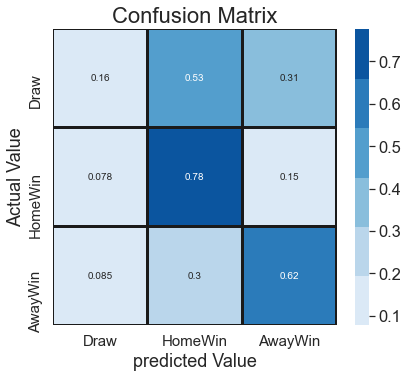

In [155]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_,X_train_scaled,X_test_scaled,y_train,y_test)

The Catboost model was very fast at predicting the model with a score of 58% on the test data, which is still the same as most of the other models.

### Testing the Final model on the holdout dataset-(Unseen Data)


I will be testing the final model on the validation set to see how the model will perform on unseen data.

In [215]:
final_model = LogisticRegression(multi_class="multinomial",C = 5.0,penalty='l2',solver='newton-cg')
model_lg =final_model.fit(X_train_scaled,y_train)
model_lg

LogisticRegression(C=5.0, multi_class='multinomial', solver='newton-cg')

In [216]:
y_hat_val = final_model.predict(X_val_scaled)
y_hat_train = final_model.predict(X_train_scaled)

In [217]:
residuals = np.abs(y_train - y_hat_train)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    4723
1    2663
2     699
Name: target, dtype: int64
0    0.584168
1    0.329375
2    0.086456
Name: target, dtype: float64


In [218]:
residuals = np.abs(y_val - y_hat_val)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    1052
1     571
2     161
Name: target, dtype: int64
0    0.589686
1    0.320067
2    0.090247
Name: target, dtype: float64


In [219]:
val_prob = final_model.predict_proba(X_val_scaled)

Accuracy Score: 0.5896860986547086
----
Log loss Score: 0.8908121808838835
----
              precision    recall  f1-score   support

           0       0.54      0.08      0.14       459
           1       0.60      0.85      0.70       795
           2       0.58      0.64      0.61       530

    accuracy                           0.59      1784
   macro avg       0.57      0.52      0.48      1784
weighted avg       0.58      0.59      0.53      1784



Text(106.0, 0.5, 'Actual Value')

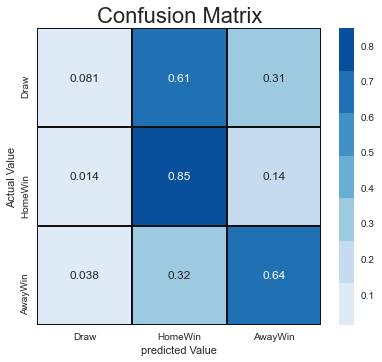

In [220]:
print(f"Accuracy Score: {accuracy_score(y_val,y_hat_val)}")
print("----")
print(f"Log loss Score: {log_loss(y_val, val_prob)}")
print("----")
print(classification_report(y_val,y_hat_val))


plt.figure(figsize=(14,12))
plt.subplot(221)
ax=sns.heatmap(confusion_matrix(y_val,y_hat_val,normalize='true'),
               annot=True,linecolor='k',linewidth=1,
               cmap =sns.color_palette('Blues',7))
ax.xaxis.set_ticklabels(['Draw','HomeWin','AwayWin'])
ax.yaxis.set_ticklabels(['Draw','HomeWin','AwayWin'])
plt.title("Confusion Matrix",fontsize=22)
plt.xlabel("predicted Value")
plt.ylabel("Actual Value")

In [260]:
#pickle final model 
deploy_model = pickle.dump(final_model,open('model.sav','wb'))

# Top five feature importances of the final model

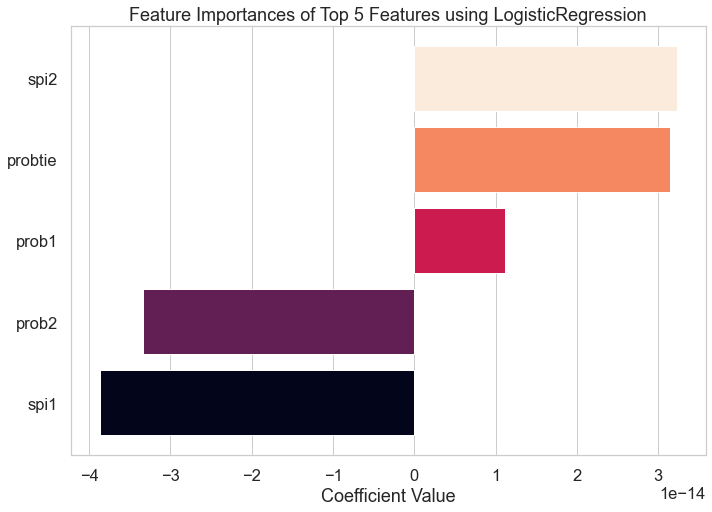

<AxesSubplot:title={'center':'Feature Importances of Top 5 Features using LogisticRegression'}, xlabel='Coefficient Value'>

In [258]:
#get the top five feature importance for the model
features =FeatureImportances(final_model,labels= columns,stack=False,
                             size=(720,520),relative=False,
                             colormap='rocket',xlabel='Coefficient Value',topn=5)
features.fit(X_train_scaled,y_train,test_size = 2.5)
features.show()

The top five most important features that the model predict is the soccer power index for the home team(spi1), the soccer power index for the away team(spi2), and the probabilities that the game will be a homewin(prob1), draw(probtie) or Awaywin(prob2). When using the model for predicting, the top five features are recommended in other to win the match betting.

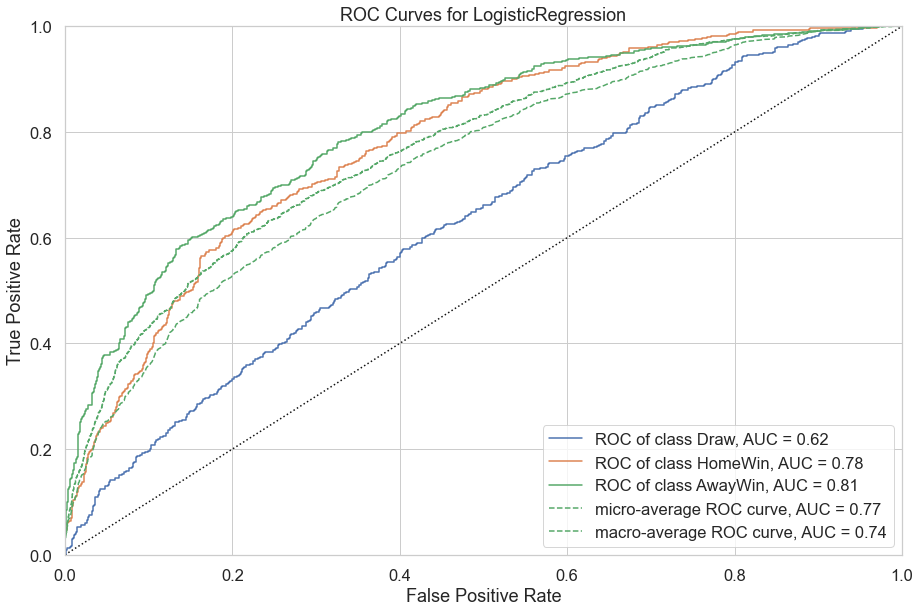

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [256]:
#plot the ROC-AUC plot for train and validation set
roc_auc_curve = ROCAUC(final_model,classes = ['Draw','HomeWin','AwayWin'],size =(1080,700))
roc_auc_curve.fit(X_train_scaled,y_train)
roc_auc_curve.score(X_val_scaled,y_val)
roc_auc_curve.show()

## Summary of all models

- There was a monotonic trend performance with the accuracy score of all the models. As one increases the other decreases, which is due to the complexity of soccer games. After tuning several models, the Logistic Regression model was the best performing model in classifying the business problem. The model achieved an accuracy score of 60% on unseen data, weighted average score at 53% with a probability of loss at -0.9. The macro-average area under the curve is 0.74 and the micro average area under the curve is 0.77.

## Final Evaluation

- Even though soccer game is convoluted, I am confident that the model will be able to predict a match fixture either home and away with a 60% accuracy. The model was trained using the data from the last five season and I evaluated it's performance in predicting match results for the current season. The model did great predicting 80% average accuracy on the match fixture between . Soccer Analyst and soccer fans can make use of the model to minimize risk and also yield a high return on the bets. 

## Limitation

- There is a limitation to the model, due to developing the model using seven leagues which are; Barclays Premier League, UEFA Champions League,Major League Soccer, Italy Serie A , Spanish Primera Division, German Bundesliga, and French Ligue 1. Therefore, the performance of the model was not evaluated for other football leagues. Also, not all the teams are included in the training of the model due to their factors.

## Conclusions

- My recommendation will be to take into consideration each team's soccer power index before using the model to predict the match. To make it simple, using the model to predict a match before betting will give you more relevant information about each team's quality and more valuable insights to their performance analysis than studying the results afterwards.

- The stakeholder can use the model to predict upcoming match fixtures, but will advise to backup bets, if the model predicts a win class, back it up with a draw class because soccer is a tricky sport to model due to few goals scored in each match.


## Next Steps

- **Deep Learning Approach:** I have only used the supervised learning approach in the process of developing the machine learning model. In the future, I would like to incorporate unsupervised learning techniques like deep learning to improve the accuracy of the model. 

- **Team players performance:** I would like to include the soccer players, their physical performance and capabilities in the future analysis that will help improve the accuracy of the model.

- **Fifa World Cup soccer:** Since I only base my study on seven leagues. In the future, I would like to add more leagues and continue to update the model using the world cup data.
